## Final Project - Basics of deep learning

---
<br>

### Name and ID:
Student 1: Eyal Pasha, 213957814
<br>
Student 2: Nir Tuttnauer, 208585422

## **Chest X-Ray Images (Pneumonia) Dataset**


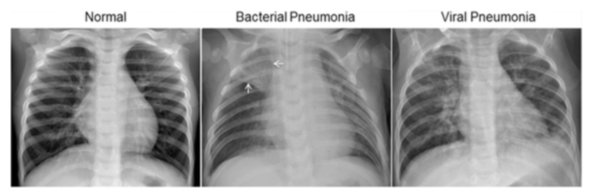

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Link: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


<br>
<br>
Content:

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

<br>

Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2


## **README**


**Download links**:
* Dataset -

**Usage Guide**:

1.   Download dataset:

*   use the provided link to download the "dataset.zip" file.
*   Save it to your local machine.

2.   Upload to Google Drive:
* Go to your [Google Drive](https://drive.google.com).
* Open Your Drives Root Directory
* Upload the "dataset.zip" file into this folder.

3. Rename the File:
* Make sure the file is named exactly "dataset.zip" as mentioned in the instructions.

4. Run the "setup" section:
* In the Train Notebook press play the "Setup" section.
* It will ask you to give access premitons to your Drive, You need to connect to the same Drive you uploaded the files to.

5. Run Each Part:
* Once the setup is complete, you can run each part of the notebook as instructed.
* This might involve executing code cells to perform tasks like loading models, processing data, or running tests.

## **Setup**

**Imports**

In [ ]:
import os
import random
import shutil
from google.colab import drive
import shutil
import numpy as np
import zipfile
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import  SGD
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D, Input, Concatenate, UpSampling2D, ReLU)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Functions**

In [ ]:
def model_full_report(model,history, test_generator):
    # Plot training and validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Make predictions using the model
    predictions = model.predict(test_generator)

    # Get predicted labels (argmax to get the class with the highest probability)
    predicted_labels = predictions.argmax(axis=1)

    # Get true labels
    true_labels = test_generator.classes

    # Generate a classification report
    report = classification_report(true_labels, predicted_labels)

    # Print the classification report
    print("Classification Report:\n", report)

def save_model(model, model_filename='unnamed.h5'):
    weights_filename = os.path.splitext(model_filename)[0] + '_w.h5'
    model.save(model_filename)
    model.save_weights(weights_filename)

def save_history(history, filename='unnamed.npy'):
    np.save(filename, history)

def load_saved_model(model_filename='unnamed.h5'):
    return load_model(model_filename)

def load_saved_history(filename='unnamed.npy'):
    return np.load(filename, allow_pickle=True).item()

class Config:
    def __init__(self, img_width=256, img_height=256, epochs=10, batch_size=32, learning_rate=0.0001):
        self.img_width = img_width
        self.img_height = img_height
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def generate_data(self, train_data_dir, test_data_dir):
        # Data augmentation for training set
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Only rescaling for validation/test set
        test_datagen = ImageDataGenerator(rescale=1. / 255)

        # Generating training set
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating validation set
        validation_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating test set
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False  # Ensure the order of predictions matches the order of actual labels
        )

        return train_generator, validation_generator, test_generator


**For Google Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Data extraction and reorganization**

In [ ]:
# for images
# Specify the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/dataset.zip'
extracted_path = '/content/dataset'
# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

#for models and weights:
zip_path = '/content/drive/MyDrive/models.zip'
extracted_path = '/content/'
# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Function to delete a directory and its contents
def delete_directory(path):
    try:
        shutil.rmtree(path)
        print(f"Directory '{path}' successfully deleted.")
    except FileNotFoundError:
        print(f"Directory '{path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Define the paths to the directories you want to delete
dir_to_delete1 = '/content/dataset/chest_xray/__MACOSX'
dir_to_delete2 = '/content/dataset/chest_xray/val'
dir_to_delete3 = '/content/dataset/chest_xray/chest_xray/val'

# Delete the first directory
delete_directory(dir_to_delete1)

# Move NORMAL images from val to train
src_path_normal = '/content/dataset/chest_xray/val/NORMAL'
dest_path_normal = '/content/dataset/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_normal):
    shutil.move(os.path.join(src_path_normal, filename), os.path.join(dest_path_normal, filename))

# Move PNEUMONIA images from val to val/NORMAL
src_path_pneumonia = '/content/dataset/chest_xray/val/PNEUMONIA'
dest_path_pneumonia = '/content/dataset/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia):
    shutil.move(os.path.join(src_path_pneumonia, filename), os.path.join(dest_path_pneumonia, filename))

# Move NORMAL images from chest_xray/val to chest_xray/train
src_path_chest_xray_normal = '/content/dataset/chest_xray/chest_xray/val/NORMAL'
dest_path_chest_xray_normal = '/content/dataset/chest_xray/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_chest_xray_normal):
    shutil.move(os.path.join(src_path_chest_xray_normal, filename), os.path.join(dest_path_chest_xray_normal, filename))

# Move PNEUMONIA images from chest_xray/val to chest_xray/val/NORMAL
src_path_pneumonia_chest_xray = '/content/dataset/chest_xray/chest_xray/val/PNEUMONIA'
dest_path_pneumonia_chest_xray = '/content/dataset/chest_xray/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia_chest_xray):
    shutil.move(os.path.join(src_path_pneumonia_chest_xray, filename), os.path.join(dest_path_pneumonia_chest_xray, filename))

# Delete the 'val' folders
delete_directory(dir_to_delete2)
delete_directory(dir_to_delete3)

# Define the paths for the test directory
test_dir = '/content/dataset/chest_xray/chest_xray/test'
src_path_pneumonia_test = os.path.join(test_dir, 'PNEUMONIA')
dest_path_bacterial = os.path.join(test_dir, 'BACTERIAL')
dest_path_viral = os.path.join(test_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders
os.makedirs(dest_path_bacterial, exist_ok=True)
os.makedirs(dest_path_viral, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_test):
    src_file_path = os.path.join(src_path_pneumonia_test, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the test directory
delete_directory(src_path_pneumonia_test)

# Define the paths for the train directory
train_dir = '/content/dataset/chest_xray/chest_xray/train'
src_path_pneumonia_train = os.path.join(train_dir, 'PNEUMONIA')
dest_path_bacterial_train = os.path.join(train_dir, 'BACTERIAL')
dest_path_viral_train = os.path.join(train_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders in the train directory
os.makedirs(dest_path_bacterial_train, exist_ok=True)
os.makedirs(dest_path_viral_train, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_train):
    src_file_path = os.path.join(src_path_pneumonia_train, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial_train, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral_train, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the train directory
delete_directory(src_path_pneumonia_train)

# Function to count files in a directory
def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Define paths
dataset_path = "/content/dataset/chest_xray/chest_xray"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")

# Create VAL folder if not exists
if not os.path.exists(val_path):
    os.makedirs(val_path)

# Define the number of images to move to the validation set
num_images_val = 345

# Define the new number of images in the training set
new_num_images_train = 1000

# Function to move random images from the train directory to the val directory
def move_random_images(source_dir, dest_dir, num_images):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    files = os.listdir(source_dir)
    selected_files = random.sample(files, num_images)

    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)

# Move random images to the validation set
val_bacterial_path = os.path.join(val_path, "BACTERIAL")
val_normal_path = os.path.join(val_path, "NORMAL")
val_viral_path = os.path.join(val_path, "VIRAL")

move_random_images(os.path.join(train_path, "BACTERIAL"), val_bacterial_path, num_images_val)
move_random_images(os.path.join(train_path, "NORMAL"), val_normal_path, num_images_val)
move_random_images(os.path.join(train_path, "VIRAL"), val_viral_path, num_images_val)

# Limit the number of images in the training set
def limit_images_in_directory(directory, new_num_images):
    files = os.listdir(directory)
    excess_files = files[new_num_images:]

    for file in excess_files:
        file_path = os.path.join(directory, file)
        os.remove(file_path)

# Limit the number of images in the training set for each class
limit_images_in_directory(os.path.join(train_path, "BACTERIAL"), new_num_images_train)
limit_images_in_directory(os.path.join(train_path, "NORMAL"), new_num_images_train)
limit_images_in_directory(os.path.join(train_path, "VIRAL"), new_num_images_train)

# Display the counts after the changes
bacterial_count_train = count_files_in_directory(os.path.join(train_path, "BACTERIAL"))
normal_count_train = count_files_in_directory(os.path.join(train_path, "NORMAL"))
viral_count_train = count_files_in_directory(os.path.join(train_path, "VIRAL"))

bacterial_count_val = count_files_in_directory(val_bacterial_path)
normal_count_val = count_files_in_directory(val_normal_path)
viral_count_val = count_files_in_directory(val_viral_path)

print("\n--- After Modifications ---")
print("\nNumber of photos in BACTERIAL directory (Train):", bacterial_count_train)
print("Number of photos in NORMAL directory (Train):", normal_count_train)
print("Number of photos in VIRAL directory (Train):", viral_count_train)

print("\nNumber of photos in BACTERIAL directory (Validation):", bacterial_count_val)
print("Number of photos in NORMAL directory (Validation):", normal_count_val)
print("Number of photos in VIRAL directory (Validation):", viral_count_val)

# unmount the drive
drive.flush_and_unmount()


KeyboardInterrupt: 

## **Task 1 - Binary Classifiaction**

**Preping the data**

In [ ]:
# Set the paths
train_data_dir = 'dataset/chest_xray/train'
test_data_dir = 'dataset/chest_xray/test'

# # Set the paths for drive
# train_data_dir = 'content/dataset/chest_xray/train'
# test_data_dir = 'content/dataset/chest_xray/test'

# Define parameters
config = Config(img_width=256, img_height=256, epochs=10, batch_size=32, learning_rate=0.0001)

# Generate data using the config
train_generator, validation_generator, test_generator = config.generate_data(train_data_dir, test_data_dir)


Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Subset train**

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(config.img_width, config.img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=500 // config.batch_size,
    epochs=config.epochs,
    validation_data=validation_generator,
    validation_steps=100 // config.batch_size
)


# Evaluate the model on the test set
eval_result = model.evaluate(test_generator, verbose=1)

# Print the evaluation results
print("Test Accuracy:", eval_result[1])

Epoch 1/10
15/15 [==============================] - 14s 675ms/step - loss: 1.8016 - accuracy: 0.5750 - val_loss: 1.0865 - val_accuracy: 0.4062
Epoch 2/10
15/15 [==============================] - 11s 712ms/step - loss: 0.8789 - accuracy: 0.6687 - val_loss: 1.2653 - val_accuracy: 0.6146
Epoch 3/10
15/15 [==============================] - 11s 715ms/step - loss: 0.6124 - accuracy: 0.7500 - val_loss: 0.5357 - val_accuracy: 0.7292
Epoch 4/10
15/15 [==============================] - 11s 734ms/step - loss: 0.4666 - accuracy: 0.7937 - val_loss: 0.5228 - val_accuracy: 0.7292
Epoch 5/10
15/15 [==============================] - 11s 715ms/step - loss: 0.4567 - accuracy: 0.7833 - val_loss: 0.3745 - val_accuracy: 0.8750
Epoch 6/10
15/15 [==============================] - 11s 726ms/step - loss: 0.4245 - accuracy: 0.8229 - val_loss: 0.3512 - val_accuracy: 0.8958
Epoch 7/10
15/15 [==============================] - 10s 698ms/step - loss: 0.3433 - accuracy: 0.8333 - val_loss: 0.3370 - val_accuracy: 0.8646

**Full train**

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=500 // config.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=100 // config.batch_size
)

model.save('models/1/binary_classification_model_full_dataset.h5')
model.save_weights('models/1/binary_classification_weights_full_dataset.h5')
save_history(model.history,'models/1/binary_classification_history_full_dataset.npy')

# Evaluate the model on the test set
eval_result = model.evaluate(test_generator, verbose=1)

# Print the evaluation results
print("Test Accuracy:", eval_result[1])

Epoch 1/100
15/15 [==============================] - 12s 757ms/step - loss: 0.2675 - accuracy: 0.8938 - val_loss: 0.2545 - val_accuracy: 0.9062
Epoch 2/100
15/15 [==============================] - 10s 693ms/step - loss: 0.2044 - accuracy: 0.9079 - val_loss: 0.2730 - val_accuracy: 0.9167
Epoch 3/100
15/15 [==============================] - 11s 705ms/step - loss: 0.1806 - accuracy: 0.9375 - val_loss: 0.3302 - val_accuracy: 0.8750
Epoch 4/100
15/15 [==============================] - 10s 697ms/step - loss: 0.1487 - accuracy: 0.9438 - val_loss: 0.4235 - val_accuracy: 0.8438
Epoch 5/100
15/15 [==============================] - 11s 705ms/step - loss: 0.1913 - accuracy: 0.9125 - val_loss: 0.2702 - val_accuracy: 0.8542
Epoch 6/100
15/15 [==============================] - 10s 691ms/step - loss: 0.1971 - accuracy: 0.9250 - val_loss: 0.4022 - val_accuracy: 0.8958
Epoch 7/100
15/15 [==============================] - 11s 722ms/step - loss: 0.1563 - accuracy: 0.9333 - val_loss: 0.3115 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 5s 209ms/step - loss: 0.3066 - accuracy: 0.8926
Test Accuracy: 0.8926281929016113


Full Train Report

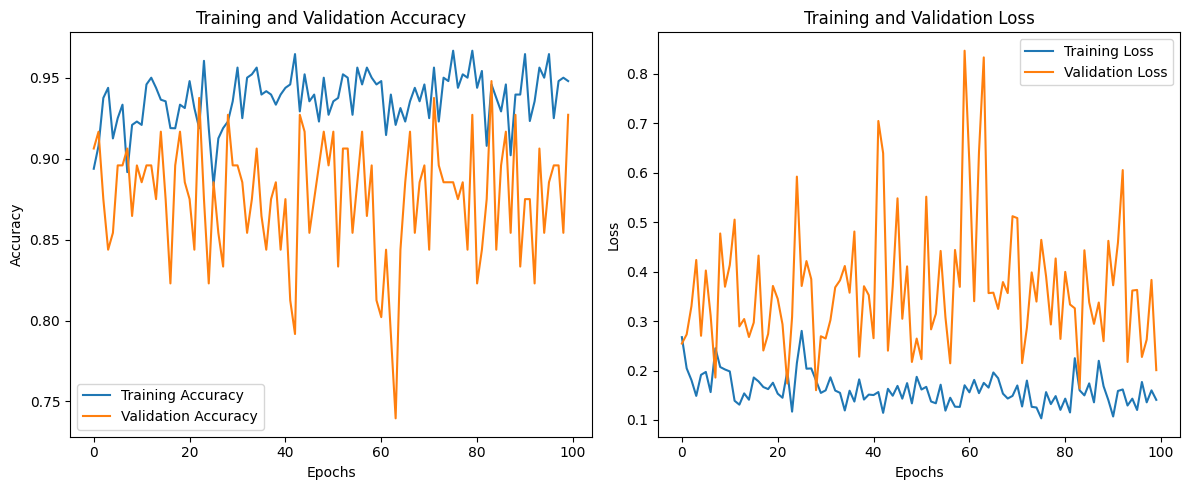

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

history_full = history

# Plot training and validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_full.history['accuracy'], label='Training Accuracy')
plt.plot(history_full.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_full.history['loss'], label='Training Loss')
plt.plot(history_full.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('multi_full_report.png')
plt.show()


In [ ]:
model.save('models/1/binary_classification_model_full_dataset.h5')
model.save_weights('models/1/binary_classification_weights_full_dataset.h5')
save_history(model.history,'models/1/binary_classification_history_full_dataset.npy')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Task 2 - Multi-Class Classification**

**Data prep**

In [ ]:
# Set paths
train_data_dir_multi = '/content/dataset/chest_xray/chest_xray/train'
test_data_dir_multi = '/content/dataset/chest_xray/chest_xray/test'

# Data generator with data augmentation for training
train_datagen_multi = ImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         rotation_range=15)  # Experiment with rotation range


# Data generator for validation and test (no augmentation)
val_test_datagen_multi = ImageDataGenerator(rescale=1./255)

# Parameters
img_width, img_height = 256, 256
batch_size = 16  # Adjusted for a smaller batch size

# Data generators with black and white images
train_generator_multi = train_datagen_multi.flow_from_directory(train_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

val_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

test_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

Found 2999 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


**Full train:**

In [ ]:
base_model_full = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze pre-trained layers
for layer in base_model_full.layers:
    layer.trainable = False

# Create a new model with a single-channel input
single_channel_input = Input(shape=(img_width, img_height, 1))
repeated_channel_input = Concatenate()([single_channel_input, single_channel_input, single_channel_input])

# Use the repeated channel input as input to the pre-trained VGG16 model
x = base_model_full(repeated_channel_input)

# Flatten the output of the VGG16 model
x = Flatten()(x)

# Add custom dense layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)  # Adjust for the number of classes

# Create the model
model_transfer_full = Model(inputs=single_channel_input, outputs=output_layer)

# Compile the model
model_transfer_full.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.0001),
                      metrics=['accuracy'])

# Train the model
hist_transfer_full = model_transfer_full.fit(train_generator_multi,
                                   steps_per_epoch=train_generator_multi.samples // batch_size,
                                   epochs=100,
                                   validation_data=val_generator_multi,
                                   validation_steps=len(val_generator_multi)
                                   )

# Save the weights
save_model(model_transfer_full, '/content/models/2/multi_full.h5')
save_history(hist_transfer_full, '/content/models/2/multi_full.npy')

# Evaluate on the test set
eval_result_transfer = model_transfer_full.evaluate(test_generator_multi, verbose=1)
print("Test Accuracy (Transfer Learning):", eval_result_transfer[1])

Epoch 1/100
187/187 [==============================] - 35s 181ms/step - loss: 0.6092 - accuracy: 0.7348 - val_loss: 0.4750 - val_accuracy: 0.8510
Epoch 2/100
187/187 [==============================] - 34s 180ms/step - loss: 0.4800 - accuracy: 0.7885 - val_loss: 0.3910 - val_accuracy: 0.8734
Epoch 3/100
187/187 [==============================] - 33s 179ms/step - loss: 0.4528 - accuracy: 0.7945 - val_loss: 0.6397 - val_accuracy: 0.7981
Epoch 4/100
187/187 [==============================] - 34s 180ms/step - loss: 0.4366 - accuracy: 0.8046 - val_loss: 0.4651 - val_accuracy: 0.8237
Epoch 5/100
187/187 [==============================] - 34s 179ms/step - loss: 0.4162 - accuracy: 0.8166 - val_loss: 0.4285 - val_accuracy: 0.8510
Epoch 6/100
187/187 [==============================] - 34s 180ms/step - loss: 0.3940 - accuracy: 0.8253 - val_loss: 0.4111 - val_accuracy: 0.8542
Epoch 7/100
187/187 [==============================] - 34s 179ms/step - loss: 0.3596 - accuracy: 0.8481 - val_loss: 0.5153 -

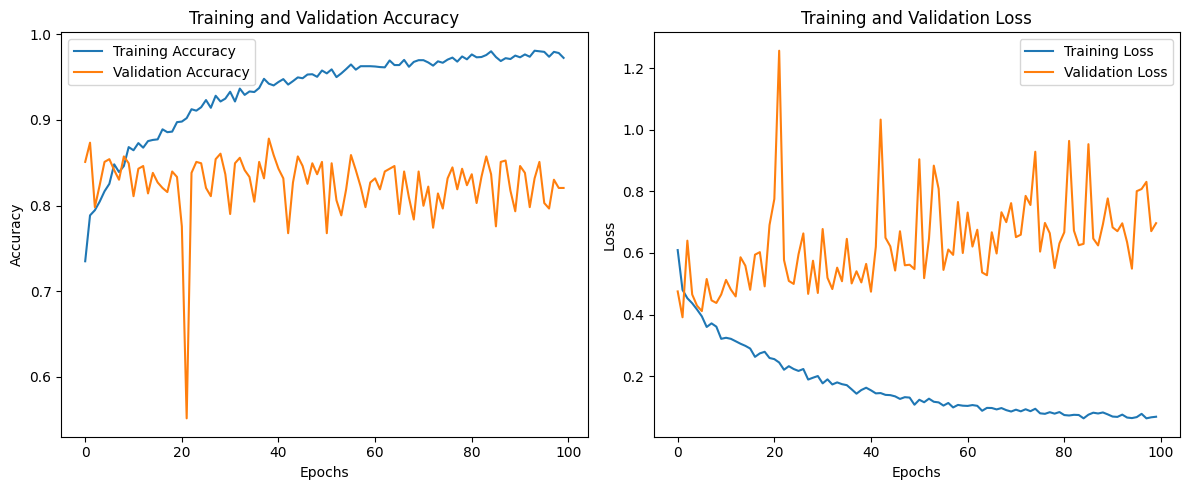

39/39 [==============================] - 3s 75ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.35      0.37       234
           1       0.36      0.38      0.37       242
           2       0.22      0.25      0.23       148

    accuracy                           0.33       624
   macro avg       0.33      0.32      0.32       624
weighted avg       0.34      0.33      0.34       624



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Plot training and validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_transfer_full.history['accuracy'], label='Training Accuracy')
plt.plot(hist_transfer_full.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist_transfer_full.history['loss'], label='Training Loss')
plt.plot(hist_transfer_full.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('multi_full_report.png')
plt.show()

predictions = model_transfer_full.predict(test_generator_multi)

# Get predicted labels (argmax to get the class with the highest probability)
predicted_labels = predictions.argmax(axis=1)

# Get true labels
true_labels = test_generator_multi.classes

# Generate a classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:\n", report)


# **Task 3/4 - Anomaly Detection**

In [ ]:
from keras.src.callbacks import ModelCheckpoint

# Set paths
train_data_dir = 'dataset/chest_xray/train'
test_data_dir = 'dataset/chest_xray/test'

# Parameters
img_width, img_height = 512, 512  # Adjusted target size
batch_size = 8  # Adjusted batch size
epochs = 1000 # Adjusted number of epochs
# Data generator for training (no data augmentation for anomaly detection)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3)

# Data generators
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='input',  # Input and target are the same (autoencoder)
                                                    color_mode='grayscale',
                                                    classes=['NORMAL'])
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='input',  # Input and target are the same (autoencoder)
                                                        color_mode='grayscale',
                                                        classes=['NORMAL'])

anomoly_generator= train_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='input',  # Input and target are the same (autoencoder)
                                                        color_mode='grayscale',
                                                        classes=['PNEUMONIA'])

# Autoencoder model with perceptual loss (4 layers in encoder and decoder)
input_img = Input(shape=(img_width, img_height, 1))
x = Conv2D(256, (3, 3), activation=None, padding='same')(input_img)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

checkpoint_filepath = f'models/4/autoencoder_cross_checkpoint{epochs}.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save only weights
    monitor='val_loss',     # Monitor validation loss
    mode='min',             # Mode can be 'min' or 'max' depending on the metric being monitored
    save_best_only=False,     # Save only the best model (lowest validation loss)
    verbose=1                # Verbosity level
)

callbacks = [EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True), checkpoint_callback]
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['mse', 'accuracy'])
autoencoder.summary()
# Train the autoencoder with perceptual loss on normal images
history = autoencoder.fit(train_generator,
                          steps_per_epoch=len(train_generator),
                          validation_data=test_generator,
                          validation_steps=len(test_generator),
                          epochs=epochs,
                          shuffle=True,
                          callbacks=callbacks)


loss_normal = autoencoder.evaluate(test_generator, verbose=0)
print(f"Reconstruction loss on normal images: {loss_normal}")
# Evaluate on sick images
loss_sick = autoencoder.evaluate(anomoly_generator, verbose=0)
threshold = 0.00001  # Adjust this threshold based on your evaluation
predictions_sick = (loss_sick[0] > threshold)
print(f"Anomaly detected: {predictions_sick}")



autoencoder.save(f'models/4/autoencoder_model_crops_cross_{epochs}e.h5')
autoencoder.save_weights(f'models/4/autoencoder_weights_crops_cross_{epochs}e.h5')
save_history(history,f'models/4/autoencoder_history_crops_cross_{epochs}e.npy')

Found 1349 images belonging to 1 classes.
Found 234 images belonging to 1 classes.
Found 390 images belonging to 1 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 256)     2560      
                                                                 
 batch_normalization_1 (Bat  (None, 512, 512, 256)     1024      
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 512, 512, 256)     0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 256, 256, 256)     0         
 g2D)                                                            
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - ETA: 0s - loss: 0.5771 - mse: 0.0139 - accuracy: 0.0916
Epoch 2: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5771 - mse: 0.0139 - accuracy: 0.0916 - val_loss: 0.6693 - val_mse: 0.0493 - val_accuracy: 0.0646
Epoch 3/1000
169/169 [==============================] - ETA: 0s - loss: 0.5690 - mse: 0.0109 - accuracy: 0.0908
Epoch 3: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 263ms/step - loss: 0.5690 - mse: 0.0109 - accuracy: 0.0908 - val_loss: 0.6440 - val_mse: 0.0375 - val_accuracy: 0.0658
Epoch 4/1000
169/169 [==============================] - ETA: 0s - loss: 0.5671 - mse: 0.0094 - accuracy: 0.0891
Epoch 4: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5671 - mse: 0.0094 - accuracy: 0.0891 - val_loss: 0.5812 - val_mse:

The Autoencoder Architecture

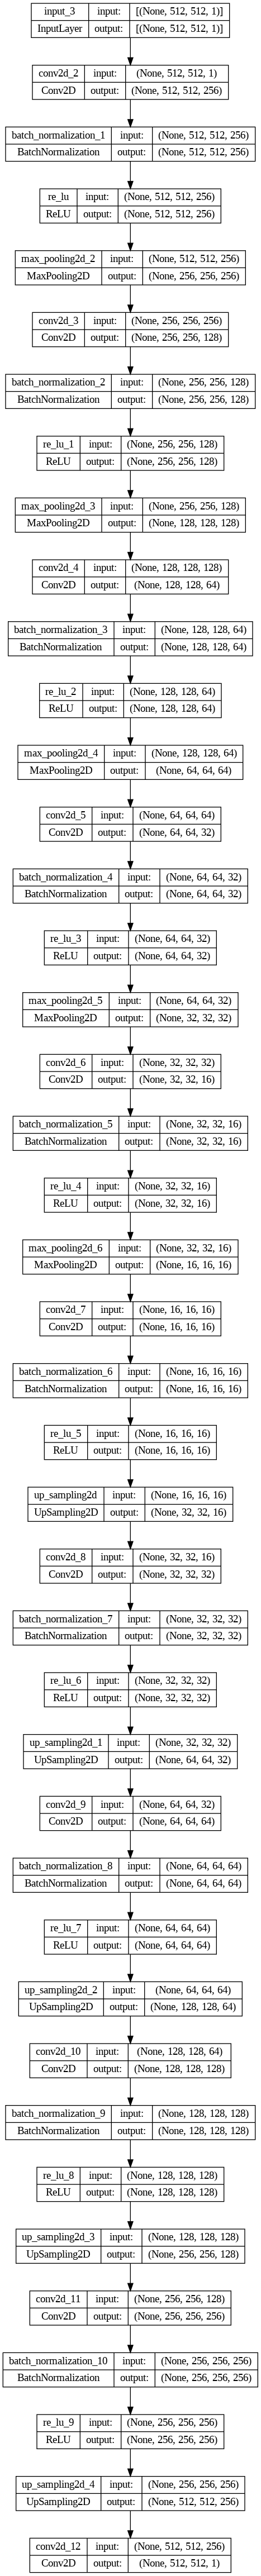

In [ ]:
from keras.utils import plot_model
os.makedirs('/content/imgs/4', exist_ok=True)
plot_model(autoencoder, to_file=f'/content/imgs/4/autoencoder_plot_{epochs}e.png', show_shapes=True, show_layer_names=True)


Train Report (Menual analasis)

In [ ]:
training_logs = """Epoch 1/1000
169/169 [==============================] - ETA: 0s - loss: 0.6103 - mse: 0.0260 - accuracy: 0.0874
Epoch 1: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 66s 332ms/step - loss: 0.6103 - mse: 0.0260 - accuracy: 0.0874 - val_loss: 0.6862 - val_mse: 0.0572 - val_accuracy: 0.0473
Epoch 2/1000
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
169/169 [==============================] - ETA: 0s - loss: 0.5771 - mse: 0.0139 - accuracy: 0.0916
Epoch 2: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5771 - mse: 0.0139 - accuracy: 0.0916 - val_loss: 0.6693 - val_mse: 0.0493 - val_accuracy: 0.0646
Epoch 3/1000
169/169 [==============================] - ETA: 0s - loss: 0.5690 - mse: 0.0109 - accuracy: 0.0908
Epoch 3: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 263ms/step - loss: 0.5690 - mse: 0.0109 - accuracy: 0.0908 - val_loss: 0.6440 - val_mse: 0.0375 - val_accuracy: 0.0658
Epoch 4/1000
169/169 [==============================] - ETA: 0s - loss: 0.5671 - mse: 0.0094 - accuracy: 0.0891
Epoch 4: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5671 - mse: 0.0094 - accuracy: 0.0891 - val_loss: 0.5812 - val_mse: 0.0128 - val_accuracy: 0.0704
Epoch 5/1000
169/169 [==============================] - ETA: 0s - loss: 0.5624 - mse: 0.0083 - accuracy: 0.0915
Epoch 5: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5624 - mse: 0.0083 - accuracy: 0.0915 - val_loss: 0.5701 - val_mse: 0.0069 - val_accuracy: 0.0616
Epoch 6/1000
169/169 [==============================] - ETA: 0s - loss: 0.5592 - mse: 0.0079 - accuracy: 0.0941
Epoch 6: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5592 - mse: 0.0079 - accuracy: 0.0941 - val_loss: 0.5651 - val_mse: 0.0066 - val_accuracy: 0.0678
Epoch 7/1000
169/169 [==============================] - ETA: 0s - loss: 0.5581 - mse: 0.0073 - accuracy: 0.0929
Epoch 7: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5581 - mse: 0.0073 - accuracy: 0.0929 - val_loss: 0.5632 - val_mse: 0.0065 - val_accuracy: 0.0710
Epoch 8/1000
169/169 [==============================] - ETA: 0s - loss: 0.5614 - mse: 0.0071 - accuracy: 0.0880
Epoch 8: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 261ms/step - loss: 0.5614 - mse: 0.0071 - accuracy: 0.0880 - val_loss: 0.5644 - val_mse: 0.0060 - val_accuracy: 0.0672
Epoch 9/1000
169/169 [==============================] - ETA: 0s - loss: 0.5593 - mse: 0.0067 - accuracy: 0.0905
Epoch 9: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5593 - mse: 0.0067 - accuracy: 0.0905 - val_loss: 0.5634 - val_mse: 0.0059 - val_accuracy: 0.0673
Epoch 10/1000
169/169 [==============================] - ETA: 0s - loss: 0.5566 - mse: 0.0065 - accuracy: 0.0929
Epoch 10: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5566 - mse: 0.0065 - accuracy: 0.0929 - val_loss: 0.5590 - val_mse: 0.0058 - val_accuracy: 0.0725
Epoch 11/1000
169/169 [==============================] - ETA: 0s - loss: 0.5567 - mse: 0.0064 - accuracy: 0.0911
Epoch 11: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5567 - mse: 0.0064 - accuracy: 0.0911 - val_loss: 0.5589 - val_mse: 0.0054 - val_accuracy: 0.0729
Epoch 12/1000
169/169 [==============================] - ETA: 0s - loss: 0.5561 - mse: 0.0061 - accuracy: 0.0921
Epoch 12: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5561 - mse: 0.0061 - accuracy: 0.0921 - val_loss: 0.5640 - val_mse: 0.0054 - val_accuracy: 0.0631
Epoch 13/1000
169/169 [==============================] - ETA: 0s - loss: 0.5573 - mse: 0.0060 - accuracy: 0.0903
Epoch 13: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5573 - mse: 0.0060 - accuracy: 0.0903 - val_loss: 0.5618 - val_mse: 0.0051 - val_accuracy: 0.0646
Epoch 14/1000
169/169 [==============================] - ETA: 0s - loss: 0.5540 - mse: 0.0058 - accuracy: 0.0940
Epoch 14: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5540 - mse: 0.0058 - accuracy: 0.0940 - val_loss: 0.5533 - val_mse: 0.0051 - val_accuracy: 0.0793
Epoch 15/1000
169/169 [==============================] - ETA: 0s - loss: 0.5561 - mse: 0.0058 - accuracy: 0.0916
Epoch 15: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5561 - mse: 0.0058 - accuracy: 0.0916 - val_loss: 0.5517 - val_mse: 0.0050 - val_accuracy: 0.0832
Epoch 16/1000
169/169 [==============================] - ETA: 0s - loss: 0.5537 - mse: 0.0056 - accuracy: 0.0934
Epoch 16: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5537 - mse: 0.0056 - accuracy: 0.0934 - val_loss: 0.5604 - val_mse: 0.0050 - val_accuracy: 0.0677
Epoch 17/1000
169/169 [==============================] - ETA: 0s - loss: 0.5526 - mse: 0.0055 - accuracy: 0.0940
Epoch 17: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5526 - mse: 0.0055 - accuracy: 0.0940 - val_loss: 0.5598 - val_mse: 0.0048 - val_accuracy: 0.0661
Epoch 18/1000
169/169 [==============================] - ETA: 0s - loss: 0.5589 - mse: 0.0054 - accuracy: 0.0849
Epoch 18: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5589 - mse: 0.0054 - accuracy: 0.0849 - val_loss: 0.5601 - val_mse: 0.0046 - val_accuracy: 0.0706
Epoch 19/1000
169/169 [==============================] - ETA: 0s - loss: 0.5532 - mse: 0.0054 - accuracy: 0.0928
Epoch 19: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5532 - mse: 0.0054 - accuracy: 0.0928 - val_loss: 0.5617 - val_mse: 0.0046 - val_accuracy: 0.0612
Epoch 20/1000
169/169 [==============================] - ETA: 0s - loss: 0.5530 - mse: 0.0052 - accuracy: 0.0926
Epoch 20: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5530 - mse: 0.0052 - accuracy: 0.0926 - val_loss: 0.5628 - val_mse: 0.0046 - val_accuracy: 0.0632
Epoch 21/1000
169/169 [==============================] - ETA: 0s - loss: 0.5565 - mse: 0.0052 - accuracy: 0.0873
Epoch 21: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5565 - mse: 0.0052 - accuracy: 0.0873 - val_loss: 0.5567 - val_mse: 0.0046 - val_accuracy: 0.0679
Epoch 22/1000
169/169 [==============================] - ETA: 0s - loss: 0.5535 - mse: 0.0051 - accuracy: 0.0903
Epoch 22: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5535 - mse: 0.0051 - accuracy: 0.0903 - val_loss: 0.5682 - val_mse: 0.0045 - val_accuracy: 0.0549
Epoch 23/1000
169/169 [==============================] - ETA: 0s - loss: 0.5521 - mse: 0.0050 - accuracy: 0.0939
Epoch 23: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5521 - mse: 0.0050 - accuracy: 0.0939 - val_loss: 0.5616 - val_mse: 0.0045 - val_accuracy: 0.0664
Epoch 24/1000
169/169 [==============================] - ETA: 0s - loss: 0.5537 - mse: 0.0050 - accuracy: 0.0913
Epoch 24: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5537 - mse: 0.0050 - accuracy: 0.0913 - val_loss: 0.5581 - val_mse: 0.0047 - val_accuracy: 0.0686
Epoch 25/1000
169/169 [==============================] - ETA: 0s - loss: 0.5525 - mse: 0.0050 - accuracy: 0.0924
Epoch 25: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5525 - mse: 0.0050 - accuracy: 0.0924 - val_loss: 0.5621 - val_mse: 0.0042 - val_accuracy: 0.0619
Epoch 26/1000
169/169 [==============================] - ETA: 0s - loss: 0.5528 - mse: 0.0049 - accuracy: 0.0926
Epoch 26: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5528 - mse: 0.0049 - accuracy: 0.0926 - val_loss: 0.5532 - val_mse: 0.0044 - val_accuracy: 0.0735
Epoch 27/1000
169/169 [==============================] - ETA: 0s - loss: 0.5542 - mse: 0.0049 - accuracy: 0.0893
Epoch 27: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5542 - mse: 0.0049 - accuracy: 0.0893 - val_loss: 0.5568 - val_mse: 0.0044 - val_accuracy: 0.0711
Epoch 28/1000
169/169 [==============================] - ETA: 0s - loss: 0.5508 - mse: 0.0047 - accuracy: 0.0931
Epoch 28: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5508 - mse: 0.0047 - accuracy: 0.0931 - val_loss: 0.5595 - val_mse: 0.0041 - val_accuracy: 0.0655
Epoch 29/1000
169/169 [==============================] - ETA: 0s - loss: 0.5527 - mse: 0.0048 - accuracy: 0.0910
Epoch 29: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5527 - mse: 0.0048 - accuracy: 0.0910 - val_loss: 0.5560 - val_mse: 0.0041 - val_accuracy: 0.0740
Epoch 30/1000
169/169 [==============================] - ETA: 0s - loss: 0.5512 - mse: 0.0048 - accuracy: 0.0931
Epoch 30: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5512 - mse: 0.0048 - accuracy: 0.0931 - val_loss: 0.5573 - val_mse: 0.0044 - val_accuracy: 0.0694
Epoch 31/1000
169/169 [==============================] - ETA: 0s - loss: 0.5542 - mse: 0.0047 - accuracy: 0.0885
Epoch 31: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5542 - mse: 0.0047 - accuracy: 0.0885 - val_loss: 0.5611 - val_mse: 0.0042 - val_accuracy: 0.0652
Epoch 32/1000
169/169 [==============================] - ETA: 0s - loss: 0.5514 - mse: 0.0047 - accuracy: 0.0918
Epoch 32: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5514 - mse: 0.0047 - accuracy: 0.0918 - val_loss: 0.5633 - val_mse: 0.0041 - val_accuracy: 0.0609
Epoch 33/1000
169/169 [==============================] - ETA: 0s - loss: 0.5516 - mse: 0.0046 - accuracy: 0.0912
Epoch 33: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5516 - mse: 0.0046 - accuracy: 0.0912 - val_loss: 0.5615 - val_mse: 0.0040 - val_accuracy: 0.0609
Epoch 34/1000
169/169 [==============================] - ETA: 0s - loss: 0.5531 - mse: 0.0045 - accuracy: 0.0905
Epoch 34: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5531 - mse: 0.0045 - accuracy: 0.0905 - val_loss: 0.5547 - val_mse: 0.0040 - val_accuracy: 0.0693
Epoch 35/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0046 - accuracy: 0.0955
Epoch 35: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5491 - mse: 0.0046 - accuracy: 0.0955 - val_loss: 0.5613 - val_mse: 0.0040 - val_accuracy: 0.0672
Epoch 36/1000
169/169 [==============================] - ETA: 0s - loss: 0.5514 - mse: 0.0045 - accuracy: 0.0918
Epoch 36: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5514 - mse: 0.0045 - accuracy: 0.0918 - val_loss: 0.5591 - val_mse: 0.0039 - val_accuracy: 0.0675
Epoch 37/1000
169/169 [==============================] - ETA: 0s - loss: 0.5518 - mse: 0.0045 - accuracy: 0.0922
Epoch 37: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5518 - mse: 0.0045 - accuracy: 0.0922 - val_loss: 0.5477 - val_mse: 0.0038 - val_accuracy: 0.0824
Epoch 38/1000
169/169 [==============================] - ETA: 0s - loss: 0.5540 - mse: 0.0044 - accuracy: 0.0892
Epoch 38: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5540 - mse: 0.0044 - accuracy: 0.0892 - val_loss: 0.5571 - val_mse: 0.0039 - val_accuracy: 0.0678
Epoch 39/1000
169/169 [==============================] - ETA: 0s - loss: 0.5526 - mse: 0.0044 - accuracy: 0.0896
Epoch 39: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5526 - mse: 0.0044 - accuracy: 0.0896 - val_loss: 0.5529 - val_mse: 0.0039 - val_accuracy: 0.0783
Epoch 40/1000
169/169 [==============================] - ETA: 0s - loss: 0.5506 - mse: 0.0043 - accuracy: 0.0922
Epoch 40: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5506 - mse: 0.0043 - accuracy: 0.0922 - val_loss: 0.5562 - val_mse: 0.0038 - val_accuracy: 0.0700
Epoch 41/1000
169/169 [==============================] - ETA: 0s - loss: 0.5493 - mse: 0.0043 - accuracy: 0.0942
Epoch 41: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 261ms/step - loss: 0.5493 - mse: 0.0043 - accuracy: 0.0942 - val_loss: 0.5664 - val_mse: 0.0039 - val_accuracy: 0.0566
Epoch 42/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0043 - accuracy: 0.0955
Epoch 42: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5485 - mse: 0.0043 - accuracy: 0.0955 - val_loss: 0.5542 - val_mse: 0.0038 - val_accuracy: 0.0694
Epoch 43/1000
169/169 [==============================] - ETA: 0s - loss: 0.5517 - mse: 0.0043 - accuracy: 0.0903
Epoch 43: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5517 - mse: 0.0043 - accuracy: 0.0903 - val_loss: 0.5548 - val_mse: 0.0037 - val_accuracy: 0.0702
Epoch 44/1000
169/169 [==============================] - ETA: 0s - loss: 0.5542 - mse: 0.0043 - accuracy: 0.0867
Epoch 44: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5542 - mse: 0.0043 - accuracy: 0.0867 - val_loss: 0.5573 - val_mse: 0.0037 - val_accuracy: 0.0674
Epoch 45/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0042 - accuracy: 0.0937
Epoch 45: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5497 - mse: 0.0042 - accuracy: 0.0937 - val_loss: 0.5513 - val_mse: 0.0036 - val_accuracy: 0.0744
Epoch 46/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0043 - accuracy: 0.0942
Epoch 46: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5497 - mse: 0.0043 - accuracy: 0.0942 - val_loss: 0.5569 - val_mse: 0.0038 - val_accuracy: 0.0682
Epoch 47/1000
169/169 [==============================] - ETA: 0s - loss: 0.5510 - mse: 0.0042 - accuracy: 0.0916
Epoch 47: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5510 - mse: 0.0042 - accuracy: 0.0916 - val_loss: 0.5620 - val_mse: 0.0036 - val_accuracy: 0.0656
Epoch 48/1000
169/169 [==============================] - ETA: 0s - loss: 0.5530 - mse: 0.0042 - accuracy: 0.0894
Epoch 48: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5530 - mse: 0.0042 - accuracy: 0.0894 - val_loss: 0.5561 - val_mse: 0.0037 - val_accuracy: 0.0702
Epoch 49/1000
169/169 [==============================] - ETA: 0s - loss: 0.5495 - mse: 0.0042 - accuracy: 0.0926
Epoch 49: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5495 - mse: 0.0042 - accuracy: 0.0926 - val_loss: 0.5595 - val_mse: 0.0036 - val_accuracy: 0.0655
Epoch 50/1000
169/169 [==============================] - ETA: 0s - loss: 0.5518 - mse: 0.0041 - accuracy: 0.0911
Epoch 50: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5518 - mse: 0.0041 - accuracy: 0.0911 - val_loss: 0.5541 - val_mse: 0.0036 - val_accuracy: 0.0712
Epoch 51/1000
169/169 [==============================] - ETA: 0s - loss: 0.5512 - mse: 0.0041 - accuracy: 0.0907
Epoch 51: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5512 - mse: 0.0041 - accuracy: 0.0907 - val_loss: 0.5504 - val_mse: 0.0037 - val_accuracy: 0.0769
Epoch 52/1000
169/169 [==============================] - ETA: 0s - loss: 0.5507 - mse: 0.0041 - accuracy: 0.0914
Epoch 52: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5507 - mse: 0.0041 - accuracy: 0.0914 - val_loss: 0.5598 - val_mse: 0.0036 - val_accuracy: 0.0660
Epoch 53/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0041 - accuracy: 0.0929
Epoch 53: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5497 - mse: 0.0041 - accuracy: 0.0929 - val_loss: 0.5537 - val_mse: 0.0036 - val_accuracy: 0.0749
Epoch 54/1000
169/169 [==============================] - ETA: 0s - loss: 0.5531 - mse: 0.0041 - accuracy: 0.0882
Epoch 54: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5531 - mse: 0.0041 - accuracy: 0.0882 - val_loss: 0.5601 - val_mse: 0.0036 - val_accuracy: 0.0628
Epoch 55/1000
169/169 [==============================] - ETA: 0s - loss: 0.5524 - mse: 0.0041 - accuracy: 0.0902
Epoch 55: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5524 - mse: 0.0041 - accuracy: 0.0902 - val_loss: 0.5627 - val_mse: 0.0038 - val_accuracy: 0.0625
Epoch 56/1000
169/169 [==============================] - ETA: 0s - loss: 0.5499 - mse: 0.0040 - accuracy: 0.0925
Epoch 56: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5499 - mse: 0.0040 - accuracy: 0.0925 - val_loss: 0.5552 - val_mse: 0.0034 - val_accuracy: 0.0697
Epoch 57/1000
169/169 [==============================] - ETA: 0s - loss: 0.5535 - mse: 0.0040 - accuracy: 0.0883
Epoch 57: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5535 - mse: 0.0040 - accuracy: 0.0883 - val_loss: 0.5588 - val_mse: 0.0035 - val_accuracy: 0.0638
Epoch 58/1000
169/169 [==============================] - ETA: 0s - loss: 0.5504 - mse: 0.0040 - accuracy: 0.0924
Epoch 58: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5504 - mse: 0.0040 - accuracy: 0.0924 - val_loss: 0.5563 - val_mse: 0.0036 - val_accuracy: 0.0719
Epoch 59/1000
169/169 [==============================] - ETA: 0s - loss: 0.5519 - mse: 0.0040 - accuracy: 0.0896
Epoch 59: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5519 - mse: 0.0040 - accuracy: 0.0896 - val_loss: 0.5561 - val_mse: 0.0035 - val_accuracy: 0.0665
Epoch 60/1000
169/169 [==============================] - ETA: 0s - loss: 0.5501 - mse: 0.0040 - accuracy: 0.0924
Epoch 60: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5501 - mse: 0.0040 - accuracy: 0.0924 - val_loss: 0.5504 - val_mse: 0.0034 - val_accuracy: 0.0788
Epoch 61/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0040 - accuracy: 0.0924
Epoch 61: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5491 - mse: 0.0040 - accuracy: 0.0924 - val_loss: 0.5568 - val_mse: 0.0034 - val_accuracy: 0.0663
Epoch 62/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0040 - accuracy: 0.0930
Epoch 62: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5487 - mse: 0.0040 - accuracy: 0.0930 - val_loss: 0.5553 - val_mse: 0.0035 - val_accuracy: 0.0680
Epoch 63/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0039 - accuracy: 0.0948
Epoch 63: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5480 - mse: 0.0039 - accuracy: 0.0948 - val_loss: 0.5578 - val_mse: 0.0035 - val_accuracy: 0.0664
Epoch 64/1000
169/169 [==============================] - ETA: 0s - loss: 0.5516 - mse: 0.0039 - accuracy: 0.0895
Epoch 64: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5516 - mse: 0.0039 - accuracy: 0.0895 - val_loss: 0.5530 - val_mse: 0.0034 - val_accuracy: 0.0743
Epoch 65/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0039 - accuracy: 0.0941
Epoch 65: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5485 - mse: 0.0039 - accuracy: 0.0941 - val_loss: 0.5594 - val_mse: 0.0034 - val_accuracy: 0.0678
Epoch 66/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0039 - accuracy: 0.0926
Epoch 66: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5498 - mse: 0.0039 - accuracy: 0.0926 - val_loss: 0.5522 - val_mse: 0.0034 - val_accuracy: 0.0685
Epoch 67/1000
169/169 [==============================] - ETA: 0s - loss: 0.5501 - mse: 0.0039 - accuracy: 0.0915
Epoch 67: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5501 - mse: 0.0039 - accuracy: 0.0915 - val_loss: 0.5556 - val_mse: 0.0035 - val_accuracy: 0.0709
Epoch 68/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0038 - accuracy: 0.0934
Epoch 68: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5492 - mse: 0.0038 - accuracy: 0.0934 - val_loss: 0.5609 - val_mse: 0.0033 - val_accuracy: 0.0593
Epoch 69/1000
169/169 [==============================] - ETA: 0s - loss: 0.5510 - mse: 0.0039 - accuracy: 0.0890
Epoch 69: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5510 - mse: 0.0039 - accuracy: 0.0890 - val_loss: 0.5535 - val_mse: 0.0033 - val_accuracy: 0.0695
Epoch 70/1000
169/169 [==============================] - ETA: 0s - loss: 0.5495 - mse: 0.0038 - accuracy: 0.0915
Epoch 70: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5495 - mse: 0.0038 - accuracy: 0.0915 - val_loss: 0.5487 - val_mse: 0.0034 - val_accuracy: 0.0795
Epoch 71/1000
169/169 [==============================] - ETA: 0s - loss: 0.5501 - mse: 0.0038 - accuracy: 0.0918
Epoch 71: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5501 - mse: 0.0038 - accuracy: 0.0918 - val_loss: 0.5575 - val_mse: 0.0033 - val_accuracy: 0.0670
Epoch 72/1000
169/169 [==============================] - ETA: 0s - loss: 0.5511 - mse: 0.0038 - accuracy: 0.0898
Epoch 72: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5511 - mse: 0.0038 - accuracy: 0.0898 - val_loss: 0.5594 - val_mse: 0.0033 - val_accuracy: 0.0636
Epoch 73/1000
169/169 [==============================] - ETA: 0s - loss: 0.5528 - mse: 0.0038 - accuracy: 0.0878
Epoch 73: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5528 - mse: 0.0038 - accuracy: 0.0878 - val_loss: 0.5586 - val_mse: 0.0033 - val_accuracy: 0.0651
Epoch 74/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0038 - accuracy: 0.0927
Epoch 74: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5492 - mse: 0.0038 - accuracy: 0.0927 - val_loss: 0.5601 - val_mse: 0.0033 - val_accuracy: 0.0621
Epoch 75/1000
169/169 [==============================] - ETA: 0s - loss: 0.5504 - mse: 0.0038 - accuracy: 0.0902
Epoch 75: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5504 - mse: 0.0038 - accuracy: 0.0902 - val_loss: 0.5604 - val_mse: 0.0034 - val_accuracy: 0.0645
Epoch 76/1000
169/169 [==============================] - ETA: 0s - loss: 0.5522 - mse: 0.0038 - accuracy: 0.0884
Epoch 76: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5522 - mse: 0.0038 - accuracy: 0.0884 - val_loss: 0.5560 - val_mse: 0.0033 - val_accuracy: 0.0724
Epoch 77/1000
169/169 [==============================] - ETA: 0s - loss: 0.5511 - mse: 0.0038 - accuracy: 0.0884
Epoch 77: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5511 - mse: 0.0038 - accuracy: 0.0884 - val_loss: 0.5532 - val_mse: 0.0032 - val_accuracy: 0.0764
Epoch 78/1000
169/169 [==============================] - ETA: 0s - loss: 0.5522 - mse: 0.0038 - accuracy: 0.0873
Epoch 78: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5522 - mse: 0.0038 - accuracy: 0.0873 - val_loss: 0.5582 - val_mse: 0.0033 - val_accuracy: 0.0648
Epoch 79/1000
169/169 [==============================] - ETA: 0s - loss: 0.5511 - mse: 0.0038 - accuracy: 0.0883
Epoch 79: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5511 - mse: 0.0038 - accuracy: 0.0883 - val_loss: 0.5519 - val_mse: 0.0033 - val_accuracy: 0.0717
Epoch 80/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0037 - accuracy: 0.0916
Epoch 80: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5491 - mse: 0.0037 - accuracy: 0.0916 - val_loss: 0.5558 - val_mse: 0.0032 - val_accuracy: 0.0640
Epoch 81/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0037 - accuracy: 0.0922
Epoch 81: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5491 - mse: 0.0037 - accuracy: 0.0922 - val_loss: 0.5555 - val_mse: 0.0032 - val_accuracy: 0.0696
Epoch 82/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0036 - accuracy: 0.0916
Epoch 82: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5498 - mse: 0.0036 - accuracy: 0.0916 - val_loss: 0.5561 - val_mse: 0.0033 - val_accuracy: 0.0655
Epoch 83/1000
169/169 [==============================] - ETA: 0s - loss: 0.5515 - mse: 0.0036 - accuracy: 0.0878
Epoch 83: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5515 - mse: 0.0036 - accuracy: 0.0878 - val_loss: 0.5558 - val_mse: 0.0032 - val_accuracy: 0.0670
Epoch 84/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0037 - accuracy: 0.0934
Epoch 84: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5483 - mse: 0.0037 - accuracy: 0.0934 - val_loss: 0.5605 - val_mse: 0.0033 - val_accuracy: 0.0666
Epoch 85/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0036 - accuracy: 0.0913
Epoch 85: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5498 - mse: 0.0036 - accuracy: 0.0913 - val_loss: 0.5495 - val_mse: 0.0032 - val_accuracy: 0.0790
Epoch 86/1000
169/169 [==============================] - ETA: 0s - loss: 0.5506 - mse: 0.0036 - accuracy: 0.0902
Epoch 86: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5506 - mse: 0.0036 - accuracy: 0.0902 - val_loss: 0.5597 - val_mse: 0.0031 - val_accuracy: 0.0648
Epoch 87/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0037 - accuracy: 0.0928
Epoch 87: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5486 - mse: 0.0037 - accuracy: 0.0928 - val_loss: 0.5604 - val_mse: 0.0032 - val_accuracy: 0.0578
Epoch 88/1000
169/169 [==============================] - ETA: 0s - loss: 0.5504 - mse: 0.0036 - accuracy: 0.0898
Epoch 88: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5504 - mse: 0.0036 - accuracy: 0.0898 - val_loss: 0.5625 - val_mse: 0.0032 - val_accuracy: 0.0567
Epoch 89/1000
169/169 [==============================] - ETA: 0s - loss: 0.5493 - mse: 0.0036 - accuracy: 0.0920
Epoch 89: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5493 - mse: 0.0036 - accuracy: 0.0920 - val_loss: 0.5574 - val_mse: 0.0032 - val_accuracy: 0.0658
Epoch 90/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0036 - accuracy: 0.0949
Epoch 90: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5471 - mse: 0.0036 - accuracy: 0.0949 - val_loss: 0.5549 - val_mse: 0.0033 - val_accuracy: 0.0705
Epoch 91/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0036 - accuracy: 0.0958
Epoch 91: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5453 - mse: 0.0036 - accuracy: 0.0958 - val_loss: 0.5579 - val_mse: 0.0033 - val_accuracy: 0.0676
Epoch 92/1000
169/169 [==============================] - ETA: 0s - loss: 0.5495 - mse: 0.0036 - accuracy: 0.0903
Epoch 92: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5495 - mse: 0.0036 - accuracy: 0.0903 - val_loss: 0.5569 - val_mse: 0.0031 - val_accuracy: 0.0681
Epoch 93/1000
169/169 [==============================] - ETA: 0s - loss: 0.5507 - mse: 0.0036 - accuracy: 0.0884
Epoch 93: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5507 - mse: 0.0036 - accuracy: 0.0884 - val_loss: 0.5512 - val_mse: 0.0032 - val_accuracy: 0.0743
Epoch 94/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0036 - accuracy: 0.0919
Epoch 94: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5492 - mse: 0.0036 - accuracy: 0.0919 - val_loss: 0.5562 - val_mse: 0.0031 - val_accuracy: 0.0676
Epoch 95/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0036 - accuracy: 0.0943
Epoch 95: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5465 - mse: 0.0036 - accuracy: 0.0943 - val_loss: 0.5591 - val_mse: 0.0032 - val_accuracy: 0.0626
Epoch 96/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0035 - accuracy: 0.0916
Epoch 96: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5491 - mse: 0.0035 - accuracy: 0.0916 - val_loss: 0.5536 - val_mse: 0.0031 - val_accuracy: 0.0718
Epoch 97/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0035 - accuracy: 0.0923
Epoch 97: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5477 - mse: 0.0035 - accuracy: 0.0923 - val_loss: 0.5594 - val_mse: 0.0031 - val_accuracy: 0.0645
Epoch 98/1000
169/169 [==============================] - ETA: 0s - loss: 0.5500 - mse: 0.0035 - accuracy: 0.0895
Epoch 98: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5500 - mse: 0.0035 - accuracy: 0.0895 - val_loss: 0.5588 - val_mse: 0.0031 - val_accuracy: 0.0613
Epoch 99/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0036 - accuracy: 0.0922
Epoch 99: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5482 - mse: 0.0036 - accuracy: 0.0922 - val_loss: 0.5519 - val_mse: 0.0032 - val_accuracy: 0.0693
Epoch 100/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0035 - accuracy: 0.0941
Epoch 100: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5467 - mse: 0.0035 - accuracy: 0.0941 - val_loss: 0.5539 - val_mse: 0.0031 - val_accuracy: 0.0697
Epoch 101/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0035 - accuracy: 0.0915
Epoch 101: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5488 - mse: 0.0035 - accuracy: 0.0915 - val_loss: 0.5589 - val_mse: 0.0032 - val_accuracy: 0.0644
Epoch 102/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0035 - accuracy: 0.0917
Epoch 102: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5480 - mse: 0.0035 - accuracy: 0.0917 - val_loss: 0.5475 - val_mse: 0.0031 - val_accuracy: 0.0775
Epoch 103/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0035 - accuracy: 0.0930
Epoch 103: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5476 - mse: 0.0035 - accuracy: 0.0930 - val_loss: 0.5522 - val_mse: 0.0030 - val_accuracy: 0.0696
Epoch 104/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0035 - accuracy: 0.0918
Epoch 104: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5486 - mse: 0.0035 - accuracy: 0.0918 - val_loss: 0.5557 - val_mse: 0.0031 - val_accuracy: 0.0677
Epoch 105/1000
169/169 [==============================] - ETA: 0s - loss: 0.5512 - mse: 0.0035 - accuracy: 0.0877
Epoch 105: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5512 - mse: 0.0035 - accuracy: 0.0877 - val_loss: 0.5476 - val_mse: 0.0031 - val_accuracy: 0.0764
Epoch 106/1000
169/169 [==============================] - ETA: 0s - loss: 0.5510 - mse: 0.0034 - accuracy: 0.0885
Epoch 106: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5510 - mse: 0.0034 - accuracy: 0.0885 - val_loss: 0.5528 - val_mse: 0.0031 - val_accuracy: 0.0740
Epoch 107/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0035 - accuracy: 0.0921
Epoch 107: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5482 - mse: 0.0035 - accuracy: 0.0921 - val_loss: 0.5479 - val_mse: 0.0030 - val_accuracy: 0.0749
Epoch 108/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0035 - accuracy: 0.0911
Epoch 108: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5498 - mse: 0.0035 - accuracy: 0.0911 - val_loss: 0.5553 - val_mse: 0.0030 - val_accuracy: 0.0676
Epoch 109/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0034 - accuracy: 0.0949
Epoch 109: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5462 - mse: 0.0034 - accuracy: 0.0949 - val_loss: 0.5523 - val_mse: 0.0032 - val_accuracy: 0.0727
Epoch 110/1000
169/169 [==============================] - ETA: 0s - loss: 0.5493 - mse: 0.0034 - accuracy: 0.0909
Epoch 110: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5493 - mse: 0.0034 - accuracy: 0.0909 - val_loss: 0.5555 - val_mse: 0.0031 - val_accuracy: 0.0686
Epoch 111/1000
169/169 [==============================] - ETA: 0s - loss: 0.5490 - mse: 0.0034 - accuracy: 0.0911
Epoch 111: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5490 - mse: 0.0034 - accuracy: 0.0911 - val_loss: 0.5524 - val_mse: 0.0030 - val_accuracy: 0.0739
Epoch 112/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0034 - accuracy: 0.0918
Epoch 112: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5491 - mse: 0.0034 - accuracy: 0.0918 - val_loss: 0.5505 - val_mse: 0.0030 - val_accuracy: 0.0734
Epoch 113/1000
169/169 [==============================] - ETA: 0s - loss: 0.5506 - mse: 0.0034 - accuracy: 0.0882
Epoch 113: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5506 - mse: 0.0034 - accuracy: 0.0882 - val_loss: 0.5641 - val_mse: 0.0030 - val_accuracy: 0.0580
Epoch 114/1000
169/169 [==============================] - ETA: 0s - loss: 0.5514 - mse: 0.0034 - accuracy: 0.0871
Epoch 114: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5514 - mse: 0.0034 - accuracy: 0.0871 - val_loss: 0.5597 - val_mse: 0.0030 - val_accuracy: 0.0623
Epoch 115/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0034 - accuracy: 0.0894
Epoch 115: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5497 - mse: 0.0034 - accuracy: 0.0894 - val_loss: 0.5505 - val_mse: 0.0030 - val_accuracy: 0.0709
Epoch 116/1000
169/169 [==============================] - ETA: 0s - loss: 0.5495 - mse: 0.0034 - accuracy: 0.0896
Epoch 116: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5495 - mse: 0.0034 - accuracy: 0.0896 - val_loss: 0.5458 - val_mse: 0.0030 - val_accuracy: 0.0795
Epoch 117/1000
169/169 [==============================] - ETA: 0s - loss: 0.5500 - mse: 0.0034 - accuracy: 0.0894
Epoch 117: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5500 - mse: 0.0034 - accuracy: 0.0894 - val_loss: 0.5550 - val_mse: 0.0030 - val_accuracy: 0.0677
Epoch 118/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0034 - accuracy: 0.0920
Epoch 118: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5478 - mse: 0.0034 - accuracy: 0.0920 - val_loss: 0.5599 - val_mse: 0.0030 - val_accuracy: 0.0578
Epoch 119/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0034 - accuracy: 0.0920
Epoch 119: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5479 - mse: 0.0034 - accuracy: 0.0920 - val_loss: 0.5588 - val_mse: 0.0030 - val_accuracy: 0.0622
Epoch 120/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0033 - accuracy: 0.0917
Epoch 120: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5480 - mse: 0.0033 - accuracy: 0.0917 - val_loss: 0.5570 - val_mse: 0.0030 - val_accuracy: 0.0658
Epoch 121/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0034 - accuracy: 0.0897
Epoch 121: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5497 - mse: 0.0034 - accuracy: 0.0897 - val_loss: 0.5539 - val_mse: 0.0030 - val_accuracy: 0.0735
Epoch 122/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0033 - accuracy: 0.0925
Epoch 122: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5479 - mse: 0.0033 - accuracy: 0.0925 - val_loss: 0.5602 - val_mse: 0.0030 - val_accuracy: 0.0596
Epoch 123/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0033 - accuracy: 0.0916
Epoch 123: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5482 - mse: 0.0033 - accuracy: 0.0916 - val_loss: 0.5563 - val_mse: 0.0029 - val_accuracy: 0.0653
Epoch 124/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0033 - accuracy: 0.0904
Epoch 124: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5491 - mse: 0.0033 - accuracy: 0.0904 - val_loss: 0.5618 - val_mse: 0.0029 - val_accuracy: 0.0595
Epoch 125/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0033 - accuracy: 0.0929
Epoch 125: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5471 - mse: 0.0033 - accuracy: 0.0929 - val_loss: 0.5524 - val_mse: 0.0030 - val_accuracy: 0.0719
Epoch 126/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0033 - accuracy: 0.0911
Epoch 126: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5483 - mse: 0.0033 - accuracy: 0.0911 - val_loss: 0.5551 - val_mse: 0.0029 - val_accuracy: 0.0698
Epoch 127/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0033 - accuracy: 0.0898
Epoch 127: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 263ms/step - loss: 0.5497 - mse: 0.0033 - accuracy: 0.0898 - val_loss: 0.5495 - val_mse: 0.0029 - val_accuracy: 0.0747
Epoch 128/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0033 - accuracy: 0.0904
Epoch 128: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5496 - mse: 0.0033 - accuracy: 0.0904 - val_loss: 0.5574 - val_mse: 0.0029 - val_accuracy: 0.0655
Epoch 129/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0033 - accuracy: 0.0895
Epoch 129: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 263ms/step - loss: 0.5498 - mse: 0.0033 - accuracy: 0.0895 - val_loss: 0.5506 - val_mse: 0.0030 - val_accuracy: 0.0750
Epoch 130/1000
169/169 [==============================] - ETA: 0s - loss: 0.5489 - mse: 0.0033 - accuracy: 0.0908
Epoch 130: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5489 - mse: 0.0033 - accuracy: 0.0908 - val_loss: 0.5583 - val_mse: 0.0029 - val_accuracy: 0.0634
Epoch 131/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0033 - accuracy: 0.0927
Epoch 131: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5478 - mse: 0.0033 - accuracy: 0.0927 - val_loss: 0.5535 - val_mse: 0.0029 - val_accuracy: 0.0712
Epoch 132/1000
169/169 [==============================] - ETA: 0s - loss: 0.5495 - mse: 0.0033 - accuracy: 0.0892
Epoch 132: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5495 - mse: 0.0033 - accuracy: 0.0892 - val_loss: 0.5552 - val_mse: 0.0031 - val_accuracy: 0.0697
Epoch 133/1000
169/169 [==============================] - ETA: 0s - loss: 0.5513 - mse: 0.0033 - accuracy: 0.0867
Epoch 133: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5513 - mse: 0.0033 - accuracy: 0.0867 - val_loss: 0.5528 - val_mse: 0.0029 - val_accuracy: 0.0682
Epoch 134/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0032 - accuracy: 0.0903
Epoch 134: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5484 - mse: 0.0032 - accuracy: 0.0903 - val_loss: 0.5577 - val_mse: 0.0029 - val_accuracy: 0.0660
Epoch 135/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0033 - accuracy: 0.0948
Epoch 135: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5463 - mse: 0.0033 - accuracy: 0.0948 - val_loss: 0.5598 - val_mse: 0.0031 - val_accuracy: 0.0640
Epoch 136/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0033 - accuracy: 0.0944
Epoch 136: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5467 - mse: 0.0033 - accuracy: 0.0944 - val_loss: 0.5607 - val_mse: 0.0029 - val_accuracy: 0.0632
Epoch 137/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0033 - accuracy: 0.0901
Epoch 137: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5491 - mse: 0.0033 - accuracy: 0.0901 - val_loss: 0.5512 - val_mse: 0.0030 - val_accuracy: 0.0739
Epoch 138/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0032 - accuracy: 0.0930
Epoch 138: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5471 - mse: 0.0032 - accuracy: 0.0930 - val_loss: 0.5528 - val_mse: 0.0029 - val_accuracy: 0.0720
Epoch 139/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0033 - accuracy: 0.0963
Epoch 139: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5449 - mse: 0.0033 - accuracy: 0.0963 - val_loss: 0.5446 - val_mse: 0.0029 - val_accuracy: 0.0840
Epoch 140/1000
169/169 [==============================] - ETA: 0s - loss: 0.5523 - mse: 0.0032 - accuracy: 0.0864
Epoch 140: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5523 - mse: 0.0032 - accuracy: 0.0864 - val_loss: 0.5540 - val_mse: 0.0030 - val_accuracy: 0.0698
Epoch 141/1000
169/169 [==============================] - ETA: 0s - loss: 0.5510 - mse: 0.0033 - accuracy: 0.0872
Epoch 141: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5510 - mse: 0.0033 - accuracy: 0.0872 - val_loss: 0.5562 - val_mse: 0.0029 - val_accuracy: 0.0675
Epoch 142/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0032 - accuracy: 0.0923
Epoch 142: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5475 - mse: 0.0032 - accuracy: 0.0923 - val_loss: 0.5587 - val_mse: 0.0028 - val_accuracy: 0.0618
Epoch 143/1000
169/169 [==============================] - ETA: 0s - loss: 0.5494 - mse: 0.0032 - accuracy: 0.0905
Epoch 143: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5494 - mse: 0.0032 - accuracy: 0.0905 - val_loss: 0.5556 - val_mse: 0.0029 - val_accuracy: 0.0668
Epoch 144/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0032 - accuracy: 0.0914
Epoch 144: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5485 - mse: 0.0032 - accuracy: 0.0914 - val_loss: 0.5561 - val_mse: 0.0030 - val_accuracy: 0.0666
Epoch 145/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0032 - accuracy: 0.0918
Epoch 145: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5477 - mse: 0.0032 - accuracy: 0.0918 - val_loss: 0.5604 - val_mse: 0.0030 - val_accuracy: 0.0629
Epoch 146/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0032 - accuracy: 0.0916
Epoch 146: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5483 - mse: 0.0032 - accuracy: 0.0916 - val_loss: 0.5576 - val_mse: 0.0029 - val_accuracy: 0.0622
Epoch 147/1000
169/169 [==============================] - ETA: 0s - loss: 0.5512 - mse: 0.0032 - accuracy: 0.0866
Epoch 147: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5512 - mse: 0.0032 - accuracy: 0.0866 - val_loss: 0.5527 - val_mse: 0.0028 - val_accuracy: 0.0715
Epoch 148/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0032 - accuracy: 0.0892
Epoch 148: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5492 - mse: 0.0032 - accuracy: 0.0892 - val_loss: 0.5538 - val_mse: 0.0028 - val_accuracy: 0.0673
Epoch 149/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0032 - accuracy: 0.0941
Epoch 149: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5460 - mse: 0.0032 - accuracy: 0.0941 - val_loss: 0.5598 - val_mse: 0.0028 - val_accuracy: 0.0614
Epoch 150/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0032 - accuracy: 0.0894
Epoch 150: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5497 - mse: 0.0032 - accuracy: 0.0894 - val_loss: 0.5510 - val_mse: 0.0028 - val_accuracy: 0.0725
Epoch 151/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0032 - accuracy: 0.0911
Epoch 151: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5485 - mse: 0.0032 - accuracy: 0.0911 - val_loss: 0.5509 - val_mse: 0.0029 - val_accuracy: 0.0730
Epoch 152/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0032 - accuracy: 0.0903
Epoch 152: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5487 - mse: 0.0032 - accuracy: 0.0903 - val_loss: 0.5527 - val_mse: 0.0028 - val_accuracy: 0.0723
Epoch 153/1000
169/169 [==============================] - ETA: 0s - loss: 0.5497 - mse: 0.0032 - accuracy: 0.0893
Epoch 153: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5497 - mse: 0.0032 - accuracy: 0.0893 - val_loss: 0.5585 - val_mse: 0.0028 - val_accuracy: 0.0629
Epoch 154/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0032 - accuracy: 0.0921
Epoch 154: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5474 - mse: 0.0032 - accuracy: 0.0921 - val_loss: 0.5514 - val_mse: 0.0028 - val_accuracy: 0.0752
Epoch 155/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0031 - accuracy: 0.0913
Epoch 155: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5479 - mse: 0.0031 - accuracy: 0.0913 - val_loss: 0.5569 - val_mse: 0.0028 - val_accuracy: 0.0657
Epoch 156/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0032 - accuracy: 0.0895
Epoch 156: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5498 - mse: 0.0032 - accuracy: 0.0895 - val_loss: 0.5520 - val_mse: 0.0029 - val_accuracy: 0.0711
Epoch 157/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0032 - accuracy: 0.0908
Epoch 157: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5487 - mse: 0.0032 - accuracy: 0.0908 - val_loss: 0.5468 - val_mse: 0.0029 - val_accuracy: 0.0780
Epoch 158/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0031 - accuracy: 0.0942
Epoch 158: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5466 - mse: 0.0031 - accuracy: 0.0942 - val_loss: 0.5608 - val_mse: 0.0027 - val_accuracy: 0.0649
Epoch 159/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0032 - accuracy: 0.0925
Epoch 159: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5472 - mse: 0.0032 - accuracy: 0.0925 - val_loss: 0.5536 - val_mse: 0.0027 - val_accuracy: 0.0685
Epoch 160/1000
169/169 [==============================] - ETA: 0s - loss: 0.5501 - mse: 0.0031 - accuracy: 0.0883
Epoch 160: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5501 - mse: 0.0031 - accuracy: 0.0883 - val_loss: 0.5504 - val_mse: 0.0028 - val_accuracy: 0.0747
Epoch 161/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0031 - accuracy: 0.0905
Epoch 161: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 263ms/step - loss: 0.5485 - mse: 0.0031 - accuracy: 0.0905 - val_loss: 0.5625 - val_mse: 0.0028 - val_accuracy: 0.0581
Epoch 162/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0031 - accuracy: 0.0944
Epoch 162: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5466 - mse: 0.0031 - accuracy: 0.0944 - val_loss: 0.5490 - val_mse: 0.0028 - val_accuracy: 0.0704
Epoch 163/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0031 - accuracy: 0.0909
Epoch 163: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5474 - mse: 0.0031 - accuracy: 0.0909 - val_loss: 0.5571 - val_mse: 0.0028 - val_accuracy: 0.0636
Epoch 164/1000
169/169 [==============================] - ETA: 0s - loss: 0.5493 - mse: 0.0031 - accuracy: 0.0895
Epoch 164: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5493 - mse: 0.0031 - accuracy: 0.0895 - val_loss: 0.5533 - val_mse: 0.0028 - val_accuracy: 0.0704
Epoch 165/1000
169/169 [==============================] - ETA: 0s - loss: 0.5469 - mse: 0.0031 - accuracy: 0.0932
Epoch 165: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5469 - mse: 0.0031 - accuracy: 0.0932 - val_loss: 0.5501 - val_mse: 0.0028 - val_accuracy: 0.0721
Epoch 166/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0031 - accuracy: 0.0927
Epoch 166: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5467 - mse: 0.0031 - accuracy: 0.0927 - val_loss: 0.5545 - val_mse: 0.0027 - val_accuracy: 0.0681
Epoch 167/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0031 - accuracy: 0.0912
Epoch 167: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5484 - mse: 0.0031 - accuracy: 0.0912 - val_loss: 0.5552 - val_mse: 0.0027 - val_accuracy: 0.0693
Epoch 168/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0031 - accuracy: 0.0909
Epoch 168: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5477 - mse: 0.0031 - accuracy: 0.0909 - val_loss: 0.5531 - val_mse: 0.0027 - val_accuracy: 0.0685
Epoch 169/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0031 - accuracy: 0.0953
Epoch 169: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5446 - mse: 0.0031 - accuracy: 0.0953 - val_loss: 0.5548 - val_mse: 0.0028 - val_accuracy: 0.0649
Epoch 170/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0031 - accuracy: 0.0915
Epoch 170: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5478 - mse: 0.0031 - accuracy: 0.0915 - val_loss: 0.5508 - val_mse: 0.0028 - val_accuracy: 0.0714
Epoch 171/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0031 - accuracy: 0.0894
Epoch 171: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5496 - mse: 0.0031 - accuracy: 0.0894 - val_loss: 0.5559 - val_mse: 0.0027 - val_accuracy: 0.0642
Epoch 172/1000
169/169 [==============================] - ETA: 0s - loss: 0.5501 - mse: 0.0031 - accuracy: 0.0899
Epoch 172: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5501 - mse: 0.0031 - accuracy: 0.0899 - val_loss: 0.5543 - val_mse: 0.0027 - val_accuracy: 0.0687
Epoch 173/1000
169/169 [==============================] - ETA: 0s - loss: 0.5490 - mse: 0.0031 - accuracy: 0.0894
Epoch 173: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5490 - mse: 0.0031 - accuracy: 0.0894 - val_loss: 0.5433 - val_mse: 0.0027 - val_accuracy: 0.0832
Epoch 174/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0031 - accuracy: 0.0897
Epoch 174: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5492 - mse: 0.0031 - accuracy: 0.0897 - val_loss: 0.5519 - val_mse: 0.0028 - val_accuracy: 0.0695
Epoch 175/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0031 - accuracy: 0.0911
Epoch 175: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5480 - mse: 0.0031 - accuracy: 0.0911 - val_loss: 0.5529 - val_mse: 0.0027 - val_accuracy: 0.0660
Epoch 176/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0031 - accuracy: 0.0909
Epoch 176: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5487 - mse: 0.0031 - accuracy: 0.0909 - val_loss: 0.5513 - val_mse: 0.0028 - val_accuracy: 0.0732
Epoch 177/1000
169/169 [==============================] - ETA: 0s - loss: 0.5493 - mse: 0.0031 - accuracy: 0.0889
Epoch 177: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5493 - mse: 0.0031 - accuracy: 0.0889 - val_loss: 0.5572 - val_mse: 0.0027 - val_accuracy: 0.0605
Epoch 178/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0031 - accuracy: 0.0924
Epoch 178: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5466 - mse: 0.0031 - accuracy: 0.0924 - val_loss: 0.5504 - val_mse: 0.0027 - val_accuracy: 0.0731
Epoch 179/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0031 - accuracy: 0.0909
Epoch 179: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5476 - mse: 0.0031 - accuracy: 0.0909 - val_loss: 0.5543 - val_mse: 0.0027 - val_accuracy: 0.0699
Epoch 180/1000
169/169 [==============================] - ETA: 0s - loss: 0.5500 - mse: 0.0031 - accuracy: 0.0873
Epoch 180: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5500 - mse: 0.0031 - accuracy: 0.0873 - val_loss: 0.5526 - val_mse: 0.0027 - val_accuracy: 0.0696
Epoch 181/1000
169/169 [==============================] - ETA: 0s - loss: 0.5489 - mse: 0.0031 - accuracy: 0.0900
Epoch 181: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5489 - mse: 0.0031 - accuracy: 0.0900 - val_loss: 0.5550 - val_mse: 0.0027 - val_accuracy: 0.0669
Epoch 182/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0030 - accuracy: 0.0905
Epoch 182: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5477 - mse: 0.0030 - accuracy: 0.0905 - val_loss: 0.5514 - val_mse: 0.0027 - val_accuracy: 0.0692
Epoch 183/1000
169/169 [==============================] - ETA: 0s - loss: 0.5499 - mse: 0.0031 - accuracy: 0.0888
Epoch 183: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5499 - mse: 0.0031 - accuracy: 0.0888 - val_loss: 0.5506 - val_mse: 0.0028 - val_accuracy: 0.0736
Epoch 184/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0030 - accuracy: 0.0937
Epoch 184: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5462 - mse: 0.0030 - accuracy: 0.0937 - val_loss: 0.5561 - val_mse: 0.0027 - val_accuracy: 0.0650
Epoch 185/1000
169/169 [==============================] - ETA: 0s - loss: 0.5503 - mse: 0.0030 - accuracy: 0.0879
Epoch 185: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5503 - mse: 0.0030 - accuracy: 0.0879 - val_loss: 0.5548 - val_mse: 0.0028 - val_accuracy: 0.0644
Epoch 186/1000
169/169 [==============================] - ETA: 0s - loss: 0.5508 - mse: 0.0030 - accuracy: 0.0874
Epoch 186: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5508 - mse: 0.0030 - accuracy: 0.0874 - val_loss: 0.5584 - val_mse: 0.0027 - val_accuracy: 0.0634
Epoch 187/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0030 - accuracy: 0.0922
Epoch 187: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5472 - mse: 0.0030 - accuracy: 0.0922 - val_loss: 0.5591 - val_mse: 0.0027 - val_accuracy: 0.0619
Epoch 188/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0030 - accuracy: 0.0900
Epoch 188: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5491 - mse: 0.0030 - accuracy: 0.0900 - val_loss: 0.5481 - val_mse: 0.0027 - val_accuracy: 0.0769
Epoch 189/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0030 - accuracy: 0.0908
Epoch 189: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5481 - mse: 0.0030 - accuracy: 0.0908 - val_loss: 0.5558 - val_mse: 0.0027 - val_accuracy: 0.0685
Epoch 190/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0030 - accuracy: 0.0887
Epoch 190: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 263ms/step - loss: 0.5491 - mse: 0.0030 - accuracy: 0.0887 - val_loss: 0.5520 - val_mse: 0.0027 - val_accuracy: 0.0684
Epoch 191/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0030 - accuracy: 0.0937
Epoch 191: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5459 - mse: 0.0030 - accuracy: 0.0937 - val_loss: 0.5514 - val_mse: 0.0026 - val_accuracy: 0.0726
Epoch 192/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0030 - accuracy: 0.0931
Epoch 192: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5460 - mse: 0.0030 - accuracy: 0.0931 - val_loss: 0.5566 - val_mse: 0.0027 - val_accuracy: 0.0637
Epoch 193/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0030 - accuracy: 0.0902
Epoch 193: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5483 - mse: 0.0030 - accuracy: 0.0902 - val_loss: 0.5545 - val_mse: 0.0027 - val_accuracy: 0.0674
Epoch 194/1000
169/169 [==============================] - ETA: 0s - loss: 0.5504 - mse: 0.0031 - accuracy: 0.0885
Epoch 194: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5504 - mse: 0.0031 - accuracy: 0.0885 - val_loss: 0.5512 - val_mse: 0.0027 - val_accuracy: 0.0696
Epoch 195/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0030 - accuracy: 0.0944
Epoch 195: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0030 - accuracy: 0.0944 - val_loss: 0.5603 - val_mse: 0.0026 - val_accuracy: 0.0610
Epoch 196/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0030 - accuracy: 0.0940
Epoch 196: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5461 - mse: 0.0030 - accuracy: 0.0940 - val_loss: 0.5509 - val_mse: 0.0026 - val_accuracy: 0.0712
Epoch 197/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0030 - accuracy: 0.0907
Epoch 197: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5479 - mse: 0.0030 - accuracy: 0.0907 - val_loss: 0.5562 - val_mse: 0.0026 - val_accuracy: 0.0675
Epoch 198/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0030 - accuracy: 0.0939
Epoch 198: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5457 - mse: 0.0030 - accuracy: 0.0939 - val_loss: 0.5491 - val_mse: 0.0027 - val_accuracy: 0.0741
Epoch 199/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0030 - accuracy: 0.0932
Epoch 199: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5464 - mse: 0.0030 - accuracy: 0.0932 - val_loss: 0.5504 - val_mse: 0.0027 - val_accuracy: 0.0726
Epoch 200/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0030 - accuracy: 0.0889
Epoch 200: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5498 - mse: 0.0030 - accuracy: 0.0889 - val_loss: 0.5484 - val_mse: 0.0026 - val_accuracy: 0.0770
Epoch 201/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0030 - accuracy: 0.0917
Epoch 201: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5467 - mse: 0.0030 - accuracy: 0.0917 - val_loss: 0.5550 - val_mse: 0.0027 - val_accuracy: 0.0675
Epoch 202/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0030 - accuracy: 0.0935
Epoch 202: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5456 - mse: 0.0030 - accuracy: 0.0935 - val_loss: 0.5578 - val_mse: 0.0027 - val_accuracy: 0.0642
Epoch 203/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0030 - accuracy: 0.0886
Epoch 203: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5498 - mse: 0.0030 - accuracy: 0.0886 - val_loss: 0.5561 - val_mse: 0.0026 - val_accuracy: 0.0660
Epoch 204/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0030 - accuracy: 0.0911
Epoch 204: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5477 - mse: 0.0030 - accuracy: 0.0911 - val_loss: 0.5560 - val_mse: 0.0026 - val_accuracy: 0.0637
Epoch 205/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0030 - accuracy: 0.0951
Epoch 205: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5444 - mse: 0.0030 - accuracy: 0.0951 - val_loss: 0.5503 - val_mse: 0.0028 - val_accuracy: 0.0729
Epoch 206/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0030 - accuracy: 0.0911
Epoch 206: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5464 - mse: 0.0030 - accuracy: 0.0911 - val_loss: 0.5533 - val_mse: 0.0026 - val_accuracy: 0.0683
Epoch 207/1000
169/169 [==============================] - ETA: 0s - loss: 0.5490 - mse: 0.0030 - accuracy: 0.0886
Epoch 207: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5490 - mse: 0.0030 - accuracy: 0.0886 - val_loss: 0.5532 - val_mse: 0.0026 - val_accuracy: 0.0664
Epoch 208/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0030 - accuracy: 0.0905
Epoch 208: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5479 - mse: 0.0030 - accuracy: 0.0905 - val_loss: 0.5530 - val_mse: 0.0026 - val_accuracy: 0.0716
Epoch 209/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0029 - accuracy: 0.0909
Epoch 209: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5475 - mse: 0.0029 - accuracy: 0.0909 - val_loss: 0.5595 - val_mse: 0.0026 - val_accuracy: 0.0612
Epoch 210/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0029 - accuracy: 0.0900
Epoch 210: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5486 - mse: 0.0029 - accuracy: 0.0900 - val_loss: 0.5565 - val_mse: 0.0026 - val_accuracy: 0.0639
Epoch 211/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0029 - accuracy: 0.0887
Epoch 211: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5496 - mse: 0.0029 - accuracy: 0.0887 - val_loss: 0.5527 - val_mse: 0.0026 - val_accuracy: 0.0699
Epoch 212/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0029 - accuracy: 0.0897
Epoch 212: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5483 - mse: 0.0029 - accuracy: 0.0897 - val_loss: 0.5547 - val_mse: 0.0026 - val_accuracy: 0.0682
Epoch 213/1000
169/169 [==============================] - ETA: 0s - loss: 0.5469 - mse: 0.0030 - accuracy: 0.0922
Epoch 213: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5469 - mse: 0.0030 - accuracy: 0.0922 - val_loss: 0.5564 - val_mse: 0.0027 - val_accuracy: 0.0712
Epoch 214/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0029 - accuracy: 0.0893
Epoch 214: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5488 - mse: 0.0029 - accuracy: 0.0893 - val_loss: 0.5588 - val_mse: 0.0026 - val_accuracy: 0.0634
Epoch 215/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0029 - accuracy: 0.0929
Epoch 215: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5465 - mse: 0.0029 - accuracy: 0.0929 - val_loss: 0.5495 - val_mse: 0.0026 - val_accuracy: 0.0749
Epoch 216/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0030 - accuracy: 0.0905
Epoch 216: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5483 - mse: 0.0030 - accuracy: 0.0905 - val_loss: 0.5531 - val_mse: 0.0026 - val_accuracy: 0.0664
Epoch 217/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0029 - accuracy: 0.0939
Epoch 217: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5451 - mse: 0.0029 - accuracy: 0.0939 - val_loss: 0.5526 - val_mse: 0.0026 - val_accuracy: 0.0719
Epoch 218/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0030 - accuracy: 0.0921
Epoch 218: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5471 - mse: 0.0030 - accuracy: 0.0921 - val_loss: 0.5609 - val_mse: 0.0028 - val_accuracy: 0.0642
Epoch 219/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0029 - accuracy: 0.0882
Epoch 219: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5498 - mse: 0.0029 - accuracy: 0.0882 - val_loss: 0.5514 - val_mse: 0.0026 - val_accuracy: 0.0718
Epoch 220/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0029 - accuracy: 0.0945
Epoch 220: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5451 - mse: 0.0029 - accuracy: 0.0945 - val_loss: 0.5499 - val_mse: 0.0026 - val_accuracy: 0.0738
Epoch 221/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0029 - accuracy: 0.0910
Epoch 221: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5473 - mse: 0.0029 - accuracy: 0.0910 - val_loss: 0.5508 - val_mse: 0.0026 - val_accuracy: 0.0701
Epoch 222/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0029 - accuracy: 0.0915
Epoch 222: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5473 - mse: 0.0029 - accuracy: 0.0915 - val_loss: 0.5470 - val_mse: 0.0026 - val_accuracy: 0.0781
Epoch 223/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0029 - accuracy: 0.0947
Epoch 223: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5449 - mse: 0.0029 - accuracy: 0.0947 - val_loss: 0.5592 - val_mse: 0.0027 - val_accuracy: 0.0611
Epoch 224/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0029 - accuracy: 0.0904
Epoch 224: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5484 - mse: 0.0029 - accuracy: 0.0904 - val_loss: 0.5558 - val_mse: 0.0027 - val_accuracy: 0.0680
Epoch 225/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0029 - accuracy: 0.0940
Epoch 225: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5452 - mse: 0.0029 - accuracy: 0.0940 - val_loss: 0.5525 - val_mse: 0.0026 - val_accuracy: 0.0686
Epoch 226/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0029 - accuracy: 0.0912
Epoch 226: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5474 - mse: 0.0029 - accuracy: 0.0912 - val_loss: 0.5506 - val_mse: 0.0025 - val_accuracy: 0.0718
Epoch 227/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0029 - accuracy: 0.0917
Epoch 227: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5467 - mse: 0.0029 - accuracy: 0.0917 - val_loss: 0.5526 - val_mse: 0.0026 - val_accuracy: 0.0677
Epoch 228/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0029 - accuracy: 0.0910
Epoch 228: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5476 - mse: 0.0029 - accuracy: 0.0910 - val_loss: 0.5457 - val_mse: 0.0026 - val_accuracy: 0.0784
Epoch 229/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0029 - accuracy: 0.0911
Epoch 229: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5474 - mse: 0.0029 - accuracy: 0.0911 - val_loss: 0.5487 - val_mse: 0.0025 - val_accuracy: 0.0753
Epoch 230/1000
169/169 [==============================] - ETA: 0s - loss: 0.5500 - mse: 0.0029 - accuracy: 0.0872
Epoch 230: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5500 - mse: 0.0029 - accuracy: 0.0872 - val_loss: 0.5507 - val_mse: 0.0026 - val_accuracy: 0.0719
Epoch 231/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0029 - accuracy: 0.0912
Epoch 231: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5471 - mse: 0.0029 - accuracy: 0.0912 - val_loss: 0.5520 - val_mse: 0.0025 - val_accuracy: 0.0715
Epoch 232/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0029 - accuracy: 0.0923
Epoch 232: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5468 - mse: 0.0029 - accuracy: 0.0923 - val_loss: 0.5531 - val_mse: 0.0026 - val_accuracy: 0.0670
Epoch 233/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0029 - accuracy: 0.0883
Epoch 233: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5492 - mse: 0.0029 - accuracy: 0.0883 - val_loss: 0.5521 - val_mse: 0.0026 - val_accuracy: 0.0686
Epoch 234/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0029 - accuracy: 0.0920
Epoch 234: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5472 - mse: 0.0029 - accuracy: 0.0920 - val_loss: 0.5562 - val_mse: 0.0026 - val_accuracy: 0.0688
Epoch 235/1000
169/169 [==============================] - ETA: 0s - loss: 0.5495 - mse: 0.0029 - accuracy: 0.0889
Epoch 235: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5495 - mse: 0.0029 - accuracy: 0.0889 - val_loss: 0.5540 - val_mse: 0.0026 - val_accuracy: 0.0657
Epoch 236/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0029 - accuracy: 0.0885
Epoch 236: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5488 - mse: 0.0029 - accuracy: 0.0885 - val_loss: 0.5547 - val_mse: 0.0026 - val_accuracy: 0.0656
Epoch 237/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0028 - accuracy: 0.0927
Epoch 237: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5466 - mse: 0.0028 - accuracy: 0.0927 - val_loss: 0.5518 - val_mse: 0.0025 - val_accuracy: 0.0739
Epoch 238/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0029 - accuracy: 0.0945
Epoch 238: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5449 - mse: 0.0029 - accuracy: 0.0945 - val_loss: 0.5538 - val_mse: 0.0025 - val_accuracy: 0.0695
Epoch 239/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0028 - accuracy: 0.0889
Epoch 239: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5488 - mse: 0.0028 - accuracy: 0.0889 - val_loss: 0.5574 - val_mse: 0.0026 - val_accuracy: 0.0611
Epoch 240/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0028 - accuracy: 0.0923
Epoch 240: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5462 - mse: 0.0028 - accuracy: 0.0923 - val_loss: 0.5578 - val_mse: 0.0026 - val_accuracy: 0.0637
Epoch 241/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0029 - accuracy: 0.0943
Epoch 241: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5453 - mse: 0.0029 - accuracy: 0.0943 - val_loss: 0.5571 - val_mse: 0.0025 - val_accuracy: 0.0648
Epoch 242/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0029 - accuracy: 0.0916
Epoch 242: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 262ms/step - loss: 0.5474 - mse: 0.0029 - accuracy: 0.0916 - val_loss: 0.5546 - val_mse: 0.0025 - val_accuracy: 0.0677
Epoch 243/1000
169/169 [==============================] - ETA: 0s - loss: 0.5506 - mse: 0.0029 - accuracy: 0.0865
Epoch 243: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5506 - mse: 0.0029 - accuracy: 0.0865 - val_loss: 0.5512 - val_mse: 0.0025 - val_accuracy: 0.0700
Epoch 244/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0029 - accuracy: 0.0896
Epoch 244: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5485 - mse: 0.0029 - accuracy: 0.0896 - val_loss: 0.5566 - val_mse: 0.0029 - val_accuracy: 0.0670
Epoch 245/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0029 - accuracy: 0.0906
Epoch 245: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5478 - mse: 0.0029 - accuracy: 0.0906 - val_loss: 0.5476 - val_mse: 0.0025 - val_accuracy: 0.0738
Epoch 246/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0028 - accuracy: 0.0897
Epoch 246: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5486 - mse: 0.0028 - accuracy: 0.0897 - val_loss: 0.5549 - val_mse: 0.0025 - val_accuracy: 0.0703
Epoch 247/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0028 - accuracy: 0.0916
Epoch 247: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 261ms/step - loss: 0.5468 - mse: 0.0028 - accuracy: 0.0916 - val_loss: 0.5463 - val_mse: 0.0025 - val_accuracy: 0.0765
Epoch 248/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0028 - accuracy: 0.0921
Epoch 248: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5468 - mse: 0.0028 - accuracy: 0.0921 - val_loss: 0.5559 - val_mse: 0.0025 - val_accuracy: 0.0664
Epoch 249/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0029 - accuracy: 0.0892
Epoch 249: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5484 - mse: 0.0029 - accuracy: 0.0892 - val_loss: 0.5537 - val_mse: 0.0026 - val_accuracy: 0.0667
Epoch 250/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0028 - accuracy: 0.0929
Epoch 250: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5464 - mse: 0.0028 - accuracy: 0.0929 - val_loss: 0.5463 - val_mse: 0.0025 - val_accuracy: 0.0750
Epoch 251/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0028 - accuracy: 0.0916
Epoch 251: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5463 - mse: 0.0028 - accuracy: 0.0916 - val_loss: 0.5493 - val_mse: 0.0025 - val_accuracy: 0.0729
Epoch 252/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0028 - accuracy: 0.0930
Epoch 252: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5457 - mse: 0.0028 - accuracy: 0.0930 - val_loss: 0.5505 - val_mse: 0.0026 - val_accuracy: 0.0728
Epoch 253/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0028 - accuracy: 0.0901
Epoch 253: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5480 - mse: 0.0028 - accuracy: 0.0901 - val_loss: 0.5500 - val_mse: 0.0025 - val_accuracy: 0.0746
Epoch 254/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0029 - accuracy: 0.0891
Epoch 254: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5488 - mse: 0.0029 - accuracy: 0.0891 - val_loss: 0.5581 - val_mse: 0.0025 - val_accuracy: 0.0652
Epoch 255/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0028 - accuracy: 0.0891
Epoch 255: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5485 - mse: 0.0028 - accuracy: 0.0891 - val_loss: 0.5531 - val_mse: 0.0025 - val_accuracy: 0.0648
Epoch 256/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0028 - accuracy: 0.0911
Epoch 256: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5473 - mse: 0.0028 - accuracy: 0.0911 - val_loss: 0.5556 - val_mse: 0.0025 - val_accuracy: 0.0670
Epoch 257/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0028 - accuracy: 0.0887
Epoch 257: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5486 - mse: 0.0028 - accuracy: 0.0887 - val_loss: 0.5555 - val_mse: 0.0025 - val_accuracy: 0.0651
Epoch 258/1000
169/169 [==============================] - ETA: 0s - loss: 0.5434 - mse: 0.0028 - accuracy: 0.0964
Epoch 258: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5434 - mse: 0.0028 - accuracy: 0.0964 - val_loss: 0.5458 - val_mse: 0.0025 - val_accuracy: 0.0775
Epoch 259/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0028 - accuracy: 0.0906
Epoch 259: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5479 - mse: 0.0028 - accuracy: 0.0906 - val_loss: 0.5554 - val_mse: 0.0025 - val_accuracy: 0.0665
Epoch 260/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0028 - accuracy: 0.0901
Epoch 260: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5484 - mse: 0.0028 - accuracy: 0.0901 - val_loss: 0.5575 - val_mse: 0.0025 - val_accuracy: 0.0607
Epoch 261/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0028 - accuracy: 0.0940
Epoch 261: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5449 - mse: 0.0028 - accuracy: 0.0940 - val_loss: 0.5555 - val_mse: 0.0025 - val_accuracy: 0.0662
Epoch 262/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0028 - accuracy: 0.0938
Epoch 262: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5456 - mse: 0.0028 - accuracy: 0.0938 - val_loss: 0.5488 - val_mse: 0.0024 - val_accuracy: 0.0745
Epoch 263/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0028 - accuracy: 0.0892
Epoch 263: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5485 - mse: 0.0028 - accuracy: 0.0892 - val_loss: 0.5528 - val_mse: 0.0025 - val_accuracy: 0.0679
Epoch 264/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0028 - accuracy: 0.0882
Epoch 264: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5496 - mse: 0.0028 - accuracy: 0.0882 - val_loss: 0.5600 - val_mse: 0.0025 - val_accuracy: 0.0618
Epoch 265/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0028 - accuracy: 0.0917
Epoch 265: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5470 - mse: 0.0028 - accuracy: 0.0917 - val_loss: 0.5570 - val_mse: 0.0025 - val_accuracy: 0.0631
Epoch 266/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0028 - accuracy: 0.0923
Epoch 266: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5457 - mse: 0.0028 - accuracy: 0.0923 - val_loss: 0.5522 - val_mse: 0.0025 - val_accuracy: 0.0678
Epoch 267/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0028 - accuracy: 0.0908
Epoch 267: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5471 - mse: 0.0028 - accuracy: 0.0908 - val_loss: 0.5485 - val_mse: 0.0025 - val_accuracy: 0.0730
Epoch 268/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0028 - accuracy: 0.0926
Epoch 268: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5466 - mse: 0.0028 - accuracy: 0.0926 - val_loss: 0.5550 - val_mse: 0.0025 - val_accuracy: 0.0655
Epoch 269/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0028 - accuracy: 0.0943
Epoch 269: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5449 - mse: 0.0028 - accuracy: 0.0943 - val_loss: 0.5497 - val_mse: 0.0025 - val_accuracy: 0.0748
Epoch 270/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0028 - accuracy: 0.0905
Epoch 270: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5480 - mse: 0.0028 - accuracy: 0.0905 - val_loss: 0.5548 - val_mse: 0.0024 - val_accuracy: 0.0671
Epoch 271/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0028 - accuracy: 0.0914
Epoch 271: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5471 - mse: 0.0028 - accuracy: 0.0914 - val_loss: 0.5482 - val_mse: 0.0025 - val_accuracy: 0.0740
Epoch 272/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0028 - accuracy: 0.0878
Epoch 272: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5496 - mse: 0.0028 - accuracy: 0.0878 - val_loss: 0.5527 - val_mse: 0.0024 - val_accuracy: 0.0697
Epoch 273/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0028 - accuracy: 0.0935
Epoch 273: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5452 - mse: 0.0028 - accuracy: 0.0935 - val_loss: 0.5546 - val_mse: 0.0025 - val_accuracy: 0.0680
Epoch 274/1000
169/169 [==============================] - ETA: 0s - loss: 0.5489 - mse: 0.0028 - accuracy: 0.0893
Epoch 274: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5489 - mse: 0.0028 - accuracy: 0.0893 - val_loss: 0.5510 - val_mse: 0.0025 - val_accuracy: 0.0700
Epoch 275/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0028 - accuracy: 0.0906
Epoch 275: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5473 - mse: 0.0028 - accuracy: 0.0906 - val_loss: 0.5492 - val_mse: 0.0025 - val_accuracy: 0.0739
Epoch 276/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0028 - accuracy: 0.0912
Epoch 276: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5470 - mse: 0.0028 - accuracy: 0.0912 - val_loss: 0.5551 - val_mse: 0.0024 - val_accuracy: 0.0679
Epoch 277/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0028 - accuracy: 0.0928
Epoch 277: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5466 - mse: 0.0028 - accuracy: 0.0928 - val_loss: 0.5497 - val_mse: 0.0025 - val_accuracy: 0.0718
Epoch 278/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0028 - accuracy: 0.0902
Epoch 278: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5479 - mse: 0.0028 - accuracy: 0.0902 - val_loss: 0.5522 - val_mse: 0.0025 - val_accuracy: 0.0668
Epoch 279/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0028 - accuracy: 0.0892
Epoch 279: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5484 - mse: 0.0028 - accuracy: 0.0892 - val_loss: 0.5462 - val_mse: 0.0025 - val_accuracy: 0.0769
Epoch 280/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0027 - accuracy: 0.0898
Epoch 280: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5483 - mse: 0.0027 - accuracy: 0.0898 - val_loss: 0.5605 - val_mse: 0.0024 - val_accuracy: 0.0607
Epoch 281/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0028 - accuracy: 0.0899
Epoch 281: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5487 - mse: 0.0028 - accuracy: 0.0899 - val_loss: 0.5456 - val_mse: 0.0024 - val_accuracy: 0.0780
Epoch 282/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0028 - accuracy: 0.0895
Epoch 282: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5486 - mse: 0.0028 - accuracy: 0.0895 - val_loss: 0.5536 - val_mse: 0.0025 - val_accuracy: 0.0671
Epoch 283/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0027 - accuracy: 0.0896
Epoch 283: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5486 - mse: 0.0027 - accuracy: 0.0896 - val_loss: 0.5528 - val_mse: 0.0025 - val_accuracy: 0.0714
Epoch 284/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0027 - accuracy: 0.0894
Epoch 284: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5485 - mse: 0.0027 - accuracy: 0.0894 - val_loss: 0.5520 - val_mse: 0.0025 - val_accuracy: 0.0680
Epoch 285/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0027 - accuracy: 0.0924
Epoch 285: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5466 - mse: 0.0027 - accuracy: 0.0924 - val_loss: 0.5507 - val_mse: 0.0024 - val_accuracy: 0.0720
Epoch 286/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0028 - accuracy: 0.0954
Epoch 286: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5443 - mse: 0.0028 - accuracy: 0.0954 - val_loss: 0.5598 - val_mse: 0.0024 - val_accuracy: 0.0620
Epoch 287/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0027 - accuracy: 0.0921
Epoch 287: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5467 - mse: 0.0027 - accuracy: 0.0921 - val_loss: 0.5583 - val_mse: 0.0024 - val_accuracy: 0.0615
Epoch 288/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0027 - accuracy: 0.0934
Epoch 288: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5451 - mse: 0.0027 - accuracy: 0.0934 - val_loss: 0.5581 - val_mse: 0.0024 - val_accuracy: 0.0633
Epoch 289/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0028 - accuracy: 0.0920
Epoch 289: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5461 - mse: 0.0028 - accuracy: 0.0920 - val_loss: 0.5509 - val_mse: 0.0024 - val_accuracy: 0.0717
Epoch 290/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0027 - accuracy: 0.0946
Epoch 290: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5450 - mse: 0.0027 - accuracy: 0.0946 - val_loss: 0.5560 - val_mse: 0.0024 - val_accuracy: 0.0652
Epoch 291/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0027 - accuracy: 0.0946
Epoch 291: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5448 - mse: 0.0027 - accuracy: 0.0946 - val_loss: 0.5555 - val_mse: 0.0024 - val_accuracy: 0.0654
Epoch 292/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0027 - accuracy: 0.0912
Epoch 292: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5472 - mse: 0.0027 - accuracy: 0.0912 - val_loss: 0.5514 - val_mse: 0.0024 - val_accuracy: 0.0679
Epoch 293/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0027 - accuracy: 0.0891
Epoch 293: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5491 - mse: 0.0027 - accuracy: 0.0891 - val_loss: 0.5548 - val_mse: 0.0024 - val_accuracy: 0.0662
Epoch 294/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0027 - accuracy: 0.0865
Epoch 294: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5496 - mse: 0.0027 - accuracy: 0.0865 - val_loss: 0.5547 - val_mse: 0.0025 - val_accuracy: 0.0654
Epoch 295/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0027 - accuracy: 0.0893
Epoch 295: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5487 - mse: 0.0027 - accuracy: 0.0893 - val_loss: 0.5547 - val_mse: 0.0024 - val_accuracy: 0.0658
Epoch 296/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0027 - accuracy: 0.0930
Epoch 296: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5464 - mse: 0.0027 - accuracy: 0.0930 - val_loss: 0.5568 - val_mse: 0.0024 - val_accuracy: 0.0627
Epoch 297/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0027 - accuracy: 0.0945
Epoch 297: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5449 - mse: 0.0027 - accuracy: 0.0945 - val_loss: 0.5528 - val_mse: 0.0025 - val_accuracy: 0.0693
Epoch 298/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0027 - accuracy: 0.0934
Epoch 298: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5453 - mse: 0.0027 - accuracy: 0.0934 - val_loss: 0.5498 - val_mse: 0.0024 - val_accuracy: 0.0763
Epoch 299/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0027 - accuracy: 0.0918
Epoch 299: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5467 - mse: 0.0027 - accuracy: 0.0918 - val_loss: 0.5577 - val_mse: 0.0024 - val_accuracy: 0.0627
Epoch 300/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0027 - accuracy: 0.0888
Epoch 300: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5482 - mse: 0.0027 - accuracy: 0.0888 - val_loss: 0.5503 - val_mse: 0.0024 - val_accuracy: 0.0707
Epoch 301/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0027 - accuracy: 0.0904
Epoch 301: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5475 - mse: 0.0027 - accuracy: 0.0904 - val_loss: 0.5475 - val_mse: 0.0024 - val_accuracy: 0.0762
Epoch 302/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0027 - accuracy: 0.0902
Epoch 302: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5482 - mse: 0.0027 - accuracy: 0.0902 - val_loss: 0.5533 - val_mse: 0.0024 - val_accuracy: 0.0663
Epoch 303/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0027 - accuracy: 0.0903
Epoch 303: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5483 - mse: 0.0027 - accuracy: 0.0903 - val_loss: 0.5462 - val_mse: 0.0024 - val_accuracy: 0.0763
Epoch 304/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0027 - accuracy: 0.0892
Epoch 304: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5484 - mse: 0.0027 - accuracy: 0.0892 - val_loss: 0.5528 - val_mse: 0.0024 - val_accuracy: 0.0692
Epoch 305/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0027 - accuracy: 0.0885
Epoch 305: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5491 - mse: 0.0027 - accuracy: 0.0885 - val_loss: 0.5531 - val_mse: 0.0025 - val_accuracy: 0.0658
Epoch 306/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0027 - accuracy: 0.0949
Epoch 306: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5443 - mse: 0.0027 - accuracy: 0.0949 - val_loss: 0.5575 - val_mse: 0.0024 - val_accuracy: 0.0625
Epoch 307/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0027 - accuracy: 0.0908
Epoch 307: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5472 - mse: 0.0027 - accuracy: 0.0908 - val_loss: 0.5528 - val_mse: 0.0024 - val_accuracy: 0.0693
Epoch 308/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0027 - accuracy: 0.0928
Epoch 308: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5455 - mse: 0.0027 - accuracy: 0.0928 - val_loss: 0.5530 - val_mse: 0.0024 - val_accuracy: 0.0686
Epoch 309/1000
169/169 [==============================] - ETA: 0s - loss: 0.5423 - mse: 0.0027 - accuracy: 0.0978
Epoch 309: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5423 - mse: 0.0027 - accuracy: 0.0978 - val_loss: 0.5488 - val_mse: 0.0024 - val_accuracy: 0.0753
Epoch 310/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0027 - accuracy: 0.0918
Epoch 310: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5466 - mse: 0.0027 - accuracy: 0.0918 - val_loss: 0.5497 - val_mse: 0.0024 - val_accuracy: 0.0724
Epoch 311/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0027 - accuracy: 0.0894
Epoch 311: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5484 - mse: 0.0027 - accuracy: 0.0894 - val_loss: 0.5527 - val_mse: 0.0025 - val_accuracy: 0.0678
Epoch 312/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0027 - accuracy: 0.0946
Epoch 312: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5447 - mse: 0.0027 - accuracy: 0.0946 - val_loss: 0.5539 - val_mse: 0.0023 - val_accuracy: 0.0702
Epoch 313/1000
169/169 [==============================] - ETA: 0s - loss: 0.5434 - mse: 0.0027 - accuracy: 0.0969
Epoch 313: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5434 - mse: 0.0027 - accuracy: 0.0969 - val_loss: 0.5493 - val_mse: 0.0024 - val_accuracy: 0.0770
Epoch 314/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0027 - accuracy: 0.0901
Epoch 314: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5478 - mse: 0.0027 - accuracy: 0.0901 - val_loss: 0.5546 - val_mse: 0.0024 - val_accuracy: 0.0648
Epoch 315/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0027 - accuracy: 0.0915
Epoch 315: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5462 - mse: 0.0027 - accuracy: 0.0915 - val_loss: 0.5591 - val_mse: 0.0024 - val_accuracy: 0.0605
Epoch 316/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0027 - accuracy: 0.0893
Epoch 316: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5474 - mse: 0.0027 - accuracy: 0.0893 - val_loss: 0.5597 - val_mse: 0.0024 - val_accuracy: 0.0603
Epoch 317/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0027 - accuracy: 0.0918
Epoch 317: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5463 - mse: 0.0027 - accuracy: 0.0918 - val_loss: 0.5576 - val_mse: 0.0023 - val_accuracy: 0.0635
Epoch 318/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0027 - accuracy: 0.0949
Epoch 318: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5441 - mse: 0.0027 - accuracy: 0.0949 - val_loss: 0.5573 - val_mse: 0.0024 - val_accuracy: 0.0629
Epoch 319/1000
169/169 [==============================] - ETA: 0s - loss: 0.5491 - mse: 0.0027 - accuracy: 0.0887
Epoch 319: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5491 - mse: 0.0027 - accuracy: 0.0887 - val_loss: 0.5571 - val_mse: 0.0024 - val_accuracy: 0.0653
Epoch 320/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0938
Epoch 320: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0938 - val_loss: 0.5459 - val_mse: 0.0024 - val_accuracy: 0.0768
Epoch 321/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0026 - accuracy: 0.0929
Epoch 321: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5457 - mse: 0.0026 - accuracy: 0.0929 - val_loss: 0.5554 - val_mse: 0.0023 - val_accuracy: 0.0684
Epoch 322/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0027 - accuracy: 0.0903
Epoch 322: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5473 - mse: 0.0027 - accuracy: 0.0903 - val_loss: 0.5566 - val_mse: 0.0024 - val_accuracy: 0.0630
Epoch 323/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0027 - accuracy: 0.0887
Epoch 323: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5481 - mse: 0.0027 - accuracy: 0.0887 - val_loss: 0.5537 - val_mse: 0.0023 - val_accuracy: 0.0697
Epoch 324/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0938
Epoch 324: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0938 - val_loss: 0.5586 - val_mse: 0.0024 - val_accuracy: 0.0623
Epoch 325/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0027 - accuracy: 0.0916
Epoch 325: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5470 - mse: 0.0027 - accuracy: 0.0916 - val_loss: 0.5585 - val_mse: 0.0024 - val_accuracy: 0.0593
Epoch 326/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0026 - accuracy: 0.0902
Epoch 326: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5474 - mse: 0.0026 - accuracy: 0.0902 - val_loss: 0.5539 - val_mse: 0.0024 - val_accuracy: 0.0664
Epoch 327/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0026 - accuracy: 0.0907
Epoch 327: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5470 - mse: 0.0026 - accuracy: 0.0907 - val_loss: 0.5524 - val_mse: 0.0024 - val_accuracy: 0.0721
Epoch 328/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0026 - accuracy: 0.0907
Epoch 328: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5473 - mse: 0.0026 - accuracy: 0.0907 - val_loss: 0.5552 - val_mse: 0.0024 - val_accuracy: 0.0657
Epoch 329/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0905
Epoch 329: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0905 - val_loss: 0.5545 - val_mse: 0.0024 - val_accuracy: 0.0680
Epoch 330/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0026 - accuracy: 0.0890
Epoch 330: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5485 - mse: 0.0026 - accuracy: 0.0890 - val_loss: 0.5469 - val_mse: 0.0023 - val_accuracy: 0.0799
Epoch 331/1000
169/169 [==============================] - ETA: 0s - loss: 0.5434 - mse: 0.0026 - accuracy: 0.0964
Epoch 331: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5434 - mse: 0.0026 - accuracy: 0.0964 - val_loss: 0.5525 - val_mse: 0.0024 - val_accuracy: 0.0664
Epoch 332/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0026 - accuracy: 0.0873
Epoch 332: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5492 - mse: 0.0026 - accuracy: 0.0873 - val_loss: 0.5509 - val_mse: 0.0023 - val_accuracy: 0.0724
Epoch 333/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0026 - accuracy: 0.0921
Epoch 333: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5456 - mse: 0.0026 - accuracy: 0.0921 - val_loss: 0.5495 - val_mse: 0.0024 - val_accuracy: 0.0742
Epoch 334/1000
169/169 [==============================] - ETA: 0s - loss: 0.5501 - mse: 0.0026 - accuracy: 0.0863
Epoch 334: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5501 - mse: 0.0026 - accuracy: 0.0863 - val_loss: 0.5586 - val_mse: 0.0023 - val_accuracy: 0.0614
Epoch 335/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0026 - accuracy: 0.0904
Epoch 335: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5477 - mse: 0.0026 - accuracy: 0.0904 - val_loss: 0.5501 - val_mse: 0.0023 - val_accuracy: 0.0738
Epoch 336/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0026 - accuracy: 0.0928
Epoch 336: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5451 - mse: 0.0026 - accuracy: 0.0928 - val_loss: 0.5534 - val_mse: 0.0024 - val_accuracy: 0.0698
Epoch 337/1000
169/169 [==============================] - ETA: 0s - loss: 0.5493 - mse: 0.0026 - accuracy: 0.0879
Epoch 337: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5493 - mse: 0.0026 - accuracy: 0.0879 - val_loss: 0.5474 - val_mse: 0.0024 - val_accuracy: 0.0755
Epoch 338/1000
169/169 [==============================] - ETA: 0s - loss: 0.5489 - mse: 0.0026 - accuracy: 0.0877
Epoch 338: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5489 - mse: 0.0026 - accuracy: 0.0877 - val_loss: 0.5456 - val_mse: 0.0024 - val_accuracy: 0.0767
Epoch 339/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0026 - accuracy: 0.0890
Epoch 339: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5486 - mse: 0.0026 - accuracy: 0.0890 - val_loss: 0.5487 - val_mse: 0.0023 - val_accuracy: 0.0752
Epoch 340/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0026 - accuracy: 0.0932
Epoch 340: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5452 - mse: 0.0026 - accuracy: 0.0932 - val_loss: 0.5584 - val_mse: 0.0023 - val_accuracy: 0.0602
Epoch 341/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0026 - accuracy: 0.0893
Epoch 341: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5484 - mse: 0.0026 - accuracy: 0.0893 - val_loss: 0.5616 - val_mse: 0.0023 - val_accuracy: 0.0578
Epoch 342/1000
169/169 [==============================] - ETA: 0s - loss: 0.5469 - mse: 0.0026 - accuracy: 0.0918
Epoch 342: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5469 - mse: 0.0026 - accuracy: 0.0918 - val_loss: 0.5568 - val_mse: 0.0023 - val_accuracy: 0.0612
Epoch 343/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0026 - accuracy: 0.0898
Epoch 343: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5476 - mse: 0.0026 - accuracy: 0.0898 - val_loss: 0.5521 - val_mse: 0.0023 - val_accuracy: 0.0708
Epoch 344/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0026 - accuracy: 0.0903
Epoch 344: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5473 - mse: 0.0026 - accuracy: 0.0903 - val_loss: 0.5597 - val_mse: 0.0023 - val_accuracy: 0.0594
Epoch 345/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0026 - accuracy: 0.0932
Epoch 345: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5446 - mse: 0.0026 - accuracy: 0.0932 - val_loss: 0.5599 - val_mse: 0.0024 - val_accuracy: 0.0626
Epoch 346/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0924
Epoch 346: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0924 - val_loss: 0.5470 - val_mse: 0.0024 - val_accuracy: 0.0786
Epoch 347/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0026 - accuracy: 0.0919
Epoch 347: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5461 - mse: 0.0026 - accuracy: 0.0919 - val_loss: 0.5496 - val_mse: 0.0023 - val_accuracy: 0.0699
Epoch 348/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0026 - accuracy: 0.0912
Epoch 348: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5470 - mse: 0.0026 - accuracy: 0.0912 - val_loss: 0.5575 - val_mse: 0.0023 - val_accuracy: 0.0612
Epoch 349/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0026 - accuracy: 0.0907
Epoch 349: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5466 - mse: 0.0026 - accuracy: 0.0907 - val_loss: 0.5518 - val_mse: 0.0023 - val_accuracy: 0.0704
Epoch 350/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0026 - accuracy: 0.0906
Epoch 350: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5473 - mse: 0.0026 - accuracy: 0.0906 - val_loss: 0.5522 - val_mse: 0.0024 - val_accuracy: 0.0669
Epoch 351/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0026 - accuracy: 0.0953
Epoch 351: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5439 - mse: 0.0026 - accuracy: 0.0953 - val_loss: 0.5479 - val_mse: 0.0023 - val_accuracy: 0.0767
Epoch 352/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0026 - accuracy: 0.0930
Epoch 352: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0026 - accuracy: 0.0930 - val_loss: 0.5505 - val_mse: 0.0023 - val_accuracy: 0.0706
Epoch 353/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0026 - accuracy: 0.0883
Epoch 353: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5484 - mse: 0.0026 - accuracy: 0.0883 - val_loss: 0.5605 - val_mse: 0.0023 - val_accuracy: 0.0607
Epoch 354/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0026 - accuracy: 0.0917
Epoch 354: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5467 - mse: 0.0026 - accuracy: 0.0917 - val_loss: 0.5524 - val_mse: 0.0023 - val_accuracy: 0.0674
Epoch 355/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0904
Epoch 355: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0904 - val_loss: 0.5603 - val_mse: 0.0023 - val_accuracy: 0.0615
Epoch 356/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0929
Epoch 356: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5453 - mse: 0.0026 - accuracy: 0.0929 - val_loss: 0.5557 - val_mse: 0.0023 - val_accuracy: 0.0642
Epoch 357/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0026 - accuracy: 0.0893
Epoch 357: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5480 - mse: 0.0026 - accuracy: 0.0893 - val_loss: 0.5512 - val_mse: 0.0023 - val_accuracy: 0.0741
Epoch 358/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0026 - accuracy: 0.0909
Epoch 358: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5466 - mse: 0.0026 - accuracy: 0.0909 - val_loss: 0.5513 - val_mse: 0.0023 - val_accuracy: 0.0675
Epoch 359/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0026 - accuracy: 0.0923
Epoch 359: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5467 - mse: 0.0026 - accuracy: 0.0923 - val_loss: 0.5507 - val_mse: 0.0023 - val_accuracy: 0.0712
Epoch 360/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0026 - accuracy: 0.0923
Epoch 360: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5461 - mse: 0.0026 - accuracy: 0.0923 - val_loss: 0.5516 - val_mse: 0.0023 - val_accuracy: 0.0716
Epoch 361/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0026 - accuracy: 0.0896
Epoch 361: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5474 - mse: 0.0026 - accuracy: 0.0896 - val_loss: 0.5540 - val_mse: 0.0024 - val_accuracy: 0.0691
Epoch 362/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0026 - accuracy: 0.0881
Epoch 362: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5487 - mse: 0.0026 - accuracy: 0.0881 - val_loss: 0.5566 - val_mse: 0.0023 - val_accuracy: 0.0622
Epoch 363/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0026 - accuracy: 0.0918
Epoch 363: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5454 - mse: 0.0026 - accuracy: 0.0918 - val_loss: 0.5490 - val_mse: 0.0024 - val_accuracy: 0.0763
Epoch 364/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0026 - accuracy: 0.0882
Epoch 364: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5487 - mse: 0.0026 - accuracy: 0.0882 - val_loss: 0.5539 - val_mse: 0.0023 - val_accuracy: 0.0685
Epoch 365/1000
169/169 [==============================] - ETA: 0s - loss: 0.5433 - mse: 0.0026 - accuracy: 0.0958
Epoch 365: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5433 - mse: 0.0026 - accuracy: 0.0958 - val_loss: 0.5536 - val_mse: 0.0023 - val_accuracy: 0.0677
Epoch 366/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0026 - accuracy: 0.0890
Epoch 366: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5479 - mse: 0.0026 - accuracy: 0.0890 - val_loss: 0.5501 - val_mse: 0.0023 - val_accuracy: 0.0725
Epoch 367/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0026 - accuracy: 0.0931
Epoch 367: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5459 - mse: 0.0026 - accuracy: 0.0931 - val_loss: 0.5520 - val_mse: 0.0023 - val_accuracy: 0.0700
Epoch 368/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0026 - accuracy: 0.0906
Epoch 368: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5472 - mse: 0.0026 - accuracy: 0.0906 - val_loss: 0.5553 - val_mse: 0.0023 - val_accuracy: 0.0661
Epoch 369/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0026 - accuracy: 0.0900
Epoch 369: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5479 - mse: 0.0026 - accuracy: 0.0900 - val_loss: 0.5571 - val_mse: 0.0023 - val_accuracy: 0.0604
Epoch 370/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0026 - accuracy: 0.0911
Epoch 370: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5470 - mse: 0.0026 - accuracy: 0.0911 - val_loss: 0.5574 - val_mse: 0.0023 - val_accuracy: 0.0637
Epoch 371/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0026 - accuracy: 0.0917
Epoch 371: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5461 - mse: 0.0026 - accuracy: 0.0917 - val_loss: 0.5485 - val_mse: 0.0023 - val_accuracy: 0.0753
Epoch 372/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0026 - accuracy: 0.0922
Epoch 372: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5465 - mse: 0.0026 - accuracy: 0.0922 - val_loss: 0.5501 - val_mse: 0.0023 - val_accuracy: 0.0696
Epoch 373/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0920
Epoch 373: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0920 - val_loss: 0.5511 - val_mse: 0.0023 - val_accuracy: 0.0710
Epoch 374/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0026 - accuracy: 0.0921
Epoch 374: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5462 - mse: 0.0026 - accuracy: 0.0921 - val_loss: 0.5501 - val_mse: 0.0023 - val_accuracy: 0.0714
Epoch 375/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0915
Epoch 375: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0915 - val_loss: 0.5497 - val_mse: 0.0023 - val_accuracy: 0.0740
Epoch 376/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0933
Epoch 376: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0933 - val_loss: 0.5485 - val_mse: 0.0023 - val_accuracy: 0.0731
Epoch 377/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0915
Epoch 377: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0915 - val_loss: 0.5518 - val_mse: 0.0023 - val_accuracy: 0.0720
Epoch 378/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0026 - accuracy: 0.0892
Epoch 378: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5481 - mse: 0.0026 - accuracy: 0.0892 - val_loss: 0.5571 - val_mse: 0.0022 - val_accuracy: 0.0631
Epoch 379/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0916
Epoch 379: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5468 - mse: 0.0026 - accuracy: 0.0916 - val_loss: 0.5532 - val_mse: 0.0023 - val_accuracy: 0.0689
Epoch 380/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0026 - accuracy: 0.0924
Epoch 380: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5452 - mse: 0.0026 - accuracy: 0.0924 - val_loss: 0.5541 - val_mse: 0.0022 - val_accuracy: 0.0654
Epoch 381/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0026 - accuracy: 0.0922
Epoch 381: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5460 - mse: 0.0026 - accuracy: 0.0922 - val_loss: 0.5530 - val_mse: 0.0023 - val_accuracy: 0.0716
Epoch 382/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0907
Epoch 382: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0907 - val_loss: 0.5522 - val_mse: 0.0022 - val_accuracy: 0.0696
Epoch 383/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0025 - accuracy: 0.0915
Epoch 383: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5463 - mse: 0.0025 - accuracy: 0.0915 - val_loss: 0.5531 - val_mse: 0.0023 - val_accuracy: 0.0661
Epoch 384/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0026 - accuracy: 0.0890
Epoch 384: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5481 - mse: 0.0026 - accuracy: 0.0890 - val_loss: 0.5501 - val_mse: 0.0023 - val_accuracy: 0.0703
Epoch 385/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0025 - accuracy: 0.0912
Epoch 385: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5461 - mse: 0.0025 - accuracy: 0.0912 - val_loss: 0.5482 - val_mse: 0.0022 - val_accuracy: 0.0767
Epoch 386/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0918
Epoch 386: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0918 - val_loss: 0.5539 - val_mse: 0.0022 - val_accuracy: 0.0668
Epoch 387/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0923
Epoch 387: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0923 - val_loss: 0.5482 - val_mse: 0.0023 - val_accuracy: 0.0763
Epoch 388/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0933
Epoch 388: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0933 - val_loss: 0.5517 - val_mse: 0.0023 - val_accuracy: 0.0703
Epoch 389/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0025 - accuracy: 0.0917
Epoch 389: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5458 - mse: 0.0025 - accuracy: 0.0917 - val_loss: 0.5448 - val_mse: 0.0023 - val_accuracy: 0.0791
Epoch 390/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0025 - accuracy: 0.0893
Epoch 390: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5473 - mse: 0.0025 - accuracy: 0.0893 - val_loss: 0.5563 - val_mse: 0.0023 - val_accuracy: 0.0679
Epoch 391/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0912
Epoch 391: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0912 - val_loss: 0.5548 - val_mse: 0.0023 - val_accuracy: 0.0640
Epoch 392/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0025 - accuracy: 0.0938
Epoch 392: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5444 - mse: 0.0025 - accuracy: 0.0938 - val_loss: 0.5530 - val_mse: 0.0022 - val_accuracy: 0.0692
Epoch 393/1000
169/169 [==============================] - ETA: 0s - loss: 0.5503 - mse: 0.0025 - accuracy: 0.0863
Epoch 393: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5503 - mse: 0.0025 - accuracy: 0.0863 - val_loss: 0.5526 - val_mse: 0.0022 - val_accuracy: 0.0700
Epoch 394/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0025 - accuracy: 0.0914
Epoch 394: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5464 - mse: 0.0025 - accuracy: 0.0914 - val_loss: 0.5524 - val_mse: 0.0023 - val_accuracy: 0.0678
Epoch 395/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0025 - accuracy: 0.0915
Epoch 395: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5464 - mse: 0.0025 - accuracy: 0.0915 - val_loss: 0.5533 - val_mse: 0.0023 - val_accuracy: 0.0656
Epoch 396/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0025 - accuracy: 0.0932
Epoch 396: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5445 - mse: 0.0025 - accuracy: 0.0932 - val_loss: 0.5548 - val_mse: 0.0023 - val_accuracy: 0.0629
Epoch 397/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0025 - accuracy: 0.0930
Epoch 397: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5447 - mse: 0.0025 - accuracy: 0.0930 - val_loss: 0.5479 - val_mse: 0.0023 - val_accuracy: 0.0728
Epoch 398/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0025 - accuracy: 0.0887
Epoch 398: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5482 - mse: 0.0025 - accuracy: 0.0887 - val_loss: 0.5518 - val_mse: 0.0023 - val_accuracy: 0.0694
Epoch 399/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0025 - accuracy: 0.0885
Epoch 399: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5492 - mse: 0.0025 - accuracy: 0.0885 - val_loss: 0.5519 - val_mse: 0.0022 - val_accuracy: 0.0704
Epoch 400/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0921
Epoch 400: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0921 - val_loss: 0.5505 - val_mse: 0.0022 - val_accuracy: 0.0736
Epoch 401/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0026 - accuracy: 0.0902
Epoch 401: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5472 - mse: 0.0026 - accuracy: 0.0902 - val_loss: 0.5521 - val_mse: 0.0024 - val_accuracy: 0.0720
Epoch 402/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0025 - accuracy: 0.0948
Epoch 402: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5442 - mse: 0.0025 - accuracy: 0.0948 - val_loss: 0.5514 - val_mse: 0.0022 - val_accuracy: 0.0688
Epoch 403/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0025 - accuracy: 0.0936
Epoch 403: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5443 - mse: 0.0025 - accuracy: 0.0936 - val_loss: 0.5520 - val_mse: 0.0023 - val_accuracy: 0.0700
Epoch 404/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0908
Epoch 404: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0908 - val_loss: 0.5550 - val_mse: 0.0023 - val_accuracy: 0.0649
Epoch 405/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0025 - accuracy: 0.0884
Epoch 405: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5480 - mse: 0.0025 - accuracy: 0.0884 - val_loss: 0.5516 - val_mse: 0.0023 - val_accuracy: 0.0713
Epoch 406/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0025 - accuracy: 0.0926
Epoch 406: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5454 - mse: 0.0025 - accuracy: 0.0926 - val_loss: 0.5537 - val_mse: 0.0023 - val_accuracy: 0.0692
Epoch 407/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0025 - accuracy: 0.0954
Epoch 407: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5441 - mse: 0.0025 - accuracy: 0.0954 - val_loss: 0.5493 - val_mse: 0.0022 - val_accuracy: 0.0707
Epoch 408/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0025 - accuracy: 0.0943
Epoch 408: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5441 - mse: 0.0025 - accuracy: 0.0943 - val_loss: 0.5542 - val_mse: 0.0023 - val_accuracy: 0.0653
Epoch 409/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0025 - accuracy: 0.0959
Epoch 409: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5432 - mse: 0.0025 - accuracy: 0.0959 - val_loss: 0.5547 - val_mse: 0.0023 - val_accuracy: 0.0662
Epoch 410/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0025 - accuracy: 0.0893
Epoch 410: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5485 - mse: 0.0025 - accuracy: 0.0893 - val_loss: 0.5502 - val_mse: 0.0022 - val_accuracy: 0.0724
Epoch 411/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0928
Epoch 411: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0928 - val_loss: 0.5542 - val_mse: 0.0022 - val_accuracy: 0.0666
Epoch 412/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0918
Epoch 412: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0918 - val_loss: 0.5578 - val_mse: 0.0022 - val_accuracy: 0.0611
Epoch 413/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0025 - accuracy: 0.0883
Epoch 413: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5481 - mse: 0.0025 - accuracy: 0.0883 - val_loss: 0.5437 - val_mse: 0.0022 - val_accuracy: 0.0807
Epoch 414/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0025 - accuracy: 0.0905
Epoch 414: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5468 - mse: 0.0025 - accuracy: 0.0905 - val_loss: 0.5525 - val_mse: 0.0022 - val_accuracy: 0.0693
Epoch 415/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0025 - accuracy: 0.0925
Epoch 415: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5455 - mse: 0.0025 - accuracy: 0.0925 - val_loss: 0.5544 - val_mse: 0.0023 - val_accuracy: 0.0670
Epoch 416/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0025 - accuracy: 0.0934
Epoch 416: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5447 - mse: 0.0025 - accuracy: 0.0934 - val_loss: 0.5563 - val_mse: 0.0023 - val_accuracy: 0.0655
Epoch 417/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0904
Epoch 417: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0904 - val_loss: 0.5480 - val_mse: 0.0022 - val_accuracy: 0.0775
Epoch 418/1000
169/169 [==============================] - ETA: 0s - loss: 0.5427 - mse: 0.0025 - accuracy: 0.0967
Epoch 418: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5427 - mse: 0.0025 - accuracy: 0.0967 - val_loss: 0.5531 - val_mse: 0.0022 - val_accuracy: 0.0699
Epoch 419/1000
169/169 [==============================] - ETA: 0s - loss: 0.5437 - mse: 0.0025 - accuracy: 0.0946
Epoch 419: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5437 - mse: 0.0025 - accuracy: 0.0946 - val_loss: 0.5539 - val_mse: 0.0022 - val_accuracy: 0.0682
Epoch 420/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0025 - accuracy: 0.0912
Epoch 420: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5471 - mse: 0.0025 - accuracy: 0.0912 - val_loss: 0.5529 - val_mse: 0.0022 - val_accuracy: 0.0682
Epoch 421/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0937
Epoch 421: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0937 - val_loss: 0.5503 - val_mse: 0.0023 - val_accuracy: 0.0719
Epoch 422/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0025 - accuracy: 0.0883
Epoch 422: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5481 - mse: 0.0025 - accuracy: 0.0883 - val_loss: 0.5554 - val_mse: 0.0023 - val_accuracy: 0.0619
Epoch 423/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0025 - accuracy: 0.0938
Epoch 423: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5448 - mse: 0.0025 - accuracy: 0.0938 - val_loss: 0.5525 - val_mse: 0.0022 - val_accuracy: 0.0696
Epoch 424/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0025 - accuracy: 0.0902
Epoch 424: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5470 - mse: 0.0025 - accuracy: 0.0902 - val_loss: 0.5538 - val_mse: 0.0023 - val_accuracy: 0.0675
Epoch 425/1000
169/169 [==============================] - ETA: 0s - loss: 0.5493 - mse: 0.0025 - accuracy: 0.0879
Epoch 425: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5493 - mse: 0.0025 - accuracy: 0.0879 - val_loss: 0.5515 - val_mse: 0.0022 - val_accuracy: 0.0692
Epoch 426/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0025 - accuracy: 0.0943
Epoch 426: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5443 - mse: 0.0025 - accuracy: 0.0943 - val_loss: 0.5464 - val_mse: 0.0022 - val_accuracy: 0.0767
Epoch 427/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0904
Epoch 427: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5465 - mse: 0.0025 - accuracy: 0.0904 - val_loss: 0.5492 - val_mse: 0.0022 - val_accuracy: 0.0722
Epoch 428/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0025 - accuracy: 0.0885
Epoch 428: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5487 - mse: 0.0025 - accuracy: 0.0885 - val_loss: 0.5523 - val_mse: 0.0022 - val_accuracy: 0.0704
Epoch 429/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0894
Epoch 429: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0894 - val_loss: 0.5524 - val_mse: 0.0022 - val_accuracy: 0.0679
Epoch 430/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0025 - accuracy: 0.0926
Epoch 430: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5455 - mse: 0.0025 - accuracy: 0.0926 - val_loss: 0.5513 - val_mse: 0.0022 - val_accuracy: 0.0709
Epoch 431/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0931
Epoch 431: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5456 - mse: 0.0025 - accuracy: 0.0931 - val_loss: 0.5484 - val_mse: 0.0022 - val_accuracy: 0.0763
Epoch 432/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0025 - accuracy: 0.0943
Epoch 432: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5445 - mse: 0.0025 - accuracy: 0.0943 - val_loss: 0.5559 - val_mse: 0.0022 - val_accuracy: 0.0662
Epoch 433/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0025 - accuracy: 0.0917
Epoch 433: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5461 - mse: 0.0025 - accuracy: 0.0917 - val_loss: 0.5502 - val_mse: 0.0023 - val_accuracy: 0.0700
Epoch 434/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0024 - accuracy: 0.0913
Epoch 434: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5462 - mse: 0.0024 - accuracy: 0.0913 - val_loss: 0.5560 - val_mse: 0.0022 - val_accuracy: 0.0651
Epoch 435/1000
169/169 [==============================] - ETA: 0s - loss: 0.5428 - mse: 0.0025 - accuracy: 0.0967
Epoch 435: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5428 - mse: 0.0025 - accuracy: 0.0967 - val_loss: 0.5533 - val_mse: 0.0022 - val_accuracy: 0.0680
Epoch 436/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0025 - accuracy: 0.0942
Epoch 436: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5440 - mse: 0.0025 - accuracy: 0.0942 - val_loss: 0.5547 - val_mse: 0.0022 - val_accuracy: 0.0662
Epoch 437/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0025 - accuracy: 0.0939
Epoch 437: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5448 - mse: 0.0025 - accuracy: 0.0939 - val_loss: 0.5463 - val_mse: 0.0022 - val_accuracy: 0.0776
Epoch 438/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0025 - accuracy: 0.0934
Epoch 438: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5447 - mse: 0.0025 - accuracy: 0.0934 - val_loss: 0.5551 - val_mse: 0.0022 - val_accuracy: 0.0649
Epoch 439/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0025 - accuracy: 0.0889
Epoch 439: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5483 - mse: 0.0025 - accuracy: 0.0889 - val_loss: 0.5443 - val_mse: 0.0023 - val_accuracy: 0.0795
Epoch 440/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0891
Epoch 440: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5472 - mse: 0.0025 - accuracy: 0.0891 - val_loss: 0.5514 - val_mse: 0.0022 - val_accuracy: 0.0677
Epoch 441/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0024 - accuracy: 0.0934
Epoch 441: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5453 - mse: 0.0024 - accuracy: 0.0934 - val_loss: 0.5586 - val_mse: 0.0022 - val_accuracy: 0.0613
Epoch 442/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0931
Epoch 442: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5450 - mse: 0.0025 - accuracy: 0.0931 - val_loss: 0.5500 - val_mse: 0.0022 - val_accuracy: 0.0700
Epoch 443/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0905
Epoch 443: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5462 - mse: 0.0025 - accuracy: 0.0905 - val_loss: 0.5539 - val_mse: 0.0022 - val_accuracy: 0.0679
Epoch 444/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0024 - accuracy: 0.0880
Epoch 444: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5479 - mse: 0.0024 - accuracy: 0.0880 - val_loss: 0.5537 - val_mse: 0.0022 - val_accuracy: 0.0686
Epoch 445/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0024 - accuracy: 0.0912
Epoch 445: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5460 - mse: 0.0024 - accuracy: 0.0912 - val_loss: 0.5491 - val_mse: 0.0021 - val_accuracy: 0.0740
Epoch 446/1000
169/169 [==============================] - ETA: 0s - loss: 0.5430 - mse: 0.0025 - accuracy: 0.0958
Epoch 446: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5430 - mse: 0.0025 - accuracy: 0.0958 - val_loss: 0.5481 - val_mse: 0.0022 - val_accuracy: 0.0728
Epoch 447/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0024 - accuracy: 0.0931
Epoch 447: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5453 - mse: 0.0024 - accuracy: 0.0931 - val_loss: 0.5543 - val_mse: 0.0021 - val_accuracy: 0.0639
Epoch 448/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0025 - accuracy: 0.0920
Epoch 448: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5454 - mse: 0.0025 - accuracy: 0.0920 - val_loss: 0.5541 - val_mse: 0.0022 - val_accuracy: 0.0671
Epoch 449/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0024 - accuracy: 0.0920
Epoch 449: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5460 - mse: 0.0024 - accuracy: 0.0920 - val_loss: 0.5522 - val_mse: 0.0021 - val_accuracy: 0.0684
Epoch 450/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0024 - accuracy: 0.0921
Epoch 450: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5456 - mse: 0.0024 - accuracy: 0.0921 - val_loss: 0.5492 - val_mse: 0.0022 - val_accuracy: 0.0732
Epoch 451/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0024 - accuracy: 0.0896
Epoch 451: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5481 - mse: 0.0024 - accuracy: 0.0896 - val_loss: 0.5531 - val_mse: 0.0022 - val_accuracy: 0.0649
Epoch 452/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0024 - accuracy: 0.0939
Epoch 452: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5446 - mse: 0.0024 - accuracy: 0.0939 - val_loss: 0.5542 - val_mse: 0.0021 - val_accuracy: 0.0673
Epoch 453/1000
169/169 [==============================] - ETA: 0s - loss: 0.5430 - mse: 0.0024 - accuracy: 0.0955
Epoch 453: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5430 - mse: 0.0024 - accuracy: 0.0955 - val_loss: 0.5512 - val_mse: 0.0022 - val_accuracy: 0.0711
Epoch 454/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0025 - accuracy: 0.0903
Epoch 454: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5470 - mse: 0.0025 - accuracy: 0.0903 - val_loss: 0.5454 - val_mse: 0.0022 - val_accuracy: 0.0803
Epoch 455/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0894
Epoch 455: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0894 - val_loss: 0.5560 - val_mse: 0.0022 - val_accuracy: 0.0619
Epoch 456/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0024 - accuracy: 0.0907
Epoch 456: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 268ms/step - loss: 0.5464 - mse: 0.0024 - accuracy: 0.0907 - val_loss: 0.5475 - val_mse: 0.0021 - val_accuracy: 0.0739
Epoch 457/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0918
Epoch 457: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0918 - val_loss: 0.5464 - val_mse: 0.0022 - val_accuracy: 0.0756
Epoch 458/1000
169/169 [==============================] - ETA: 0s - loss: 0.5436 - mse: 0.0024 - accuracy: 0.0945
Epoch 458: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5436 - mse: 0.0024 - accuracy: 0.0945 - val_loss: 0.5503 - val_mse: 0.0021 - val_accuracy: 0.0704
Epoch 459/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0024 - accuracy: 0.0893
Epoch 459: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5476 - mse: 0.0024 - accuracy: 0.0893 - val_loss: 0.5576 - val_mse: 0.0021 - val_accuracy: 0.0621
Epoch 460/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0024 - accuracy: 0.0937
Epoch 460: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5447 - mse: 0.0024 - accuracy: 0.0937 - val_loss: 0.5502 - val_mse: 0.0022 - val_accuracy: 0.0708
Epoch 461/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0024 - accuracy: 0.0924
Epoch 461: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5464 - mse: 0.0024 - accuracy: 0.0924 - val_loss: 0.5505 - val_mse: 0.0022 - val_accuracy: 0.0695
Epoch 462/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0024 - accuracy: 0.0919
Epoch 462: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0024 - accuracy: 0.0919 - val_loss: 0.5484 - val_mse: 0.0022 - val_accuracy: 0.0720
Epoch 463/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0024 - accuracy: 0.0925
Epoch 463: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5451 - mse: 0.0024 - accuracy: 0.0925 - val_loss: 0.5574 - val_mse: 0.0023 - val_accuracy: 0.0676
Epoch 464/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0909
Epoch 464: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0909 - val_loss: 0.5584 - val_mse: 0.0022 - val_accuracy: 0.0579
Epoch 465/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0024 - accuracy: 0.0895
Epoch 465: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5471 - mse: 0.0024 - accuracy: 0.0895 - val_loss: 0.5488 - val_mse: 0.0022 - val_accuracy: 0.0715
Epoch 466/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0024 - accuracy: 0.0936
Epoch 466: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5442 - mse: 0.0024 - accuracy: 0.0936 - val_loss: 0.5607 - val_mse: 0.0022 - val_accuracy: 0.0607
Epoch 467/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0909
Epoch 467: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0909 - val_loss: 0.5506 - val_mse: 0.0023 - val_accuracy: 0.0686
Epoch 468/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0024 - accuracy: 0.0917
Epoch 468: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5453 - mse: 0.0024 - accuracy: 0.0917 - val_loss: 0.5551 - val_mse: 0.0022 - val_accuracy: 0.0644
Epoch 469/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0024 - accuracy: 0.0886
Epoch 469: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5482 - mse: 0.0024 - accuracy: 0.0886 - val_loss: 0.5440 - val_mse: 0.0021 - val_accuracy: 0.0819
Epoch 470/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0904
Epoch 470: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0904 - val_loss: 0.5516 - val_mse: 0.0021 - val_accuracy: 0.0689
Epoch 471/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0024 - accuracy: 0.0960
Epoch 471: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5432 - mse: 0.0024 - accuracy: 0.0960 - val_loss: 0.5537 - val_mse: 0.0022 - val_accuracy: 0.0631
Epoch 472/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0025 - accuracy: 0.0905
Epoch 472: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5463 - mse: 0.0025 - accuracy: 0.0905 - val_loss: 0.5516 - val_mse: 0.0022 - val_accuracy: 0.0708
Epoch 473/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0024 - accuracy: 0.0913
Epoch 473: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5458 - mse: 0.0024 - accuracy: 0.0913 - val_loss: 0.5489 - val_mse: 0.0022 - val_accuracy: 0.0734
Epoch 474/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0024 - accuracy: 0.0905
Epoch 474: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5474 - mse: 0.0024 - accuracy: 0.0905 - val_loss: 0.5561 - val_mse: 0.0021 - val_accuracy: 0.0661
Epoch 475/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0024 - accuracy: 0.0896
Epoch 475: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5464 - mse: 0.0024 - accuracy: 0.0896 - val_loss: 0.5451 - val_mse: 0.0022 - val_accuracy: 0.0785
Epoch 476/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0024 - accuracy: 0.0941
Epoch 476: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5444 - mse: 0.0024 - accuracy: 0.0941 - val_loss: 0.5499 - val_mse: 0.0021 - val_accuracy: 0.0722
Epoch 477/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0024 - accuracy: 0.0884
Epoch 477: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5479 - mse: 0.0024 - accuracy: 0.0884 - val_loss: 0.5473 - val_mse: 0.0021 - val_accuracy: 0.0740
Epoch 478/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0024 - accuracy: 0.0902
Epoch 478: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 269ms/step - loss: 0.5475 - mse: 0.0024 - accuracy: 0.0902 - val_loss: 0.5556 - val_mse: 0.0021 - val_accuracy: 0.0627
Epoch 479/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0024 - accuracy: 0.0941
Epoch 479: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5442 - mse: 0.0024 - accuracy: 0.0941 - val_loss: 0.5516 - val_mse: 0.0021 - val_accuracy: 0.0682
Epoch 480/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0024 - accuracy: 0.0898
Epoch 480: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5476 - mse: 0.0024 - accuracy: 0.0898 - val_loss: 0.5510 - val_mse: 0.0022 - val_accuracy: 0.0740
Epoch 481/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0024 - accuracy: 0.0925
Epoch 481: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5459 - mse: 0.0024 - accuracy: 0.0925 - val_loss: 0.5524 - val_mse: 0.0021 - val_accuracy: 0.0699
Epoch 482/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0024 - accuracy: 0.0878
Epoch 482: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5483 - mse: 0.0024 - accuracy: 0.0878 - val_loss: 0.5527 - val_mse: 0.0021 - val_accuracy: 0.0659
Epoch 483/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0894
Epoch 483: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0894 - val_loss: 0.5404 - val_mse: 0.0022 - val_accuracy: 0.0852
Epoch 484/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0903
Epoch 484: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0903 - val_loss: 0.5458 - val_mse: 0.0021 - val_accuracy: 0.0769
Epoch 485/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0024 - accuracy: 0.0917
Epoch 485: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5457 - mse: 0.0024 - accuracy: 0.0917 - val_loss: 0.5556 - val_mse: 0.0022 - val_accuracy: 0.0661
Epoch 486/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0024 - accuracy: 0.0917
Epoch 486: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5457 - mse: 0.0024 - accuracy: 0.0917 - val_loss: 0.5483 - val_mse: 0.0022 - val_accuracy: 0.0712
Epoch 487/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0024 - accuracy: 0.0868
Epoch 487: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5492 - mse: 0.0024 - accuracy: 0.0868 - val_loss: 0.5495 - val_mse: 0.0021 - val_accuracy: 0.0724
Epoch 488/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0024 - accuracy: 0.0899
Epoch 488: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5467 - mse: 0.0024 - accuracy: 0.0899 - val_loss: 0.5552 - val_mse: 0.0021 - val_accuracy: 0.0666
Epoch 489/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0024 - accuracy: 0.0926
Epoch 489: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5455 - mse: 0.0024 - accuracy: 0.0926 - val_loss: 0.5535 - val_mse: 0.0021 - val_accuracy: 0.0659
Epoch 490/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0024 - accuracy: 0.0926
Epoch 490: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5454 - mse: 0.0024 - accuracy: 0.0926 - val_loss: 0.5547 - val_mse: 0.0021 - val_accuracy: 0.0666
Epoch 491/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0024 - accuracy: 0.0911
Epoch 491: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5463 - mse: 0.0024 - accuracy: 0.0911 - val_loss: 0.5514 - val_mse: 0.0022 - val_accuracy: 0.0740
Epoch 492/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0024 - accuracy: 0.0881
Epoch 492: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5484 - mse: 0.0024 - accuracy: 0.0881 - val_loss: 0.5518 - val_mse: 0.0022 - val_accuracy: 0.0697
Epoch 493/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0900
Epoch 493: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0900 - val_loss: 0.5569 - val_mse: 0.0021 - val_accuracy: 0.0631
Epoch 494/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0024 - accuracy: 0.0895
Epoch 494: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5471 - mse: 0.0024 - accuracy: 0.0895 - val_loss: 0.5466 - val_mse: 0.0021 - val_accuracy: 0.0768
Epoch 495/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0024 - accuracy: 0.0917
Epoch 495: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5450 - mse: 0.0024 - accuracy: 0.0917 - val_loss: 0.5492 - val_mse: 0.0021 - val_accuracy: 0.0733
Epoch 496/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0024 - accuracy: 0.0870
Epoch 496: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5496 - mse: 0.0024 - accuracy: 0.0870 - val_loss: 0.5504 - val_mse: 0.0021 - val_accuracy: 0.0731
Epoch 497/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0024 - accuracy: 0.0937
Epoch 497: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5439 - mse: 0.0024 - accuracy: 0.0937 - val_loss: 0.5458 - val_mse: 0.0021 - val_accuracy: 0.0756
Epoch 498/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0024 - accuracy: 0.0883
Epoch 498: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5483 - mse: 0.0024 - accuracy: 0.0883 - val_loss: 0.5558 - val_mse: 0.0021 - val_accuracy: 0.0621
Epoch 499/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0024 - accuracy: 0.0929
Epoch 499: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5451 - mse: 0.0024 - accuracy: 0.0929 - val_loss: 0.5530 - val_mse: 0.0021 - val_accuracy: 0.0700
Epoch 500/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0024 - accuracy: 0.0914
Epoch 500: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5458 - mse: 0.0024 - accuracy: 0.0914 - val_loss: 0.5506 - val_mse: 0.0021 - val_accuracy: 0.0688
Epoch 501/1000
169/169 [==============================] - ETA: 0s - loss: 0.5433 - mse: 0.0024 - accuracy: 0.0937
Epoch 501: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5433 - mse: 0.0024 - accuracy: 0.0937 - val_loss: 0.5521 - val_mse: 0.0022 - val_accuracy: 0.0735
Epoch 502/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0024 - accuracy: 0.0928
Epoch 502: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5455 - mse: 0.0024 - accuracy: 0.0928 - val_loss: 0.5553 - val_mse: 0.0021 - val_accuracy: 0.0660
Epoch 503/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0024 - accuracy: 0.0888
Epoch 503: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5480 - mse: 0.0024 - accuracy: 0.0888 - val_loss: 0.5583 - val_mse: 0.0021 - val_accuracy: 0.0623
Epoch 504/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0024 - accuracy: 0.0896
Epoch 504: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5477 - mse: 0.0024 - accuracy: 0.0896 - val_loss: 0.5542 - val_mse: 0.0021 - val_accuracy: 0.0676
Epoch 505/1000
169/169 [==============================] - ETA: 0s - loss: 0.5469 - mse: 0.0024 - accuracy: 0.0903
Epoch 505: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5469 - mse: 0.0024 - accuracy: 0.0903 - val_loss: 0.5565 - val_mse: 0.0021 - val_accuracy: 0.0604
Epoch 506/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0915
Epoch 506: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0915 - val_loss: 0.5581 - val_mse: 0.0021 - val_accuracy: 0.0616
Epoch 507/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0024 - accuracy: 0.0934
Epoch 507: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5446 - mse: 0.0024 - accuracy: 0.0934 - val_loss: 0.5469 - val_mse: 0.0021 - val_accuracy: 0.0780
Epoch 508/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0024 - accuracy: 0.0884
Epoch 508: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5487 - mse: 0.0024 - accuracy: 0.0884 - val_loss: 0.5513 - val_mse: 0.0021 - val_accuracy: 0.0694
Epoch 509/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0024 - accuracy: 0.0922
Epoch 509: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5452 - mse: 0.0024 - accuracy: 0.0922 - val_loss: 0.5429 - val_mse: 0.0021 - val_accuracy: 0.0806
Epoch 510/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0024 - accuracy: 0.0927
Epoch 510: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5458 - mse: 0.0024 - accuracy: 0.0927 - val_loss: 0.5491 - val_mse: 0.0021 - val_accuracy: 0.0733
Epoch 511/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0024 - accuracy: 0.0916
Epoch 511: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5462 - mse: 0.0024 - accuracy: 0.0916 - val_loss: 0.5543 - val_mse: 0.0021 - val_accuracy: 0.0635
Epoch 512/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0914
Epoch 512: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0914 - val_loss: 0.5511 - val_mse: 0.0021 - val_accuracy: 0.0690
Epoch 513/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0024 - accuracy: 0.0903
Epoch 513: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5465 - mse: 0.0024 - accuracy: 0.0903 - val_loss: 0.5518 - val_mse: 0.0021 - val_accuracy: 0.0696
Epoch 514/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0024 - accuracy: 0.0916
Epoch 514: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5448 - mse: 0.0024 - accuracy: 0.0916 - val_loss: 0.5557 - val_mse: 0.0021 - val_accuracy: 0.0650
Epoch 515/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0024 - accuracy: 0.0894
Epoch 515: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5477 - mse: 0.0024 - accuracy: 0.0894 - val_loss: 0.5494 - val_mse: 0.0021 - val_accuracy: 0.0724
Epoch 516/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0024 - accuracy: 0.0941
Epoch 516: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5438 - mse: 0.0024 - accuracy: 0.0941 - val_loss: 0.5479 - val_mse: 0.0021 - val_accuracy: 0.0755
Epoch 517/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0024 - accuracy: 0.0924
Epoch 517: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5450 - mse: 0.0024 - accuracy: 0.0924 - val_loss: 0.5472 - val_mse: 0.0021 - val_accuracy: 0.0749
Epoch 518/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0024 - accuracy: 0.0886
Epoch 518: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5483 - mse: 0.0024 - accuracy: 0.0886 - val_loss: 0.5541 - val_mse: 0.0021 - val_accuracy: 0.0671
Epoch 519/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0024 - accuracy: 0.0918
Epoch 519: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5451 - mse: 0.0024 - accuracy: 0.0918 - val_loss: 0.5555 - val_mse: 0.0021 - val_accuracy: 0.0683
Epoch 520/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0024 - accuracy: 0.0891
Epoch 520: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5477 - mse: 0.0024 - accuracy: 0.0891 - val_loss: 0.5566 - val_mse: 0.0021 - val_accuracy: 0.0651
Epoch 521/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0024 - accuracy: 0.0930
Epoch 521: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5448 - mse: 0.0024 - accuracy: 0.0930 - val_loss: 0.5520 - val_mse: 0.0021 - val_accuracy: 0.0680
Epoch 522/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0023 - accuracy: 0.0919
Epoch 522: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5457 - mse: 0.0023 - accuracy: 0.0919 - val_loss: 0.5552 - val_mse: 0.0021 - val_accuracy: 0.0626
Epoch 523/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0024 - accuracy: 0.0911
Epoch 523: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5457 - mse: 0.0024 - accuracy: 0.0911 - val_loss: 0.5509 - val_mse: 0.0021 - val_accuracy: 0.0716
Epoch 524/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0907
Epoch 524: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5466 - mse: 0.0024 - accuracy: 0.0907 - val_loss: 0.5553 - val_mse: 0.0021 - val_accuracy: 0.0661
Epoch 525/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0024 - accuracy: 0.0921
Epoch 525: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5445 - mse: 0.0024 - accuracy: 0.0921 - val_loss: 0.5545 - val_mse: 0.0021 - val_accuracy: 0.0619
Epoch 526/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0924
Epoch 526: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0924 - val_loss: 0.5466 - val_mse: 0.0021 - val_accuracy: 0.0754
Epoch 527/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0023 - accuracy: 0.0895
Epoch 527: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5471 - mse: 0.0023 - accuracy: 0.0895 - val_loss: 0.5520 - val_mse: 0.0021 - val_accuracy: 0.0676
Epoch 528/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0023 - accuracy: 0.0890
Epoch 528: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5478 - mse: 0.0023 - accuracy: 0.0890 - val_loss: 0.5487 - val_mse: 0.0021 - val_accuracy: 0.0737
Epoch 529/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0023 - accuracy: 0.0941
Epoch 529: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5444 - mse: 0.0023 - accuracy: 0.0941 - val_loss: 0.5543 - val_mse: 0.0021 - val_accuracy: 0.0653
Epoch 530/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0908
Epoch 530: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5461 - mse: 0.0024 - accuracy: 0.0908 - val_loss: 0.5435 - val_mse: 0.0021 - val_accuracy: 0.0788
Epoch 531/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0910
Epoch 531: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0910 - val_loss: 0.5505 - val_mse: 0.0021 - val_accuracy: 0.0748
Epoch 532/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0023 - accuracy: 0.0886
Epoch 532: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5475 - mse: 0.0023 - accuracy: 0.0886 - val_loss: 0.5583 - val_mse: 0.0021 - val_accuracy: 0.0631
Epoch 533/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0023 - accuracy: 0.0917
Epoch 533: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5459 - mse: 0.0023 - accuracy: 0.0917 - val_loss: 0.5525 - val_mse: 0.0021 - val_accuracy: 0.0682
Epoch 534/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0023 - accuracy: 0.0903
Epoch 534: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5467 - mse: 0.0023 - accuracy: 0.0903 - val_loss: 0.5481 - val_mse: 0.0021 - val_accuracy: 0.0737
Epoch 535/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0024 - accuracy: 0.0908
Epoch 535: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5456 - mse: 0.0024 - accuracy: 0.0908 - val_loss: 0.5451 - val_mse: 0.0021 - val_accuracy: 0.0787
Epoch 536/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0894
Epoch 536: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5470 - mse: 0.0024 - accuracy: 0.0894 - val_loss: 0.5531 - val_mse: 0.0021 - val_accuracy: 0.0658
Epoch 537/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0920
Epoch 537: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0920 - val_loss: 0.5503 - val_mse: 0.0021 - val_accuracy: 0.0710
Epoch 538/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0898
Epoch 538: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0898 - val_loss: 0.5518 - val_mse: 0.0021 - val_accuracy: 0.0685
Epoch 539/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0023 - accuracy: 0.0904
Epoch 539: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5466 - mse: 0.0023 - accuracy: 0.0904 - val_loss: 0.5540 - val_mse: 0.0021 - val_accuracy: 0.0676
Epoch 540/1000
169/169 [==============================] - ETA: 0s - loss: 0.5430 - mse: 0.0023 - accuracy: 0.0960
Epoch 540: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5430 - mse: 0.0023 - accuracy: 0.0960 - val_loss: 0.5472 - val_mse: 0.0021 - val_accuracy: 0.0749
Epoch 541/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0023 - accuracy: 0.0912
Epoch 541: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5456 - mse: 0.0023 - accuracy: 0.0912 - val_loss: 0.5563 - val_mse: 0.0020 - val_accuracy: 0.0647
Epoch 542/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0023 - accuracy: 0.0931
Epoch 542: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5447 - mse: 0.0023 - accuracy: 0.0931 - val_loss: 0.5534 - val_mse: 0.0020 - val_accuracy: 0.0682
Epoch 543/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0919
Epoch 543: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0919 - val_loss: 0.5504 - val_mse: 0.0021 - val_accuracy: 0.0734
Epoch 544/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0899
Epoch 544: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0899 - val_loss: 0.5561 - val_mse: 0.0021 - val_accuracy: 0.0602
Epoch 545/1000
169/169 [==============================] - ETA: 0s - loss: 0.5483 - mse: 0.0023 - accuracy: 0.0875
Epoch 545: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5483 - mse: 0.0023 - accuracy: 0.0875 - val_loss: 0.5584 - val_mse: 0.0021 - val_accuracy: 0.0643
Epoch 546/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0023 - accuracy: 0.0916
Epoch 546: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 47s 275ms/step - loss: 0.5462 - mse: 0.0023 - accuracy: 0.0916 - val_loss: 0.5503 - val_mse: 0.0021 - val_accuracy: 0.0696
Epoch 547/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0908
Epoch 547: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0908 - val_loss: 0.5526 - val_mse: 0.0020 - val_accuracy: 0.0693
Epoch 548/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0023 - accuracy: 0.0914
Epoch 548: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5457 - mse: 0.0023 - accuracy: 0.0914 - val_loss: 0.5537 - val_mse: 0.0021 - val_accuracy: 0.0682
Epoch 549/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0023 - accuracy: 0.0883
Epoch 549: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5478 - mse: 0.0023 - accuracy: 0.0883 - val_loss: 0.5506 - val_mse: 0.0021 - val_accuracy: 0.0708
Epoch 550/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0899
Epoch 550: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0899 - val_loss: 0.5609 - val_mse: 0.0020 - val_accuracy: 0.0579
Epoch 551/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0023 - accuracy: 0.0876
Epoch 551: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5484 - mse: 0.0023 - accuracy: 0.0876 - val_loss: 0.5524 - val_mse: 0.0021 - val_accuracy: 0.0685
Epoch 552/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0023 - accuracy: 0.0873
Epoch 552: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5486 - mse: 0.0023 - accuracy: 0.0873 - val_loss: 0.5585 - val_mse: 0.0020 - val_accuracy: 0.0601
Epoch 553/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0023 - accuracy: 0.0955
Epoch 553: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5432 - mse: 0.0023 - accuracy: 0.0955 - val_loss: 0.5490 - val_mse: 0.0021 - val_accuracy: 0.0747
Epoch 554/1000
169/169 [==============================] - ETA: 0s - loss: 0.5437 - mse: 0.0023 - accuracy: 0.0941
Epoch 554: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5437 - mse: 0.0023 - accuracy: 0.0941 - val_loss: 0.5576 - val_mse: 0.0020 - val_accuracy: 0.0606
Epoch 555/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0023 - accuracy: 0.0903
Epoch 555: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5471 - mse: 0.0023 - accuracy: 0.0903 - val_loss: 0.5467 - val_mse: 0.0021 - val_accuracy: 0.0779
Epoch 556/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0023 - accuracy: 0.0918
Epoch 556: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5457 - mse: 0.0023 - accuracy: 0.0918 - val_loss: 0.5505 - val_mse: 0.0021 - val_accuracy: 0.0727
Epoch 557/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0919
Epoch 557: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0919 - val_loss: 0.5523 - val_mse: 0.0020 - val_accuracy: 0.0728
Epoch 558/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0023 - accuracy: 0.0875
Epoch 558: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5488 - mse: 0.0023 - accuracy: 0.0875 - val_loss: 0.5532 - val_mse: 0.0021 - val_accuracy: 0.0650
Epoch 559/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0916
Epoch 559: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0916 - val_loss: 0.5538 - val_mse: 0.0021 - val_accuracy: 0.0687
Epoch 560/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0023 - accuracy: 0.0913
Epoch 560: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5450 - mse: 0.0023 - accuracy: 0.0913 - val_loss: 0.5545 - val_mse: 0.0021 - val_accuracy: 0.0658
Epoch 561/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0907
Epoch 561: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0907 - val_loss: 0.5523 - val_mse: 0.0021 - val_accuracy: 0.0707
Epoch 562/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0023 - accuracy: 0.0885
Epoch 562: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5480 - mse: 0.0023 - accuracy: 0.0885 - val_loss: 0.5513 - val_mse: 0.0020 - val_accuracy: 0.0712
Epoch 563/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0023 - accuracy: 0.0920
Epoch 563: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5451 - mse: 0.0023 - accuracy: 0.0920 - val_loss: 0.5570 - val_mse: 0.0020 - val_accuracy: 0.0658
Epoch 564/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0913
Epoch 564: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0913 - val_loss: 0.5522 - val_mse: 0.0020 - val_accuracy: 0.0682
Epoch 565/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0023 - accuracy: 0.0934
Epoch 565: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5445 - mse: 0.0023 - accuracy: 0.0934 - val_loss: 0.5555 - val_mse: 0.0020 - val_accuracy: 0.0640
Epoch 566/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0023 - accuracy: 0.0892
Epoch 566: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5474 - mse: 0.0023 - accuracy: 0.0892 - val_loss: 0.5577 - val_mse: 0.0020 - val_accuracy: 0.0632
Epoch 567/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0023 - accuracy: 0.0896
Epoch 567: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5470 - mse: 0.0023 - accuracy: 0.0896 - val_loss: 0.5511 - val_mse: 0.0020 - val_accuracy: 0.0671
Epoch 568/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0023 - accuracy: 0.0911
Epoch 568: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5465 - mse: 0.0023 - accuracy: 0.0911 - val_loss: 0.5558 - val_mse: 0.0021 - val_accuracy: 0.0626
Epoch 569/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0913
Epoch 569: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0913 - val_loss: 0.5527 - val_mse: 0.0020 - val_accuracy: 0.0718
Epoch 570/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0911
Epoch 570: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0911 - val_loss: 0.5571 - val_mse: 0.0021 - val_accuracy: 0.0605
Epoch 571/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0023 - accuracy: 0.0871
Epoch 571: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5488 - mse: 0.0023 - accuracy: 0.0871 - val_loss: 0.5588 - val_mse: 0.0020 - val_accuracy: 0.0645
Epoch 572/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0906
Epoch 572: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0906 - val_loss: 0.5585 - val_mse: 0.0021 - val_accuracy: 0.0588
Epoch 573/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0023 - accuracy: 0.0894
Epoch 573: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5466 - mse: 0.0023 - accuracy: 0.0894 - val_loss: 0.5447 - val_mse: 0.0020 - val_accuracy: 0.0810
Epoch 574/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0023 - accuracy: 0.0920
Epoch 574: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5452 - mse: 0.0023 - accuracy: 0.0920 - val_loss: 0.5536 - val_mse: 0.0020 - val_accuracy: 0.0645
Epoch 575/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0918
Epoch 575: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0918 - val_loss: 0.5534 - val_mse: 0.0020 - val_accuracy: 0.0662
Epoch 576/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0023 - accuracy: 0.0882
Epoch 576: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5486 - mse: 0.0023 - accuracy: 0.0882 - val_loss: 0.5535 - val_mse: 0.0020 - val_accuracy: 0.0648
Epoch 577/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0925
Epoch 577: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0925 - val_loss: 0.5537 - val_mse: 0.0020 - val_accuracy: 0.0647
Epoch 578/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0023 - accuracy: 0.0901
Epoch 578: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5470 - mse: 0.0023 - accuracy: 0.0901 - val_loss: 0.5528 - val_mse: 0.0020 - val_accuracy: 0.0662
Epoch 579/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0915
Epoch 579: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0915 - val_loss: 0.5500 - val_mse: 0.0020 - val_accuracy: 0.0724
Epoch 580/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0917
Epoch 580: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0917 - val_loss: 0.5546 - val_mse: 0.0020 - val_accuracy: 0.0668
Epoch 581/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0023 - accuracy: 0.0905
Epoch 581: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5465 - mse: 0.0023 - accuracy: 0.0905 - val_loss: 0.5540 - val_mse: 0.0021 - val_accuracy: 0.0655
Epoch 582/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0928
Epoch 582: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0928 - val_loss: 0.5520 - val_mse: 0.0020 - val_accuracy: 0.0705
Epoch 583/1000
169/169 [==============================] - ETA: 0s - loss: 0.5427 - mse: 0.0023 - accuracy: 0.0961
Epoch 583: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5427 - mse: 0.0023 - accuracy: 0.0961 - val_loss: 0.5523 - val_mse: 0.0021 - val_accuracy: 0.0644
Epoch 584/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0023 - accuracy: 0.0921
Epoch 584: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5451 - mse: 0.0023 - accuracy: 0.0921 - val_loss: 0.5545 - val_mse: 0.0020 - val_accuracy: 0.0644
Epoch 585/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0932
Epoch 585: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0932 - val_loss: 0.5540 - val_mse: 0.0021 - val_accuracy: 0.0646
Epoch 586/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0023 - accuracy: 0.0888
Epoch 586: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5479 - mse: 0.0023 - accuracy: 0.0888 - val_loss: 0.5508 - val_mse: 0.0020 - val_accuracy: 0.0674
Epoch 587/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0023 - accuracy: 0.0925
Epoch 587: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5459 - mse: 0.0023 - accuracy: 0.0925 - val_loss: 0.5539 - val_mse: 0.0022 - val_accuracy: 0.0665
Epoch 588/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0023 - accuracy: 0.0920
Epoch 588: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5453 - mse: 0.0023 - accuracy: 0.0920 - val_loss: 0.5506 - val_mse: 0.0020 - val_accuracy: 0.0711
Epoch 589/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0023 - accuracy: 0.0884
Epoch 589: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5479 - mse: 0.0023 - accuracy: 0.0884 - val_loss: 0.5514 - val_mse: 0.0020 - val_accuracy: 0.0683
Epoch 590/1000
169/169 [==============================] - ETA: 0s - loss: 0.5489 - mse: 0.0023 - accuracy: 0.0867
Epoch 590: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5489 - mse: 0.0023 - accuracy: 0.0867 - val_loss: 0.5551 - val_mse: 0.0020 - val_accuracy: 0.0635
Epoch 591/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0023 - accuracy: 0.0894
Epoch 591: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5471 - mse: 0.0023 - accuracy: 0.0894 - val_loss: 0.5536 - val_mse: 0.0021 - val_accuracy: 0.0675
Epoch 592/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0023 - accuracy: 0.0929
Epoch 592: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5450 - mse: 0.0023 - accuracy: 0.0929 - val_loss: 0.5423 - val_mse: 0.0020 - val_accuracy: 0.0831
Epoch 593/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0023 - accuracy: 0.0919
Epoch 593: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5450 - mse: 0.0023 - accuracy: 0.0919 - val_loss: 0.5480 - val_mse: 0.0021 - val_accuracy: 0.0727
Epoch 594/1000
169/169 [==============================] - ETA: 0s - loss: 0.5488 - mse: 0.0023 - accuracy: 0.0858
Epoch 594: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5488 - mse: 0.0023 - accuracy: 0.0858 - val_loss: 0.5499 - val_mse: 0.0020 - val_accuracy: 0.0723
Epoch 595/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0904
Epoch 595: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0904 - val_loss: 0.5507 - val_mse: 0.0021 - val_accuracy: 0.0712
Epoch 596/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0023 - accuracy: 0.0893
Epoch 596: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5476 - mse: 0.0023 - accuracy: 0.0893 - val_loss: 0.5492 - val_mse: 0.0021 - val_accuracy: 0.0713
Epoch 597/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0023 - accuracy: 0.0911
Epoch 597: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0023 - accuracy: 0.0911 - val_loss: 0.5515 - val_mse: 0.0020 - val_accuracy: 0.0685
Epoch 598/1000
169/169 [==============================] - ETA: 0s - loss: 0.5407 - mse: 0.0023 - accuracy: 0.0983
Epoch 598: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5407 - mse: 0.0023 - accuracy: 0.0983 - val_loss: 0.5537 - val_mse: 0.0020 - val_accuracy: 0.0664
Epoch 599/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0023 - accuracy: 0.0895
Epoch 599: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5466 - mse: 0.0023 - accuracy: 0.0895 - val_loss: 0.5496 - val_mse: 0.0020 - val_accuracy: 0.0698
Epoch 600/1000
169/169 [==============================] - ETA: 0s - loss: 0.5435 - mse: 0.0023 - accuracy: 0.0956
Epoch 600: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5435 - mse: 0.0023 - accuracy: 0.0956 - val_loss: 0.5555 - val_mse: 0.0020 - val_accuracy: 0.0629
Epoch 601/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0023 - accuracy: 0.0897
Epoch 601: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5467 - mse: 0.0023 - accuracy: 0.0897 - val_loss: 0.5491 - val_mse: 0.0020 - val_accuracy: 0.0751
Epoch 602/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0023 - accuracy: 0.0893
Epoch 602: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5474 - mse: 0.0023 - accuracy: 0.0893 - val_loss: 0.5526 - val_mse: 0.0020 - val_accuracy: 0.0668
Epoch 603/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0912
Epoch 603: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5461 - mse: 0.0023 - accuracy: 0.0912 - val_loss: 0.5517 - val_mse: 0.0020 - val_accuracy: 0.0683
Epoch 604/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0023 - accuracy: 0.0890
Epoch 604: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5475 - mse: 0.0023 - accuracy: 0.0890 - val_loss: 0.5500 - val_mse: 0.0020 - val_accuracy: 0.0722
Epoch 605/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0023 - accuracy: 0.0932
Epoch 605: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5448 - mse: 0.0023 - accuracy: 0.0932 - val_loss: 0.5587 - val_mse: 0.0020 - val_accuracy: 0.0621
Epoch 606/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0023 - accuracy: 0.0891
Epoch 606: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5474 - mse: 0.0023 - accuracy: 0.0891 - val_loss: 0.5548 - val_mse: 0.0020 - val_accuracy: 0.0690
Epoch 607/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0023 - accuracy: 0.0922
Epoch 607: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5452 - mse: 0.0023 - accuracy: 0.0922 - val_loss: 0.5538 - val_mse: 0.0020 - val_accuracy: 0.0683
Epoch 608/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0023 - accuracy: 0.0887
Epoch 608: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5477 - mse: 0.0023 - accuracy: 0.0887 - val_loss: 0.5499 - val_mse: 0.0020 - val_accuracy: 0.0693
Epoch 609/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0908
Epoch 609: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5458 - mse: 0.0023 - accuracy: 0.0908 - val_loss: 0.5515 - val_mse: 0.0020 - val_accuracy: 0.0690
Epoch 610/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0023 - accuracy: 0.0915
Epoch 610: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5448 - mse: 0.0023 - accuracy: 0.0915 - val_loss: 0.5509 - val_mse: 0.0020 - val_accuracy: 0.0684
Epoch 611/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0023 - accuracy: 0.0907
Epoch 611: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5463 - mse: 0.0023 - accuracy: 0.0907 - val_loss: 0.5506 - val_mse: 0.0020 - val_accuracy: 0.0699
Epoch 612/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0023 - accuracy: 0.0919
Epoch 612: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0023 - accuracy: 0.0919 - val_loss: 0.5536 - val_mse: 0.0020 - val_accuracy: 0.0672
Epoch 613/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0022 - accuracy: 0.0923
Epoch 613: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5448 - mse: 0.0022 - accuracy: 0.0923 - val_loss: 0.5505 - val_mse: 0.0020 - val_accuracy: 0.0678
Epoch 614/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0927
Epoch 614: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0927 - val_loss: 0.5566 - val_mse: 0.0020 - val_accuracy: 0.0642
Epoch 615/1000
169/169 [==============================] - ETA: 0s - loss: 0.5469 - mse: 0.0023 - accuracy: 0.0897
Epoch 615: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5469 - mse: 0.0023 - accuracy: 0.0897 - val_loss: 0.5523 - val_mse: 0.0020 - val_accuracy: 0.0678
Epoch 616/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0023 - accuracy: 0.0908
Epoch 616: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5463 - mse: 0.0023 - accuracy: 0.0908 - val_loss: 0.5527 - val_mse: 0.0020 - val_accuracy: 0.0687
Epoch 617/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0920
Epoch 617: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5454 - mse: 0.0023 - accuracy: 0.0920 - val_loss: 0.5583 - val_mse: 0.0020 - val_accuracy: 0.0625
Epoch 618/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0919
Epoch 618: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5449 - mse: 0.0023 - accuracy: 0.0919 - val_loss: 0.5463 - val_mse: 0.0020 - val_accuracy: 0.0761
Epoch 619/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0023 - accuracy: 0.0933
Epoch 619: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5440 - mse: 0.0023 - accuracy: 0.0933 - val_loss: 0.5503 - val_mse: 0.0020 - val_accuracy: 0.0731
Epoch 620/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0022 - accuracy: 0.0927
Epoch 620: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5447 - mse: 0.0022 - accuracy: 0.0927 - val_loss: 0.5528 - val_mse: 0.0020 - val_accuracy: 0.0699
Epoch 621/1000
169/169 [==============================] - ETA: 0s - loss: 0.5427 - mse: 0.0023 - accuracy: 0.0961
Epoch 621: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5427 - mse: 0.0023 - accuracy: 0.0961 - val_loss: 0.5532 - val_mse: 0.0020 - val_accuracy: 0.0683
Epoch 622/1000
169/169 [==============================] - ETA: 0s - loss: 0.5482 - mse: 0.0023 - accuracy: 0.0882
Epoch 622: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5482 - mse: 0.0023 - accuracy: 0.0882 - val_loss: 0.5489 - val_mse: 0.0020 - val_accuracy: 0.0760
Epoch 623/1000
169/169 [==============================] - ETA: 0s - loss: 0.5490 - mse: 0.0023 - accuracy: 0.0867
Epoch 623: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5490 - mse: 0.0023 - accuracy: 0.0867 - val_loss: 0.5504 - val_mse: 0.0020 - val_accuracy: 0.0700
Epoch 624/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0022 - accuracy: 0.0904
Epoch 624: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5456 - mse: 0.0022 - accuracy: 0.0904 - val_loss: 0.5538 - val_mse: 0.0020 - val_accuracy: 0.0660
Epoch 625/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0900
Epoch 625: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0900 - val_loss: 0.5541 - val_mse: 0.0020 - val_accuracy: 0.0683
Epoch 626/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0022 - accuracy: 0.0900
Epoch 626: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5463 - mse: 0.0022 - accuracy: 0.0900 - val_loss: 0.5489 - val_mse: 0.0020 - val_accuracy: 0.0741
Epoch 627/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0930
Epoch 627: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0930 - val_loss: 0.5512 - val_mse: 0.0020 - val_accuracy: 0.0682
Epoch 628/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0023 - accuracy: 0.0934
Epoch 628: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5447 - mse: 0.0023 - accuracy: 0.0934 - val_loss: 0.5553 - val_mse: 0.0020 - val_accuracy: 0.0612
Epoch 629/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0023 - accuracy: 0.0931
Epoch 629: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5444 - mse: 0.0023 - accuracy: 0.0931 - val_loss: 0.5551 - val_mse: 0.0021 - val_accuracy: 0.0659
Epoch 630/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0904
Epoch 630: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0904 - val_loss: 0.5528 - val_mse: 0.0020 - val_accuracy: 0.0680
Epoch 631/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0905
Epoch 631: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5468 - mse: 0.0023 - accuracy: 0.0905 - val_loss: 0.5544 - val_mse: 0.0020 - val_accuracy: 0.0637
Epoch 632/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0022 - accuracy: 0.0915
Epoch 632: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5454 - mse: 0.0022 - accuracy: 0.0915 - val_loss: 0.5500 - val_mse: 0.0020 - val_accuracy: 0.0698
Epoch 633/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0022 - accuracy: 0.0913
Epoch 633: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5454 - mse: 0.0022 - accuracy: 0.0913 - val_loss: 0.5566 - val_mse: 0.0020 - val_accuracy: 0.0630
Epoch 634/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0022 - accuracy: 0.0910
Epoch 634: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5464 - mse: 0.0022 - accuracy: 0.0910 - val_loss: 0.5492 - val_mse: 0.0020 - val_accuracy: 0.0762
Epoch 635/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0022 - accuracy: 0.0873
Epoch 635: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5487 - mse: 0.0022 - accuracy: 0.0873 - val_loss: 0.5558 - val_mse: 0.0020 - val_accuracy: 0.0641
Epoch 636/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0023 - accuracy: 0.0908
Epoch 636: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5460 - mse: 0.0023 - accuracy: 0.0908 - val_loss: 0.5515 - val_mse: 0.0020 - val_accuracy: 0.0696
Epoch 637/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0900
Epoch 637: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5464 - mse: 0.0023 - accuracy: 0.0900 - val_loss: 0.5558 - val_mse: 0.0020 - val_accuracy: 0.0665
Epoch 638/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0022 - accuracy: 0.0927
Epoch 638: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5441 - mse: 0.0022 - accuracy: 0.0927 - val_loss: 0.5481 - val_mse: 0.0020 - val_accuracy: 0.0712
Epoch 639/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0022 - accuracy: 0.0904
Epoch 639: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5461 - mse: 0.0022 - accuracy: 0.0904 - val_loss: 0.5497 - val_mse: 0.0020 - val_accuracy: 0.0719
Epoch 640/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0022 - accuracy: 0.0877
Epoch 640: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5479 - mse: 0.0022 - accuracy: 0.0877 - val_loss: 0.5514 - val_mse: 0.0020 - val_accuracy: 0.0697
Epoch 641/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0888
Epoch 641: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0888 - val_loss: 0.5461 - val_mse: 0.0020 - val_accuracy: 0.0763
Epoch 642/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0022 - accuracy: 0.0898
Epoch 642: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5461 - mse: 0.0022 - accuracy: 0.0898 - val_loss: 0.5557 - val_mse: 0.0020 - val_accuracy: 0.0627
Epoch 643/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0022 - accuracy: 0.0915
Epoch 643: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5458 - mse: 0.0022 - accuracy: 0.0915 - val_loss: 0.5504 - val_mse: 0.0020 - val_accuracy: 0.0703
Epoch 644/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0023 - accuracy: 0.0953
Epoch 644: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5432 - mse: 0.0023 - accuracy: 0.0953 - val_loss: 0.5531 - val_mse: 0.0020 - val_accuracy: 0.0700
Epoch 645/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0926
Epoch 645: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0926 - val_loss: 0.5447 - val_mse: 0.0020 - val_accuracy: 0.0763
Epoch 646/1000
169/169 [==============================] - ETA: 0s - loss: 0.5431 - mse: 0.0022 - accuracy: 0.0944
Epoch 646: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5431 - mse: 0.0022 - accuracy: 0.0944 - val_loss: 0.5528 - val_mse: 0.0020 - val_accuracy: 0.0674
Epoch 647/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0022 - accuracy: 0.0888
Epoch 647: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5476 - mse: 0.0022 - accuracy: 0.0888 - val_loss: 0.5554 - val_mse: 0.0020 - val_accuracy: 0.0620
Epoch 648/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0022 - accuracy: 0.0924
Epoch 648: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5444 - mse: 0.0022 - accuracy: 0.0924 - val_loss: 0.5505 - val_mse: 0.0020 - val_accuracy: 0.0723
Epoch 649/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0022 - accuracy: 0.0925
Epoch 649: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5453 - mse: 0.0022 - accuracy: 0.0925 - val_loss: 0.5530 - val_mse: 0.0019 - val_accuracy: 0.0677
Epoch 650/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0022 - accuracy: 0.0898
Epoch 650: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5471 - mse: 0.0022 - accuracy: 0.0898 - val_loss: 0.5484 - val_mse: 0.0020 - val_accuracy: 0.0689
Epoch 651/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0886
Epoch 651: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0886 - val_loss: 0.5501 - val_mse: 0.0020 - val_accuracy: 0.0742
Epoch 652/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0022 - accuracy: 0.0926
Epoch 652: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5448 - mse: 0.0022 - accuracy: 0.0926 - val_loss: 0.5582 - val_mse: 0.0020 - val_accuracy: 0.0609
Epoch 653/1000
169/169 [==============================] - ETA: 0s - loss: 0.5469 - mse: 0.0022 - accuracy: 0.0900
Epoch 653: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5469 - mse: 0.0022 - accuracy: 0.0900 - val_loss: 0.5579 - val_mse: 0.0020 - val_accuracy: 0.0615
Epoch 654/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0914
Epoch 654: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0914 - val_loss: 0.5573 - val_mse: 0.0020 - val_accuracy: 0.0635
Epoch 655/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0897
Epoch 655: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0897 - val_loss: 0.5508 - val_mse: 0.0020 - val_accuracy: 0.0690
Epoch 656/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0022 - accuracy: 0.0918
Epoch 656: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5450 - mse: 0.0022 - accuracy: 0.0918 - val_loss: 0.5553 - val_mse: 0.0020 - val_accuracy: 0.0654
Epoch 657/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0022 - accuracy: 0.0928
Epoch 657: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5445 - mse: 0.0022 - accuracy: 0.0928 - val_loss: 0.5484 - val_mse: 0.0020 - val_accuracy: 0.0763
Epoch 658/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0907
Epoch 658: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0907 - val_loss: 0.5560 - val_mse: 0.0020 - val_accuracy: 0.0647
Epoch 659/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0022 - accuracy: 0.0919
Epoch 659: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5442 - mse: 0.0022 - accuracy: 0.0919 - val_loss: 0.5539 - val_mse: 0.0020 - val_accuracy: 0.0682
Epoch 660/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0900
Epoch 660: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0900 - val_loss: 0.5541 - val_mse: 0.0020 - val_accuracy: 0.0670
Epoch 661/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0022 - accuracy: 0.0883
Epoch 661: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5480 - mse: 0.0022 - accuracy: 0.0883 - val_loss: 0.5538 - val_mse: 0.0020 - val_accuracy: 0.0700
Epoch 662/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0022 - accuracy: 0.0934
Epoch 662: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5443 - mse: 0.0022 - accuracy: 0.0934 - val_loss: 0.5547 - val_mse: 0.0020 - val_accuracy: 0.0630
Epoch 663/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0909
Epoch 663: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0909 - val_loss: 0.5492 - val_mse: 0.0020 - val_accuracy: 0.0715
Epoch 664/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0922
Epoch 664: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0922 - val_loss: 0.5582 - val_mse: 0.0020 - val_accuracy: 0.0619
Epoch 665/1000
169/169 [==============================] - ETA: 0s - loss: 0.5431 - mse: 0.0022 - accuracy: 0.0950
Epoch 665: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5431 - mse: 0.0022 - accuracy: 0.0950 - val_loss: 0.5487 - val_mse: 0.0019 - val_accuracy: 0.0679
Epoch 666/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0022 - accuracy: 0.0928
Epoch 666: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5443 - mse: 0.0022 - accuracy: 0.0928 - val_loss: 0.5473 - val_mse: 0.0020 - val_accuracy: 0.0726
Epoch 667/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0022 - accuracy: 0.0933
Epoch 667: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5444 - mse: 0.0022 - accuracy: 0.0933 - val_loss: 0.5520 - val_mse: 0.0021 - val_accuracy: 0.0699
Epoch 668/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0022 - accuracy: 0.0917
Epoch 668: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5456 - mse: 0.0022 - accuracy: 0.0917 - val_loss: 0.5505 - val_mse: 0.0020 - val_accuracy: 0.0687
Epoch 669/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0022 - accuracy: 0.0907
Epoch 669: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5458 - mse: 0.0022 - accuracy: 0.0907 - val_loss: 0.5546 - val_mse: 0.0020 - val_accuracy: 0.0690
Epoch 670/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0894
Epoch 670: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0894 - val_loss: 0.5564 - val_mse: 0.0019 - val_accuracy: 0.0651
Epoch 671/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0022 - accuracy: 0.0904
Epoch 671: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5460 - mse: 0.0022 - accuracy: 0.0904 - val_loss: 0.5548 - val_mse: 0.0019 - val_accuracy: 0.0658
Epoch 672/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0022 - accuracy: 0.0932
Epoch 672: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5432 - mse: 0.0022 - accuracy: 0.0932 - val_loss: 0.5501 - val_mse: 0.0020 - val_accuracy: 0.0692
Epoch 673/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0022 - accuracy: 0.0905
Epoch 673: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5460 - mse: 0.0022 - accuracy: 0.0905 - val_loss: 0.5520 - val_mse: 0.0020 - val_accuracy: 0.0701
Epoch 674/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0022 - accuracy: 0.0942
Epoch 674: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5442 - mse: 0.0022 - accuracy: 0.0942 - val_loss: 0.5489 - val_mse: 0.0019 - val_accuracy: 0.0717
Epoch 675/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0022 - accuracy: 0.0916
Epoch 675: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5451 - mse: 0.0022 - accuracy: 0.0916 - val_loss: 0.5518 - val_mse: 0.0020 - val_accuracy: 0.0703
Epoch 676/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0022 - accuracy: 0.0902
Epoch 676: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5461 - mse: 0.0022 - accuracy: 0.0902 - val_loss: 0.5577 - val_mse: 0.0019 - val_accuracy: 0.0633
Epoch 677/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0915
Epoch 677: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0915 - val_loss: 0.5479 - val_mse: 0.0020 - val_accuracy: 0.0747
Epoch 678/1000
169/169 [==============================] - ETA: 0s - loss: 0.5433 - mse: 0.0022 - accuracy: 0.0946
Epoch 678: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5433 - mse: 0.0022 - accuracy: 0.0946 - val_loss: 0.5522 - val_mse: 0.0020 - val_accuracy: 0.0683
Epoch 679/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0887
Epoch 679: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0887 - val_loss: 0.5559 - val_mse: 0.0019 - val_accuracy: 0.0663
Epoch 680/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0022 - accuracy: 0.0922
Epoch 680: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5452 - mse: 0.0022 - accuracy: 0.0922 - val_loss: 0.5537 - val_mse: 0.0020 - val_accuracy: 0.0641
Epoch 681/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0022 - accuracy: 0.0905
Epoch 681: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5463 - mse: 0.0022 - accuracy: 0.0905 - val_loss: 0.5537 - val_mse: 0.0020 - val_accuracy: 0.0654
Epoch 682/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0022 - accuracy: 0.0896
Epoch 682: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5471 - mse: 0.0022 - accuracy: 0.0896 - val_loss: 0.5472 - val_mse: 0.0020 - val_accuracy: 0.0723
Epoch 683/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0905
Epoch 683: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0905 - val_loss: 0.5455 - val_mse: 0.0020 - val_accuracy: 0.0762
Epoch 684/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0893
Epoch 684: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0893 - val_loss: 0.5523 - val_mse: 0.0020 - val_accuracy: 0.0680
Epoch 685/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0022 - accuracy: 0.0906
Epoch 685: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5463 - mse: 0.0022 - accuracy: 0.0906 - val_loss: 0.5484 - val_mse: 0.0019 - val_accuracy: 0.0755
Epoch 686/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0906
Epoch 686: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0906 - val_loss: 0.5529 - val_mse: 0.0019 - val_accuracy: 0.0683
Epoch 687/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0022 - accuracy: 0.0895
Epoch 687: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5464 - mse: 0.0022 - accuracy: 0.0895 - val_loss: 0.5572 - val_mse: 0.0020 - val_accuracy: 0.0634
Epoch 688/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0022 - accuracy: 0.0924
Epoch 688: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5445 - mse: 0.0022 - accuracy: 0.0924 - val_loss: 0.5556 - val_mse: 0.0019 - val_accuracy: 0.0650
Epoch 689/1000
169/169 [==============================] - ETA: 0s - loss: 0.5417 - mse: 0.0022 - accuracy: 0.0968
Epoch 689: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5417 - mse: 0.0022 - accuracy: 0.0968 - val_loss: 0.5593 - val_mse: 0.0019 - val_accuracy: 0.0608
Epoch 690/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0022 - accuracy: 0.0925
Epoch 690: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5442 - mse: 0.0022 - accuracy: 0.0925 - val_loss: 0.5591 - val_mse: 0.0019 - val_accuracy: 0.0589
Epoch 691/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0022 - accuracy: 0.0907
Epoch 691: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5453 - mse: 0.0022 - accuracy: 0.0907 - val_loss: 0.5572 - val_mse: 0.0019 - val_accuracy: 0.0620
Epoch 692/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0022 - accuracy: 0.0879
Epoch 692: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5478 - mse: 0.0022 - accuracy: 0.0879 - val_loss: 0.5525 - val_mse: 0.0020 - val_accuracy: 0.0654
Epoch 693/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0022 - accuracy: 0.0891
Epoch 693: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5467 - mse: 0.0022 - accuracy: 0.0891 - val_loss: 0.5499 - val_mse: 0.0020 - val_accuracy: 0.0714
Epoch 694/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0902
Epoch 694: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0902 - val_loss: 0.5486 - val_mse: 0.0019 - val_accuracy: 0.0748
Epoch 695/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0022 - accuracy: 0.0896
Epoch 695: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5470 - mse: 0.0022 - accuracy: 0.0896 - val_loss: 0.5492 - val_mse: 0.0020 - val_accuracy: 0.0728
Epoch 696/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0927
Epoch 696: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0927 - val_loss: 0.5585 - val_mse: 0.0019 - val_accuracy: 0.0592
Epoch 697/1000
169/169 [==============================] - ETA: 0s - loss: 0.5437 - mse: 0.0022 - accuracy: 0.0933
Epoch 697: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5437 - mse: 0.0022 - accuracy: 0.0933 - val_loss: 0.5576 - val_mse: 0.0019 - val_accuracy: 0.0605
Epoch 698/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0022 - accuracy: 0.0910
Epoch 698: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5458 - mse: 0.0022 - accuracy: 0.0910 - val_loss: 0.5513 - val_mse: 0.0020 - val_accuracy: 0.0684
Epoch 699/1000
169/169 [==============================] - ETA: 0s - loss: 0.5430 - mse: 0.0022 - accuracy: 0.0959
Epoch 699: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5430 - mse: 0.0022 - accuracy: 0.0959 - val_loss: 0.5479 - val_mse: 0.0019 - val_accuracy: 0.0738
Epoch 700/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0907
Epoch 700: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0907 - val_loss: 0.5560 - val_mse: 0.0019 - val_accuracy: 0.0612
Epoch 701/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0022 - accuracy: 0.0887
Epoch 701: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5473 - mse: 0.0022 - accuracy: 0.0887 - val_loss: 0.5529 - val_mse: 0.0019 - val_accuracy: 0.0683
Epoch 702/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0022 - accuracy: 0.0928
Epoch 702: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5448 - mse: 0.0022 - accuracy: 0.0928 - val_loss: 0.5521 - val_mse: 0.0019 - val_accuracy: 0.0702
Epoch 703/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0926
Epoch 703: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0926 - val_loss: 0.5551 - val_mse: 0.0019 - val_accuracy: 0.0653
Epoch 704/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0022 - accuracy: 0.0932
Epoch 704: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5440 - mse: 0.0022 - accuracy: 0.0932 - val_loss: 0.5478 - val_mse: 0.0020 - val_accuracy: 0.0748
Epoch 705/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0932
Epoch 705: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0932 - val_loss: 0.5515 - val_mse: 0.0020 - val_accuracy: 0.0682
Epoch 706/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0022 - accuracy: 0.0899
Epoch 706: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5460 - mse: 0.0022 - accuracy: 0.0899 - val_loss: 0.5558 - val_mse: 0.0020 - val_accuracy: 0.0627
Epoch 707/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0902
Epoch 707: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0902 - val_loss: 0.5518 - val_mse: 0.0020 - val_accuracy: 0.0704
Epoch 708/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0909
Epoch 708: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0909 - val_loss: 0.5536 - val_mse: 0.0019 - val_accuracy: 0.0654
Epoch 709/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0022 - accuracy: 0.0919
Epoch 709: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5445 - mse: 0.0022 - accuracy: 0.0919 - val_loss: 0.5460 - val_mse: 0.0019 - val_accuracy: 0.0774
Epoch 710/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0022 - accuracy: 0.0892
Epoch 710: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5475 - mse: 0.0022 - accuracy: 0.0892 - val_loss: 0.5468 - val_mse: 0.0019 - val_accuracy: 0.0729
Epoch 711/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0901
Epoch 711: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5472 - mse: 0.0022 - accuracy: 0.0901 - val_loss: 0.5485 - val_mse: 0.0019 - val_accuracy: 0.0754
Epoch 712/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0890
Epoch 712: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0890 - val_loss: 0.5551 - val_mse: 0.0019 - val_accuracy: 0.0622
Epoch 713/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0902
Epoch 713: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0902 - val_loss: 0.5564 - val_mse: 0.0019 - val_accuracy: 0.0650
Epoch 714/1000
169/169 [==============================] - ETA: 0s - loss: 0.5419 - mse: 0.0022 - accuracy: 0.0961
Epoch 714: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5419 - mse: 0.0022 - accuracy: 0.0961 - val_loss: 0.5515 - val_mse: 0.0019 - val_accuracy: 0.0711
Epoch 715/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0902
Epoch 715: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0902 - val_loss: 0.5520 - val_mse: 0.0019 - val_accuracy: 0.0671
Epoch 716/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0929
Epoch 716: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0929 - val_loss: 0.5523 - val_mse: 0.0020 - val_accuracy: 0.0663
Epoch 717/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0022 - accuracy: 0.0887
Epoch 717: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5474 - mse: 0.0022 - accuracy: 0.0887 - val_loss: 0.5583 - val_mse: 0.0019 - val_accuracy: 0.0602
Epoch 718/1000
169/169 [==============================] - ETA: 0s - loss: 0.5437 - mse: 0.0022 - accuracy: 0.0932
Epoch 718: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5437 - mse: 0.0022 - accuracy: 0.0932 - val_loss: 0.5477 - val_mse: 0.0020 - val_accuracy: 0.0728
Epoch 719/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0921
Epoch 719: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5446 - mse: 0.0022 - accuracy: 0.0921 - val_loss: 0.5495 - val_mse: 0.0020 - val_accuracy: 0.0694
Epoch 720/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0022 - accuracy: 0.0877
Epoch 720: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5478 - mse: 0.0022 - accuracy: 0.0877 - val_loss: 0.5461 - val_mse: 0.0020 - val_accuracy: 0.0738
Epoch 721/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0915
Epoch 721: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0915 - val_loss: 0.5531 - val_mse: 0.0019 - val_accuracy: 0.0668
Epoch 722/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0897
Epoch 722: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5462 - mse: 0.0022 - accuracy: 0.0897 - val_loss: 0.5554 - val_mse: 0.0020 - val_accuracy: 0.0637
Epoch 723/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0022 - accuracy: 0.0924
Epoch 723: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5447 - mse: 0.0022 - accuracy: 0.0924 - val_loss: 0.5525 - val_mse: 0.0019 - val_accuracy: 0.0700
Epoch 724/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0022 - accuracy: 0.0897
Epoch 724: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5464 - mse: 0.0022 - accuracy: 0.0897 - val_loss: 0.5483 - val_mse: 0.0020 - val_accuracy: 0.0748
Epoch 725/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0918
Epoch 725: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0918 - val_loss: 0.5549 - val_mse: 0.0020 - val_accuracy: 0.0628
Epoch 726/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0022 - accuracy: 0.0885
Epoch 726: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5480 - mse: 0.0022 - accuracy: 0.0885 - val_loss: 0.5567 - val_mse: 0.0019 - val_accuracy: 0.0598
Epoch 727/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0891
Epoch 727: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5465 - mse: 0.0022 - accuracy: 0.0891 - val_loss: 0.5549 - val_mse: 0.0019 - val_accuracy: 0.0617
Epoch 728/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0022 - accuracy: 0.0874
Epoch 728: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5476 - mse: 0.0022 - accuracy: 0.0874 - val_loss: 0.5524 - val_mse: 0.0020 - val_accuracy: 0.0712
Epoch 729/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0900
Epoch 729: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0900 - val_loss: 0.5480 - val_mse: 0.0019 - val_accuracy: 0.0703
Epoch 730/1000
169/169 [==============================] - ETA: 0s - loss: 0.5429 - mse: 0.0022 - accuracy: 0.0940
Epoch 730: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5429 - mse: 0.0022 - accuracy: 0.0940 - val_loss: 0.5481 - val_mse: 0.0019 - val_accuracy: 0.0719
Epoch 731/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0022 - accuracy: 0.0864
Epoch 731: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5487 - mse: 0.0022 - accuracy: 0.0864 - val_loss: 0.5475 - val_mse: 0.0019 - val_accuracy: 0.0776
Epoch 732/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0022 - accuracy: 0.0886
Epoch 732: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5477 - mse: 0.0022 - accuracy: 0.0886 - val_loss: 0.5446 - val_mse: 0.0020 - val_accuracy: 0.0816
Epoch 733/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0906
Epoch 733: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5457 - mse: 0.0022 - accuracy: 0.0906 - val_loss: 0.5517 - val_mse: 0.0019 - val_accuracy: 0.0680
Epoch 734/1000
169/169 [==============================] - ETA: 0s - loss: 0.5428 - mse: 0.0022 - accuracy: 0.0954
Epoch 734: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5428 - mse: 0.0022 - accuracy: 0.0954 - val_loss: 0.5518 - val_mse: 0.0020 - val_accuracy: 0.0721
Epoch 735/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0022 - accuracy: 0.0937
Epoch 735: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5440 - mse: 0.0022 - accuracy: 0.0937 - val_loss: 0.5547 - val_mse: 0.0019 - val_accuracy: 0.0649
Epoch 736/1000
169/169 [==============================] - ETA: 0s - loss: 0.5479 - mse: 0.0021 - accuracy: 0.0884
Epoch 736: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5479 - mse: 0.0021 - accuracy: 0.0884 - val_loss: 0.5516 - val_mse: 0.0019 - val_accuracy: 0.0711
Epoch 737/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0931
Epoch 737: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0931 - val_loss: 0.5519 - val_mse: 0.0019 - val_accuracy: 0.0675
Epoch 738/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0022 - accuracy: 0.0917
Epoch 738: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5452 - mse: 0.0022 - accuracy: 0.0917 - val_loss: 0.5543 - val_mse: 0.0019 - val_accuracy: 0.0633
Epoch 739/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0022 - accuracy: 0.0914
Epoch 739: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5451 - mse: 0.0022 - accuracy: 0.0914 - val_loss: 0.5502 - val_mse: 0.0019 - val_accuracy: 0.0712
Epoch 740/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0889
Epoch 740: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0889 - val_loss: 0.5537 - val_mse: 0.0020 - val_accuracy: 0.0682
Epoch 741/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0022 - accuracy: 0.0902
Epoch 741: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5454 - mse: 0.0022 - accuracy: 0.0902 - val_loss: 0.5550 - val_mse: 0.0019 - val_accuracy: 0.0610
Epoch 742/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0022 - accuracy: 0.0945
Epoch 742: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5432 - mse: 0.0022 - accuracy: 0.0945 - val_loss: 0.5480 - val_mse: 0.0019 - val_accuracy: 0.0709
Epoch 743/1000
169/169 [==============================] - ETA: 0s - loss: 0.5421 - mse: 0.0022 - accuracy: 0.0961
Epoch 743: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5421 - mse: 0.0022 - accuracy: 0.0961 - val_loss: 0.5535 - val_mse: 0.0019 - val_accuracy: 0.0611
Epoch 744/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0021 - accuracy: 0.0911
Epoch 744: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5461 - mse: 0.0021 - accuracy: 0.0911 - val_loss: 0.5533 - val_mse: 0.0019 - val_accuracy: 0.0677
Epoch 745/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0893
Epoch 745: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0893 - val_loss: 0.5490 - val_mse: 0.0019 - val_accuracy: 0.0710
Epoch 746/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0908
Epoch 746: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0908 - val_loss: 0.5481 - val_mse: 0.0019 - val_accuracy: 0.0755
Epoch 747/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0022 - accuracy: 0.0892
Epoch 747: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5473 - mse: 0.0022 - accuracy: 0.0892 - val_loss: 0.5509 - val_mse: 0.0019 - val_accuracy: 0.0723
Epoch 748/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0935
Epoch 748: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0935 - val_loss: 0.5556 - val_mse: 0.0019 - val_accuracy: 0.0660
Epoch 749/1000
169/169 [==============================] - ETA: 0s - loss: 0.5428 - mse: 0.0021 - accuracy: 0.0954
Epoch 749: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5428 - mse: 0.0021 - accuracy: 0.0954 - val_loss: 0.5537 - val_mse: 0.0019 - val_accuracy: 0.0664
Epoch 750/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0021 - accuracy: 0.0928
Epoch 750: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5442 - mse: 0.0021 - accuracy: 0.0928 - val_loss: 0.5508 - val_mse: 0.0019 - val_accuracy: 0.0714
Epoch 751/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0900
Epoch 751: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5466 - mse: 0.0022 - accuracy: 0.0900 - val_loss: 0.5507 - val_mse: 0.0019 - val_accuracy: 0.0691
Epoch 752/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0911
Epoch 752: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0911 - val_loss: 0.5533 - val_mse: 0.0019 - val_accuracy: 0.0677
Epoch 753/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0022 - accuracy: 0.0888
Epoch 753: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5473 - mse: 0.0022 - accuracy: 0.0888 - val_loss: 0.5539 - val_mse: 0.0019 - val_accuracy: 0.0648
Epoch 754/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0925
Epoch 754: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0925 - val_loss: 0.5580 - val_mse: 0.0019 - val_accuracy: 0.0617
Epoch 755/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0911
Epoch 755: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0911 - val_loss: 0.5557 - val_mse: 0.0019 - val_accuracy: 0.0669
Epoch 756/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0021 - accuracy: 0.0888
Epoch 756: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5467 - mse: 0.0021 - accuracy: 0.0888 - val_loss: 0.5544 - val_mse: 0.0019 - val_accuracy: 0.0628
Epoch 757/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0912
Epoch 757: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0912 - val_loss: 0.5540 - val_mse: 0.0019 - val_accuracy: 0.0663
Epoch 758/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0930
Epoch 758: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0930 - val_loss: 0.5548 - val_mse: 0.0019 - val_accuracy: 0.0637
Epoch 759/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0924
Epoch 759: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0924 - val_loss: 0.5513 - val_mse: 0.0019 - val_accuracy: 0.0676
Epoch 760/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0929
Epoch 760: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5449 - mse: 0.0022 - accuracy: 0.0929 - val_loss: 0.5473 - val_mse: 0.0019 - val_accuracy: 0.0723
Epoch 761/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0930
Epoch 761: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5439 - mse: 0.0022 - accuracy: 0.0930 - val_loss: 0.5526 - val_mse: 0.0019 - val_accuracy: 0.0665
Epoch 762/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0906
Epoch 762: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0906 - val_loss: 0.5473 - val_mse: 0.0019 - val_accuracy: 0.0723
Epoch 763/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0021 - accuracy: 0.0900
Epoch 763: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5471 - mse: 0.0021 - accuracy: 0.0900 - val_loss: 0.5464 - val_mse: 0.0019 - val_accuracy: 0.0781
Epoch 764/1000
169/169 [==============================] - ETA: 0s - loss: 0.5419 - mse: 0.0021 - accuracy: 0.0971
Epoch 764: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5419 - mse: 0.0021 - accuracy: 0.0971 - val_loss: 0.5536 - val_mse: 0.0019 - val_accuracy: 0.0679
Epoch 765/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0922
Epoch 765: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0922 - val_loss: 0.5494 - val_mse: 0.0019 - val_accuracy: 0.0723
Epoch 766/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0934
Epoch 766: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0934 - val_loss: 0.5515 - val_mse: 0.0019 - val_accuracy: 0.0690
Epoch 767/1000
169/169 [==============================] - ETA: 0s - loss: 0.5498 - mse: 0.0021 - accuracy: 0.0850
Epoch 767: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5498 - mse: 0.0021 - accuracy: 0.0850 - val_loss: 0.5502 - val_mse: 0.0019 - val_accuracy: 0.0699
Epoch 768/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0907
Epoch 768: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0907 - val_loss: 0.5461 - val_mse: 0.0019 - val_accuracy: 0.0785
Epoch 769/1000
169/169 [==============================] - ETA: 0s - loss: 0.5433 - mse: 0.0021 - accuracy: 0.0944
Epoch 769: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5433 - mse: 0.0021 - accuracy: 0.0944 - val_loss: 0.5519 - val_mse: 0.0019 - val_accuracy: 0.0672
Epoch 770/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0021 - accuracy: 0.0886
Epoch 770: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5475 - mse: 0.0021 - accuracy: 0.0886 - val_loss: 0.5464 - val_mse: 0.0020 - val_accuracy: 0.0721
Epoch 771/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0909
Epoch 771: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0909 - val_loss: 0.5571 - val_mse: 0.0019 - val_accuracy: 0.0601
Epoch 772/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0021 - accuracy: 0.0917
Epoch 772: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5453 - mse: 0.0021 - accuracy: 0.0917 - val_loss: 0.5499 - val_mse: 0.0019 - val_accuracy: 0.0700
Epoch 773/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0902
Epoch 773: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0902 - val_loss: 0.5558 - val_mse: 0.0018 - val_accuracy: 0.0626
Epoch 774/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0898
Epoch 774: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0898 - val_loss: 0.5507 - val_mse: 0.0019 - val_accuracy: 0.0726
Epoch 775/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0022 - accuracy: 0.0912
Epoch 775: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5451 - mse: 0.0022 - accuracy: 0.0912 - val_loss: 0.5494 - val_mse: 0.0019 - val_accuracy: 0.0692
Epoch 776/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0021 - accuracy: 0.0897
Epoch 776: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5472 - mse: 0.0021 - accuracy: 0.0897 - val_loss: 0.5538 - val_mse: 0.0019 - val_accuracy: 0.0651
Epoch 777/1000
169/169 [==============================] - ETA: 0s - loss: 0.5494 - mse: 0.0021 - accuracy: 0.0860
Epoch 777: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5494 - mse: 0.0021 - accuracy: 0.0860 - val_loss: 0.5517 - val_mse: 0.0019 - val_accuracy: 0.0642
Epoch 778/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0900
Epoch 778: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0900 - val_loss: 0.5546 - val_mse: 0.0019 - val_accuracy: 0.0670
Epoch 779/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0937
Epoch 779: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0937 - val_loss: 0.5578 - val_mse: 0.0019 - val_accuracy: 0.0593
Epoch 780/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0896
Epoch 780: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0896 - val_loss: 0.5494 - val_mse: 0.0019 - val_accuracy: 0.0723
Epoch 781/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0897
Epoch 781: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0897 - val_loss: 0.5485 - val_mse: 0.0019 - val_accuracy: 0.0722
Epoch 782/1000
169/169 [==============================] - ETA: 0s - loss: 0.5429 - mse: 0.0021 - accuracy: 0.0960
Epoch 782: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5429 - mse: 0.0021 - accuracy: 0.0960 - val_loss: 0.5514 - val_mse: 0.0019 - val_accuracy: 0.0689
Epoch 783/1000
169/169 [==============================] - ETA: 0s - loss: 0.5506 - mse: 0.0021 - accuracy: 0.0849
Epoch 783: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5506 - mse: 0.0021 - accuracy: 0.0849 - val_loss: 0.5553 - val_mse: 0.0020 - val_accuracy: 0.0668
Epoch 784/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0911
Epoch 784: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0911 - val_loss: 0.5513 - val_mse: 0.0019 - val_accuracy: 0.0686
Epoch 785/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0918
Epoch 785: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0918 - val_loss: 0.5461 - val_mse: 0.0019 - val_accuracy: 0.0754
Epoch 786/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0913
Epoch 786: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0913 - val_loss: 0.5504 - val_mse: 0.0019 - val_accuracy: 0.0683
Epoch 787/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0021 - accuracy: 0.0899
Epoch 787: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5472 - mse: 0.0021 - accuracy: 0.0899 - val_loss: 0.5486 - val_mse: 0.0019 - val_accuracy: 0.0745
Epoch 788/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0021 - accuracy: 0.0928
Epoch 788: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5441 - mse: 0.0021 - accuracy: 0.0928 - val_loss: 0.5612 - val_mse: 0.0019 - val_accuracy: 0.0576
Epoch 789/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0894
Epoch 789: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0894 - val_loss: 0.5488 - val_mse: 0.0019 - val_accuracy: 0.0710
Epoch 790/1000
169/169 [==============================] - ETA: 0s - loss: 0.5486 - mse: 0.0021 - accuracy: 0.0870
Epoch 790: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5486 - mse: 0.0021 - accuracy: 0.0870 - val_loss: 0.5528 - val_mse: 0.0019 - val_accuracy: 0.0653
Epoch 791/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0895
Epoch 791: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0895 - val_loss: 0.5519 - val_mse: 0.0019 - val_accuracy: 0.0654
Epoch 792/1000
169/169 [==============================] - ETA: 0s - loss: 0.5420 - mse: 0.0021 - accuracy: 0.0947
Epoch 792: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5420 - mse: 0.0021 - accuracy: 0.0947 - val_loss: 0.5543 - val_mse: 0.0019 - val_accuracy: 0.0639
Epoch 793/1000
169/169 [==============================] - ETA: 0s - loss: 0.5431 - mse: 0.0021 - accuracy: 0.0935
Epoch 793: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5431 - mse: 0.0021 - accuracy: 0.0935 - val_loss: 0.5503 - val_mse: 0.0019 - val_accuracy: 0.0710
Epoch 794/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0915
Epoch 794: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5455 - mse: 0.0022 - accuracy: 0.0915 - val_loss: 0.5571 - val_mse: 0.0019 - val_accuracy: 0.0612
Epoch 795/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0906
Epoch 795: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0906 - val_loss: 0.5549 - val_mse: 0.0019 - val_accuracy: 0.0654
Epoch 796/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0021 - accuracy: 0.0917
Epoch 796: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5456 - mse: 0.0021 - accuracy: 0.0917 - val_loss: 0.5512 - val_mse: 0.0019 - val_accuracy: 0.0679
Epoch 797/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0021 - accuracy: 0.0931
Epoch 797: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5444 - mse: 0.0021 - accuracy: 0.0931 - val_loss: 0.5537 - val_mse: 0.0019 - val_accuracy: 0.0667
Epoch 798/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0021 - accuracy: 0.0878
Epoch 798: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5478 - mse: 0.0021 - accuracy: 0.0878 - val_loss: 0.5513 - val_mse: 0.0019 - val_accuracy: 0.0677
Epoch 799/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0021 - accuracy: 0.0917
Epoch 799: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5451 - mse: 0.0021 - accuracy: 0.0917 - val_loss: 0.5521 - val_mse: 0.0019 - val_accuracy: 0.0681
Epoch 800/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0927
Epoch 800: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0927 - val_loss: 0.5512 - val_mse: 0.0019 - val_accuracy: 0.0692
Epoch 801/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0936
Epoch 801: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 47s 275ms/step - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0936 - val_loss: 0.5419 - val_mse: 0.0019 - val_accuracy: 0.0793
Epoch 802/1000
169/169 [==============================] - ETA: 0s - loss: 0.5430 - mse: 0.0021 - accuracy: 0.0941
Epoch 802: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5430 - mse: 0.0021 - accuracy: 0.0941 - val_loss: 0.5500 - val_mse: 0.0019 - val_accuracy: 0.0688
Epoch 803/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0021 - accuracy: 0.0898
Epoch 803: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5461 - mse: 0.0021 - accuracy: 0.0898 - val_loss: 0.5539 - val_mse: 0.0019 - val_accuracy: 0.0680
Epoch 804/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0898
Epoch 804: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5466 - mse: 0.0021 - accuracy: 0.0898 - val_loss: 0.5580 - val_mse: 0.0019 - val_accuracy: 0.0604
Epoch 805/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0905
Epoch 805: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 273ms/step - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0905 - val_loss: 0.5508 - val_mse: 0.0019 - val_accuracy: 0.0713
Epoch 806/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0931
Epoch 806: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 47s 275ms/step - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0931 - val_loss: 0.5471 - val_mse: 0.0019 - val_accuracy: 0.0747
Epoch 807/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0897
Epoch 807: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 274ms/step - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0897 - val_loss: 0.5497 - val_mse: 0.0019 - val_accuracy: 0.0724
Epoch 808/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0021 - accuracy: 0.0940
Epoch 808: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5432 - mse: 0.0021 - accuracy: 0.0940 - val_loss: 0.5507 - val_mse: 0.0019 - val_accuracy: 0.0711
Epoch 809/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0905
Epoch 809: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0905 - val_loss: 0.5534 - val_mse: 0.0019 - val_accuracy: 0.0660
Epoch 810/1000
169/169 [==============================] - ETA: 0s - loss: 0.5417 - mse: 0.0021 - accuracy: 0.0968
Epoch 810: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5417 - mse: 0.0021 - accuracy: 0.0968 - val_loss: 0.5567 - val_mse: 0.0019 - val_accuracy: 0.0631
Epoch 811/1000
169/169 [==============================] - ETA: 0s - loss: 0.5422 - mse: 0.0021 - accuracy: 0.0955
Epoch 811: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5422 - mse: 0.0021 - accuracy: 0.0955 - val_loss: 0.5563 - val_mse: 0.0019 - val_accuracy: 0.0624
Epoch 812/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0926
Epoch 812: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0926 - val_loss: 0.5539 - val_mse: 0.0019 - val_accuracy: 0.0686
Epoch 813/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0904
Epoch 813: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0904 - val_loss: 0.5553 - val_mse: 0.0019 - val_accuracy: 0.0634
Epoch 814/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0909
Epoch 814: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5468 - mse: 0.0022 - accuracy: 0.0909 - val_loss: 0.5557 - val_mse: 0.0019 - val_accuracy: 0.0612
Epoch 815/1000
169/169 [==============================] - ETA: 0s - loss: 0.5434 - mse: 0.0021 - accuracy: 0.0934
Epoch 815: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5434 - mse: 0.0021 - accuracy: 0.0934 - val_loss: 0.5437 - val_mse: 0.0019 - val_accuracy: 0.0772
Epoch 816/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0021 - accuracy: 0.0891
Epoch 816: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5470 - mse: 0.0021 - accuracy: 0.0891 - val_loss: 0.5524 - val_mse: 0.0019 - val_accuracy: 0.0689
Epoch 817/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0903
Epoch 817: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0903 - val_loss: 0.5543 - val_mse: 0.0019 - val_accuracy: 0.0664
Epoch 818/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0939
Epoch 818: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0939 - val_loss: 0.5580 - val_mse: 0.0018 - val_accuracy: 0.0626
Epoch 819/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0021 - accuracy: 0.0900
Epoch 819: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5465 - mse: 0.0021 - accuracy: 0.0900 - val_loss: 0.5551 - val_mse: 0.0018 - val_accuracy: 0.0636
Epoch 820/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0923
Epoch 820: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0923 - val_loss: 0.5516 - val_mse: 0.0019 - val_accuracy: 0.0675
Epoch 821/1000
169/169 [==============================] - ETA: 0s - loss: 0.5437 - mse: 0.0021 - accuracy: 0.0931
Epoch 821: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5437 - mse: 0.0021 - accuracy: 0.0931 - val_loss: 0.5495 - val_mse: 0.0018 - val_accuracy: 0.0693
Epoch 822/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0890
Epoch 822: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0890 - val_loss: 0.5548 - val_mse: 0.0019 - val_accuracy: 0.0624
Epoch 823/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0021 - accuracy: 0.0922
Epoch 823: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5441 - mse: 0.0021 - accuracy: 0.0922 - val_loss: 0.5517 - val_mse: 0.0018 - val_accuracy: 0.0652
Epoch 824/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0913
Epoch 824: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0913 - val_loss: 0.5540 - val_mse: 0.0019 - val_accuracy: 0.0638
Epoch 825/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0021 - accuracy: 0.0913
Epoch 825: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5451 - mse: 0.0021 - accuracy: 0.0913 - val_loss: 0.5447 - val_mse: 0.0019 - val_accuracy: 0.0790
Epoch 826/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0933
Epoch 826: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0933 - val_loss: 0.5502 - val_mse: 0.0019 - val_accuracy: 0.0695
Epoch 827/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0021 - accuracy: 0.0882
Epoch 827: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5472 - mse: 0.0021 - accuracy: 0.0882 - val_loss: 0.5480 - val_mse: 0.0018 - val_accuracy: 0.0757
Epoch 828/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0931
Epoch 828: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0931 - val_loss: 0.5458 - val_mse: 0.0019 - val_accuracy: 0.0752
Epoch 829/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0021 - accuracy: 0.0896
Epoch 829: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5462 - mse: 0.0021 - accuracy: 0.0896 - val_loss: 0.5534 - val_mse: 0.0019 - val_accuracy: 0.0660
Epoch 830/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0021 - accuracy: 0.0934
Epoch 830: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5440 - mse: 0.0021 - accuracy: 0.0934 - val_loss: 0.5590 - val_mse: 0.0019 - val_accuracy: 0.0585
Epoch 831/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0908
Epoch 831: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0908 - val_loss: 0.5521 - val_mse: 0.0019 - val_accuracy: 0.0699
Epoch 832/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0021 - accuracy: 0.0915
Epoch 832: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5454 - mse: 0.0021 - accuracy: 0.0915 - val_loss: 0.5542 - val_mse: 0.0019 - val_accuracy: 0.0657
Epoch 833/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0021 - accuracy: 0.0920
Epoch 833: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5443 - mse: 0.0021 - accuracy: 0.0920 - val_loss: 0.5545 - val_mse: 0.0019 - val_accuracy: 0.0628
Epoch 834/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0021 - accuracy: 0.0880
Epoch 834: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5470 - mse: 0.0021 - accuracy: 0.0880 - val_loss: 0.5499 - val_mse: 0.0019 - val_accuracy: 0.0705
Epoch 835/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0930
Epoch 835: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0930 - val_loss: 0.5537 - val_mse: 0.0019 - val_accuracy: 0.0684
Epoch 836/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0914
Epoch 836: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0914 - val_loss: 0.5462 - val_mse: 0.0019 - val_accuracy: 0.0762
Epoch 837/1000
169/169 [==============================] - ETA: 0s - loss: 0.5474 - mse: 0.0021 - accuracy: 0.0883
Epoch 837: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5474 - mse: 0.0021 - accuracy: 0.0883 - val_loss: 0.5538 - val_mse: 0.0019 - val_accuracy: 0.0679
Epoch 838/1000
169/169 [==============================] - ETA: 0s - loss: 0.5396 - mse: 0.0021 - accuracy: 0.0998
Epoch 838: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5396 - mse: 0.0021 - accuracy: 0.0998 - val_loss: 0.5545 - val_mse: 0.0019 - val_accuracy: 0.0663
Epoch 839/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0916
Epoch 839: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0916 - val_loss: 0.5504 - val_mse: 0.0019 - val_accuracy: 0.0676
Epoch 840/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0935
Epoch 840: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0935 - val_loss: 0.5520 - val_mse: 0.0019 - val_accuracy: 0.0692
Epoch 841/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0925
Epoch 841: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0925 - val_loss: 0.5506 - val_mse: 0.0019 - val_accuracy: 0.0705
Epoch 842/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0021 - accuracy: 0.0902
Epoch 842: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5454 - mse: 0.0021 - accuracy: 0.0902 - val_loss: 0.5516 - val_mse: 0.0019 - val_accuracy: 0.0636
Epoch 843/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0907
Epoch 843: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0907 - val_loss: 0.5522 - val_mse: 0.0019 - val_accuracy: 0.0697
Epoch 844/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0916
Epoch 844: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0916 - val_loss: 0.5515 - val_mse: 0.0019 - val_accuracy: 0.0701
Epoch 845/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0021 - accuracy: 0.0951
Epoch 845: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5432 - mse: 0.0021 - accuracy: 0.0951 - val_loss: 0.5537 - val_mse: 0.0018 - val_accuracy: 0.0648
Epoch 846/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0021 - accuracy: 0.0908
Epoch 846: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5465 - mse: 0.0021 - accuracy: 0.0908 - val_loss: 0.5536 - val_mse: 0.0019 - val_accuracy: 0.0668
Epoch 847/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0937
Epoch 847: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0937 - val_loss: 0.5518 - val_mse: 0.0019 - val_accuracy: 0.0669
Epoch 848/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0911
Epoch 848: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0911 - val_loss: 0.5535 - val_mse: 0.0018 - val_accuracy: 0.0663
Epoch 849/1000
169/169 [==============================] - ETA: 0s - loss: 0.5469 - mse: 0.0021 - accuracy: 0.0891
Epoch 849: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5469 - mse: 0.0021 - accuracy: 0.0891 - val_loss: 0.5464 - val_mse: 0.0019 - val_accuracy: 0.0775
Epoch 850/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0021 - accuracy: 0.0907
Epoch 850: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5456 - mse: 0.0021 - accuracy: 0.0907 - val_loss: 0.5444 - val_mse: 0.0019 - val_accuracy: 0.0783
Epoch 851/1000
169/169 [==============================] - ETA: 0s - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0939
Epoch 851: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5438 - mse: 0.0021 - accuracy: 0.0939 - val_loss: 0.5519 - val_mse: 0.0019 - val_accuracy: 0.0685
Epoch 852/1000
169/169 [==============================] - ETA: 0s - loss: 0.5449 - mse: 0.0021 - accuracy: 0.0911
Epoch 852: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5449 - mse: 0.0021 - accuracy: 0.0911 - val_loss: 0.5527 - val_mse: 0.0019 - val_accuracy: 0.0696
Epoch 853/1000
169/169 [==============================] - ETA: 0s - loss: 0.5429 - mse: 0.0021 - accuracy: 0.0944
Epoch 853: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5429 - mse: 0.0021 - accuracy: 0.0944 - val_loss: 0.5518 - val_mse: 0.0019 - val_accuracy: 0.0682
Epoch 854/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0915
Epoch 854: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0915 - val_loss: 0.5457 - val_mse: 0.0019 - val_accuracy: 0.0779
Epoch 855/1000
169/169 [==============================] - ETA: 0s - loss: 0.5429 - mse: 0.0021 - accuracy: 0.0947
Epoch 855: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5429 - mse: 0.0021 - accuracy: 0.0947 - val_loss: 0.5533 - val_mse: 0.0018 - val_accuracy: 0.0692
Epoch 856/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0021 - accuracy: 0.0932
Epoch 856: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5441 - mse: 0.0021 - accuracy: 0.0932 - val_loss: 0.5491 - val_mse: 0.0019 - val_accuracy: 0.0725
Epoch 857/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0920
Epoch 857: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5447 - mse: 0.0021 - accuracy: 0.0920 - val_loss: 0.5512 - val_mse: 0.0019 - val_accuracy: 0.0667
Epoch 858/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0927
Epoch 858: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0927 - val_loss: 0.5522 - val_mse: 0.0019 - val_accuracy: 0.0675
Epoch 859/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0929
Epoch 859: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0929 - val_loss: 0.5462 - val_mse: 0.0019 - val_accuracy: 0.0750
Epoch 860/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0906
Epoch 860: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0906 - val_loss: 0.5560 - val_mse: 0.0018 - val_accuracy: 0.0661
Epoch 861/1000
169/169 [==============================] - ETA: 0s - loss: 0.5436 - mse: 0.0021 - accuracy: 0.0927
Epoch 861: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5436 - mse: 0.0021 - accuracy: 0.0927 - val_loss: 0.5466 - val_mse: 0.0018 - val_accuracy: 0.0736
Epoch 862/1000
169/169 [==============================] - ETA: 0s - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0901
Epoch 862: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5455 - mse: 0.0021 - accuracy: 0.0901 - val_loss: 0.5547 - val_mse: 0.0018 - val_accuracy: 0.0659
Epoch 863/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0021 - accuracy: 0.0901
Epoch 863: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5463 - mse: 0.0021 - accuracy: 0.0901 - val_loss: 0.5481 - val_mse: 0.0018 - val_accuracy: 0.0758
Epoch 864/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0922
Epoch 864: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0922 - val_loss: 0.5486 - val_mse: 0.0018 - val_accuracy: 0.0706
Epoch 865/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0916
Epoch 865: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0916 - val_loss: 0.5537 - val_mse: 0.0019 - val_accuracy: 0.0671
Epoch 866/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0021 - accuracy: 0.0935
Epoch 866: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5440 - mse: 0.0021 - accuracy: 0.0935 - val_loss: 0.5502 - val_mse: 0.0019 - val_accuracy: 0.0702
Epoch 867/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0927
Epoch 867: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0927 - val_loss: 0.5507 - val_mse: 0.0019 - val_accuracy: 0.0708
Epoch 868/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0021 - accuracy: 0.0892
Epoch 868: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5467 - mse: 0.0021 - accuracy: 0.0892 - val_loss: 0.5511 - val_mse: 0.0018 - val_accuracy: 0.0685
Epoch 869/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0021 - accuracy: 0.0929
Epoch 869: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5440 - mse: 0.0021 - accuracy: 0.0929 - val_loss: 0.5481 - val_mse: 0.0018 - val_accuracy: 0.0722
Epoch 870/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0906
Epoch 870: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0906 - val_loss: 0.5467 - val_mse: 0.0019 - val_accuracy: 0.0726
Epoch 871/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0021 - accuracy: 0.0917
Epoch 871: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5451 - mse: 0.0021 - accuracy: 0.0917 - val_loss: 0.5500 - val_mse: 0.0018 - val_accuracy: 0.0707
Epoch 872/1000
169/169 [==============================] - ETA: 0s - loss: 0.5471 - mse: 0.0021 - accuracy: 0.0886
Epoch 872: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.5471 - mse: 0.0021 - accuracy: 0.0886 - val_loss: 0.5543 - val_mse: 0.0018 - val_accuracy: 0.0669
Epoch 873/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0020 - accuracy: 0.0911
Epoch 873: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5458 - mse: 0.0020 - accuracy: 0.0911 - val_loss: 0.5518 - val_mse: 0.0018 - val_accuracy: 0.0658
Epoch 874/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0902
Epoch 874: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0902 - val_loss: 0.5498 - val_mse: 0.0019 - val_accuracy: 0.0669
Epoch 875/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0928
Epoch 875: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5439 - mse: 0.0021 - accuracy: 0.0928 - val_loss: 0.5541 - val_mse: 0.0018 - val_accuracy: 0.0664
Epoch 876/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0021 - accuracy: 0.0883
Epoch 876: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5470 - mse: 0.0021 - accuracy: 0.0883 - val_loss: 0.5513 - val_mse: 0.0018 - val_accuracy: 0.0676
Epoch 877/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0914
Epoch 877: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0914 - val_loss: 0.5522 - val_mse: 0.0018 - val_accuracy: 0.0680
Epoch 878/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0021 - accuracy: 0.0907
Epoch 878: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5457 - mse: 0.0021 - accuracy: 0.0907 - val_loss: 0.5485 - val_mse: 0.0018 - val_accuracy: 0.0717
Epoch 879/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0021 - accuracy: 0.0892
Epoch 879: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5465 - mse: 0.0021 - accuracy: 0.0892 - val_loss: 0.5464 - val_mse: 0.0018 - val_accuracy: 0.0761
Epoch 880/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0021 - accuracy: 0.0877
Epoch 880: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5476 - mse: 0.0021 - accuracy: 0.0877 - val_loss: 0.5510 - val_mse: 0.0018 - val_accuracy: 0.0726
Epoch 881/1000
169/169 [==============================] - ETA: 0s - loss: 0.5425 - mse: 0.0021 - accuracy: 0.0945
Epoch 881: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5425 - mse: 0.0021 - accuracy: 0.0945 - val_loss: 0.5500 - val_mse: 0.0018 - val_accuracy: 0.0711
Epoch 882/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0899
Epoch 882: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5460 - mse: 0.0021 - accuracy: 0.0899 - val_loss: 0.5526 - val_mse: 0.0018 - val_accuracy: 0.0656
Epoch 883/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0021 - accuracy: 0.0894
Epoch 883: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5463 - mse: 0.0021 - accuracy: 0.0894 - val_loss: 0.5486 - val_mse: 0.0018 - val_accuracy: 0.0717
Epoch 884/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0021 - accuracy: 0.0890
Epoch 884: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5462 - mse: 0.0021 - accuracy: 0.0890 - val_loss: 0.5470 - val_mse: 0.0019 - val_accuracy: 0.0704
Epoch 885/1000
169/169 [==============================] - ETA: 0s - loss: 0.5436 - mse: 0.0021 - accuracy: 0.0928
Epoch 885: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5436 - mse: 0.0021 - accuracy: 0.0928 - val_loss: 0.5472 - val_mse: 0.0019 - val_accuracy: 0.0759
Epoch 886/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0021 - accuracy: 0.0896
Epoch 886: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5462 - mse: 0.0021 - accuracy: 0.0896 - val_loss: 0.5474 - val_mse: 0.0019 - val_accuracy: 0.0722
Epoch 887/1000
169/169 [==============================] - ETA: 0s - loss: 0.5428 - mse: 0.0021 - accuracy: 0.0939
Epoch 887: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5428 - mse: 0.0021 - accuracy: 0.0939 - val_loss: 0.5509 - val_mse: 0.0019 - val_accuracy: 0.0701
Epoch 888/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0925
Epoch 888: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0925 - val_loss: 0.5606 - val_mse: 0.0018 - val_accuracy: 0.0538
Epoch 889/1000
169/169 [==============================] - ETA: 0s - loss: 0.5476 - mse: 0.0021 - accuracy: 0.0882
Epoch 889: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 272ms/step - loss: 0.5476 - mse: 0.0021 - accuracy: 0.0882 - val_loss: 0.5522 - val_mse: 0.0018 - val_accuracy: 0.0645
Epoch 890/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0890
Epoch 890: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5464 - mse: 0.0021 - accuracy: 0.0890 - val_loss: 0.5594 - val_mse: 0.0018 - val_accuracy: 0.0603
Epoch 891/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0021 - accuracy: 0.0877
Epoch 891: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5475 - mse: 0.0021 - accuracy: 0.0877 - val_loss: 0.5604 - val_mse: 0.0018 - val_accuracy: 0.0594
Epoch 892/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0909
Epoch 892: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5459 - mse: 0.0021 - accuracy: 0.0909 - val_loss: 0.5541 - val_mse: 0.0018 - val_accuracy: 0.0642
Epoch 893/1000
169/169 [==============================] - ETA: 0s - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0902
Epoch 893: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5458 - mse: 0.0021 - accuracy: 0.0902 - val_loss: 0.5505 - val_mse: 0.0018 - val_accuracy: 0.0695
Epoch 894/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0920
Epoch 894: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5450 - mse: 0.0021 - accuracy: 0.0920 - val_loss: 0.5496 - val_mse: 0.0018 - val_accuracy: 0.0706
Epoch 895/1000
169/169 [==============================] - ETA: 0s - loss: 0.5434 - mse: 0.0021 - accuracy: 0.0939
Epoch 895: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5434 - mse: 0.0021 - accuracy: 0.0939 - val_loss: 0.5444 - val_mse: 0.0019 - val_accuracy: 0.0797
Epoch 896/1000
169/169 [==============================] - ETA: 0s - loss: 0.5422 - mse: 0.0021 - accuracy: 0.0964
Epoch 896: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5422 - mse: 0.0021 - accuracy: 0.0964 - val_loss: 0.5443 - val_mse: 0.0019 - val_accuracy: 0.0770
Epoch 897/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0881
Epoch 897: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0881 - val_loss: 0.5519 - val_mse: 0.0018 - val_accuracy: 0.0681
Epoch 898/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0922
Epoch 898: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5445 - mse: 0.0021 - accuracy: 0.0922 - val_loss: 0.5501 - val_mse: 0.0019 - val_accuracy: 0.0696
Epoch 899/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0896
Epoch 899: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5452 - mse: 0.0021 - accuracy: 0.0896 - val_loss: 0.5520 - val_mse: 0.0019 - val_accuracy: 0.0663
Epoch 900/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0892
Epoch 900: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0892 - val_loss: 0.5470 - val_mse: 0.0018 - val_accuracy: 0.0729
Epoch 901/1000
169/169 [==============================] - ETA: 0s - loss: 0.5480 - mse: 0.0020 - accuracy: 0.0866
Epoch 901: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5480 - mse: 0.0020 - accuracy: 0.0866 - val_loss: 0.5543 - val_mse: 0.0018 - val_accuracy: 0.0654
Epoch 902/1000
169/169 [==============================] - ETA: 0s - loss: 0.5424 - mse: 0.0020 - accuracy: 0.0953
Epoch 902: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5424 - mse: 0.0020 - accuracy: 0.0953 - val_loss: 0.5566 - val_mse: 0.0018 - val_accuracy: 0.0623
Epoch 903/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0891
Epoch 903: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5468 - mse: 0.0021 - accuracy: 0.0891 - val_loss: 0.5523 - val_mse: 0.0018 - val_accuracy: 0.0708
Epoch 904/1000
169/169 [==============================] - ETA: 0s - loss: 0.5430 - mse: 0.0020 - accuracy: 0.0943
Epoch 904: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5430 - mse: 0.0020 - accuracy: 0.0943 - val_loss: 0.5592 - val_mse: 0.0018 - val_accuracy: 0.0591
Epoch 905/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0020 - accuracy: 0.0890
Epoch 905: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5465 - mse: 0.0020 - accuracy: 0.0890 - val_loss: 0.5517 - val_mse: 0.0018 - val_accuracy: 0.0701
Epoch 906/1000
169/169 [==============================] - ETA: 0s - loss: 0.5437 - mse: 0.0021 - accuracy: 0.0926
Epoch 906: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5437 - mse: 0.0021 - accuracy: 0.0926 - val_loss: 0.5494 - val_mse: 0.0019 - val_accuracy: 0.0718
Epoch 907/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0020 - accuracy: 0.0895
Epoch 907: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5462 - mse: 0.0020 - accuracy: 0.0895 - val_loss: 0.5408 - val_mse: 0.0019 - val_accuracy: 0.0803
Epoch 908/1000
169/169 [==============================] - ETA: 0s - loss: 0.5427 - mse: 0.0020 - accuracy: 0.0954
Epoch 908: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5427 - mse: 0.0020 - accuracy: 0.0954 - val_loss: 0.5552 - val_mse: 0.0019 - val_accuracy: 0.0622
Epoch 909/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0020 - accuracy: 0.0871
Epoch 909: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5487 - mse: 0.0020 - accuracy: 0.0871 - val_loss: 0.5480 - val_mse: 0.0018 - val_accuracy: 0.0733
Epoch 910/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0021 - accuracy: 0.0909
Epoch 910: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5454 - mse: 0.0021 - accuracy: 0.0909 - val_loss: 0.5512 - val_mse: 0.0018 - val_accuracy: 0.0691
Epoch 911/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0919
Epoch 911: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0919 - val_loss: 0.5521 - val_mse: 0.0018 - val_accuracy: 0.0680
Epoch 912/1000
169/169 [==============================] - ETA: 0s - loss: 0.5490 - mse: 0.0020 - accuracy: 0.0865
Epoch 912: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5490 - mse: 0.0020 - accuracy: 0.0865 - val_loss: 0.5465 - val_mse: 0.0018 - val_accuracy: 0.0752
Epoch 913/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0020 - accuracy: 0.0930
Epoch 913: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5441 - mse: 0.0020 - accuracy: 0.0930 - val_loss: 0.5462 - val_mse: 0.0019 - val_accuracy: 0.0740
Epoch 914/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0909
Epoch 914: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0909 - val_loss: 0.5546 - val_mse: 0.0018 - val_accuracy: 0.0639
Epoch 915/1000
169/169 [==============================] - ETA: 0s - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0912
Epoch 915: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5448 - mse: 0.0021 - accuracy: 0.0912 - val_loss: 0.5502 - val_mse: 0.0019 - val_accuracy: 0.0712
Epoch 916/1000
169/169 [==============================] - ETA: 0s - loss: 0.5465 - mse: 0.0020 - accuracy: 0.0898
Epoch 916: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5465 - mse: 0.0020 - accuracy: 0.0898 - val_loss: 0.5473 - val_mse: 0.0018 - val_accuracy: 0.0726
Epoch 917/1000
169/169 [==============================] - ETA: 0s - loss: 0.5442 - mse: 0.0020 - accuracy: 0.0929
Epoch 917: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5442 - mse: 0.0020 - accuracy: 0.0929 - val_loss: 0.5526 - val_mse: 0.0018 - val_accuracy: 0.0684
Epoch 918/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0919
Epoch 918: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0919 - val_loss: 0.5514 - val_mse: 0.0018 - val_accuracy: 0.0677
Epoch 919/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0020 - accuracy: 0.0908
Epoch 919: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5457 - mse: 0.0020 - accuracy: 0.0908 - val_loss: 0.5527 - val_mse: 0.0018 - val_accuracy: 0.0660
Epoch 920/1000
169/169 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.0020 - accuracy: 0.0887
Epoch 920: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5470 - mse: 0.0020 - accuracy: 0.0887 - val_loss: 0.5449 - val_mse: 0.0019 - val_accuracy: 0.0777
Epoch 921/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0020 - accuracy: 0.0909
Epoch 921: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 271ms/step - loss: 0.5453 - mse: 0.0020 - accuracy: 0.0909 - val_loss: 0.5453 - val_mse: 0.0022 - val_accuracy: 0.0777
Epoch 922/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0888
Epoch 922: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0888 - val_loss: 0.5474 - val_mse: 0.0019 - val_accuracy: 0.0745
Epoch 923/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0926
Epoch 923: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0926 - val_loss: 0.5491 - val_mse: 0.0018 - val_accuracy: 0.0697
Epoch 924/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0020 - accuracy: 0.0911
Epoch 924: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5462 - mse: 0.0020 - accuracy: 0.0911 - val_loss: 0.5491 - val_mse: 0.0018 - val_accuracy: 0.0729
Epoch 925/1000
169/169 [==============================] - ETA: 0s - loss: 0.5475 - mse: 0.0020 - accuracy: 0.0887
Epoch 925: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5475 - mse: 0.0020 - accuracy: 0.0887 - val_loss: 0.5487 - val_mse: 0.0018 - val_accuracy: 0.0738
Epoch 926/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0020 - accuracy: 0.0924
Epoch 926: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 270ms/step - loss: 0.5441 - mse: 0.0020 - accuracy: 0.0924 - val_loss: 0.5558 - val_mse: 0.0018 - val_accuracy: 0.0649
Epoch 927/1000
169/169 [==============================] - ETA: 0s - loss: 0.5437 - mse: 0.0021 - accuracy: 0.0940
Epoch 927: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5437 - mse: 0.0021 - accuracy: 0.0940 - val_loss: 0.5499 - val_mse: 0.0018 - val_accuracy: 0.0724
Epoch 928/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0916
Epoch 928: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0916 - val_loss: 0.5504 - val_mse: 0.0018 - val_accuracy: 0.0726
Epoch 929/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0020 - accuracy: 0.0907
Epoch 929: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5456 - mse: 0.0020 - accuracy: 0.0907 - val_loss: 0.5428 - val_mse: 0.0018 - val_accuracy: 0.0801
Epoch 930/1000
169/169 [==============================] - ETA: 0s - loss: 0.5496 - mse: 0.0020 - accuracy: 0.0856
Epoch 930: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5496 - mse: 0.0020 - accuracy: 0.0856 - val_loss: 0.5480 - val_mse: 0.0018 - val_accuracy: 0.0735
Epoch 931/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0901
Epoch 931: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0901 - val_loss: 0.5469 - val_mse: 0.0018 - val_accuracy: 0.0734
Epoch 932/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0922
Epoch 932: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0922 - val_loss: 0.5519 - val_mse: 0.0018 - val_accuracy: 0.0707
Epoch 933/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0917
Epoch 933: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0917 - val_loss: 0.5497 - val_mse: 0.0018 - val_accuracy: 0.0684
Epoch 934/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0926
Epoch 934: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0926 - val_loss: 0.5476 - val_mse: 0.0018 - val_accuracy: 0.0738
Epoch 935/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0020 - accuracy: 0.0906
Epoch 935: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5454 - mse: 0.0020 - accuracy: 0.0906 - val_loss: 0.5485 - val_mse: 0.0018 - val_accuracy: 0.0713
Epoch 936/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0020 - accuracy: 0.0886
Epoch 936: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5468 - mse: 0.0020 - accuracy: 0.0886 - val_loss: 0.5593 - val_mse: 0.0018 - val_accuracy: 0.0597
Epoch 937/1000
169/169 [==============================] - ETA: 0s - loss: 0.5462 - mse: 0.0020 - accuracy: 0.0897
Epoch 937: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5462 - mse: 0.0020 - accuracy: 0.0897 - val_loss: 0.5541 - val_mse: 0.0018 - val_accuracy: 0.0657
Epoch 938/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0904
Epoch 938: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0904 - val_loss: 0.5556 - val_mse: 0.0018 - val_accuracy: 0.0639
Epoch 939/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0918
Epoch 939: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0918 - val_loss: 0.5486 - val_mse: 0.0018 - val_accuracy: 0.0712
Epoch 940/1000
169/169 [==============================] - ETA: 0s - loss: 0.5473 - mse: 0.0020 - accuracy: 0.0883
Epoch 940: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5473 - mse: 0.0020 - accuracy: 0.0883 - val_loss: 0.5536 - val_mse: 0.0018 - val_accuracy: 0.0650
Epoch 941/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0020 - accuracy: 0.0883
Epoch 941: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5472 - mse: 0.0020 - accuracy: 0.0883 - val_loss: 0.5471 - val_mse: 0.0018 - val_accuracy: 0.0691
Epoch 942/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0020 - accuracy: 0.0915
Epoch 942: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5440 - mse: 0.0020 - accuracy: 0.0915 - val_loss: 0.5479 - val_mse: 0.0018 - val_accuracy: 0.0698
Epoch 943/1000
169/169 [==============================] - ETA: 0s - loss: 0.5440 - mse: 0.0020 - accuracy: 0.0932
Epoch 943: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5440 - mse: 0.0020 - accuracy: 0.0932 - val_loss: 0.5532 - val_mse: 0.0018 - val_accuracy: 0.0680
Epoch 944/1000
169/169 [==============================] - ETA: 0s - loss: 0.5445 - mse: 0.0020 - accuracy: 0.0918
Epoch 944: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5445 - mse: 0.0020 - accuracy: 0.0918 - val_loss: 0.5530 - val_mse: 0.0018 - val_accuracy: 0.0653
Epoch 945/1000
169/169 [==============================] - ETA: 0s - loss: 0.5454 - mse: 0.0020 - accuracy: 0.0911
Epoch 945: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 44s 263ms/step - loss: 0.5454 - mse: 0.0020 - accuracy: 0.0911 - val_loss: 0.5491 - val_mse: 0.0018 - val_accuracy: 0.0716
Epoch 946/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0899
Epoch 946: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0899 - val_loss: 0.5566 - val_mse: 0.0018 - val_accuracy: 0.0625
Epoch 947/1000
169/169 [==============================] - ETA: 0s - loss: 0.5481 - mse: 0.0020 - accuracy: 0.0868
Epoch 947: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5481 - mse: 0.0020 - accuracy: 0.0868 - val_loss: 0.5465 - val_mse: 0.0018 - val_accuracy: 0.0761
Epoch 948/1000
169/169 [==============================] - ETA: 0s - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0932
Epoch 948: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0932 - val_loss: 0.5494 - val_mse: 0.0018 - val_accuracy: 0.0702
Epoch 949/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0894
Epoch 949: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0894 - val_loss: 0.5444 - val_mse: 0.0018 - val_accuracy: 0.0770
Epoch 950/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0020 - accuracy: 0.0936
Epoch 950: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5439 - mse: 0.0020 - accuracy: 0.0936 - val_loss: 0.5519 - val_mse: 0.0018 - val_accuracy: 0.0683
Epoch 951/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0881
Epoch 951: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0881 - val_loss: 0.5479 - val_mse: 0.0018 - val_accuracy: 0.0748
Epoch 952/1000
169/169 [==============================] - ETA: 0s - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0934
Epoch 952: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0934 - val_loss: 0.5486 - val_mse: 0.0018 - val_accuracy: 0.0711
Epoch 953/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0020 - accuracy: 0.0914
Epoch 953: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5450 - mse: 0.0020 - accuracy: 0.0914 - val_loss: 0.5503 - val_mse: 0.0018 - val_accuracy: 0.0707
Epoch 954/1000
169/169 [==============================] - ETA: 0s - loss: 0.5460 - mse: 0.0020 - accuracy: 0.0911
Epoch 954: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5460 - mse: 0.0020 - accuracy: 0.0911 - val_loss: 0.5471 - val_mse: 0.0018 - val_accuracy: 0.0749
Epoch 955/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0923
Epoch 955: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0923 - val_loss: 0.5538 - val_mse: 0.0018 - val_accuracy: 0.0637
Epoch 956/1000
169/169 [==============================] - ETA: 0s - loss: 0.5435 - mse: 0.0020 - accuracy: 0.0936
Epoch 956: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5435 - mse: 0.0020 - accuracy: 0.0936 - val_loss: 0.5493 - val_mse: 0.0018 - val_accuracy: 0.0691
Epoch 957/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0020 - accuracy: 0.0880
Epoch 957: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5477 - mse: 0.0020 - accuracy: 0.0880 - val_loss: 0.5461 - val_mse: 0.0019 - val_accuracy: 0.0764
Epoch 958/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0922
Epoch 958: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0922 - val_loss: 0.5511 - val_mse: 0.0019 - val_accuracy: 0.0703
Epoch 959/1000
169/169 [==============================] - ETA: 0s - loss: 0.5487 - mse: 0.0020 - accuracy: 0.0866
Epoch 959: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5487 - mse: 0.0020 - accuracy: 0.0866 - val_loss: 0.5518 - val_mse: 0.0018 - val_accuracy: 0.0641
Epoch 960/1000
169/169 [==============================] - ETA: 0s - loss: 0.5484 - mse: 0.0020 - accuracy: 0.0875
Epoch 960: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5484 - mse: 0.0020 - accuracy: 0.0875 - val_loss: 0.5531 - val_mse: 0.0018 - val_accuracy: 0.0654
Epoch 961/1000
169/169 [==============================] - ETA: 0s - loss: 0.5456 - mse: 0.0020 - accuracy: 0.0912
Epoch 961: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5456 - mse: 0.0020 - accuracy: 0.0912 - val_loss: 0.5524 - val_mse: 0.0018 - val_accuracy: 0.0683
Epoch 962/1000
169/169 [==============================] - ETA: 0s - loss: 0.5467 - mse: 0.0020 - accuracy: 0.0899
Epoch 962: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5467 - mse: 0.0020 - accuracy: 0.0899 - val_loss: 0.5500 - val_mse: 0.0018 - val_accuracy: 0.0680
Epoch 963/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0919
Epoch 963: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0919 - val_loss: 0.5502 - val_mse: 0.0018 - val_accuracy: 0.0717
Epoch 964/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0873
Epoch 964: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0873 - val_loss: 0.5467 - val_mse: 0.0018 - val_accuracy: 0.0733
Epoch 965/1000
169/169 [==============================] - ETA: 0s - loss: 0.5452 - mse: 0.0020 - accuracy: 0.0922
Epoch 965: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5452 - mse: 0.0020 - accuracy: 0.0922 - val_loss: 0.5468 - val_mse: 0.0018 - val_accuracy: 0.0736
Epoch 966/1000
169/169 [==============================] - ETA: 0s - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0896
Epoch 966: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5464 - mse: 0.0020 - accuracy: 0.0896 - val_loss: 0.5486 - val_mse: 0.0018 - val_accuracy: 0.0726
Epoch 967/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0020 - accuracy: 0.0906
Epoch 967: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5450 - mse: 0.0020 - accuracy: 0.0906 - val_loss: 0.5532 - val_mse: 0.0018 - val_accuracy: 0.0660
Epoch 968/1000
169/169 [==============================] - ETA: 0s - loss: 0.5432 - mse: 0.0020 - accuracy: 0.0942
Epoch 968: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5432 - mse: 0.0020 - accuracy: 0.0942 - val_loss: 0.5539 - val_mse: 0.0018 - val_accuracy: 0.0672
Epoch 969/1000
169/169 [==============================] - ETA: 0s - loss: 0.5420 - mse: 0.0020 - accuracy: 0.0949
Epoch 969: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5420 - mse: 0.0020 - accuracy: 0.0949 - val_loss: 0.5477 - val_mse: 0.0018 - val_accuracy: 0.0743
Epoch 970/1000
169/169 [==============================] - ETA: 0s - loss: 0.5461 - mse: 0.0020 - accuracy: 0.0894
Epoch 970: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5461 - mse: 0.0020 - accuracy: 0.0894 - val_loss: 0.5518 - val_mse: 0.0017 - val_accuracy: 0.0680
Epoch 971/1000
169/169 [==============================] - ETA: 0s - loss: 0.5453 - mse: 0.0020 - accuracy: 0.0909
Epoch 971: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5453 - mse: 0.0020 - accuracy: 0.0909 - val_loss: 0.5434 - val_mse: 0.0018 - val_accuracy: 0.0802
Epoch 972/1000
169/169 [==============================] - ETA: 0s - loss: 0.5431 - mse: 0.0020 - accuracy: 0.0939
Epoch 972: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5431 - mse: 0.0020 - accuracy: 0.0939 - val_loss: 0.5504 - val_mse: 0.0018 - val_accuracy: 0.0710
Epoch 973/1000
169/169 [==============================] - ETA: 0s - loss: 0.5472 - mse: 0.0020 - accuracy: 0.0890
Epoch 973: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5472 - mse: 0.0020 - accuracy: 0.0890 - val_loss: 0.5509 - val_mse: 0.0018 - val_accuracy: 0.0720
Epoch 974/1000
169/169 [==============================] - ETA: 0s - loss: 0.5441 - mse: 0.0020 - accuracy: 0.0929
Epoch 974: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5441 - mse: 0.0020 - accuracy: 0.0929 - val_loss: 0.5430 - val_mse: 0.0018 - val_accuracy: 0.0773
Epoch 975/1000
169/169 [==============================] - ETA: 0s - loss: 0.5492 - mse: 0.0020 - accuracy: 0.0856
Epoch 975: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5492 - mse: 0.0020 - accuracy: 0.0856 - val_loss: 0.5476 - val_mse: 0.0018 - val_accuracy: 0.0730
Epoch 976/1000
169/169 [==============================] - ETA: 0s - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0898
Epoch 976: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5459 - mse: 0.0020 - accuracy: 0.0898 - val_loss: 0.5498 - val_mse: 0.0018 - val_accuracy: 0.0731
Epoch 977/1000
169/169 [==============================] - ETA: 0s - loss: 0.5429 - mse: 0.0020 - accuracy: 0.0947
Epoch 977: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 268ms/step - loss: 0.5429 - mse: 0.0020 - accuracy: 0.0947 - val_loss: 0.5463 - val_mse: 0.0018 - val_accuracy: 0.0753
Epoch 978/1000
169/169 [==============================] - ETA: 0s - loss: 0.5485 - mse: 0.0020 - accuracy: 0.0875
Epoch 978: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5485 - mse: 0.0020 - accuracy: 0.0875 - val_loss: 0.5554 - val_mse: 0.0018 - val_accuracy: 0.0651
Epoch 979/1000
169/169 [==============================] - ETA: 0s - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0937
Epoch 979: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0937 - val_loss: 0.5525 - val_mse: 0.0017 - val_accuracy: 0.0683
Epoch 980/1000
169/169 [==============================] - ETA: 0s - loss: 0.5477 - mse: 0.0020 - accuracy: 0.0874
Epoch 980: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5477 - mse: 0.0020 - accuracy: 0.0874 - val_loss: 0.5492 - val_mse: 0.0019 - val_accuracy: 0.0693
Epoch 981/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0020 - accuracy: 0.0899
Epoch 981: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5463 - mse: 0.0020 - accuracy: 0.0899 - val_loss: 0.5492 - val_mse: 0.0018 - val_accuracy: 0.0726
Epoch 982/1000
169/169 [==============================] - ETA: 0s - loss: 0.5443 - mse: 0.0020 - accuracy: 0.0929
Epoch 982: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5443 - mse: 0.0020 - accuracy: 0.0929 - val_loss: 0.5485 - val_mse: 0.0018 - val_accuracy: 0.0731
Epoch 983/1000
169/169 [==============================] - ETA: 0s - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0916
Epoch 983: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5446 - mse: 0.0020 - accuracy: 0.0916 - val_loss: 0.5579 - val_mse: 0.0018 - val_accuracy: 0.0614
Epoch 984/1000
169/169 [==============================] - ETA: 0s - loss: 0.5466 - mse: 0.0020 - accuracy: 0.0891
Epoch 984: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5466 - mse: 0.0020 - accuracy: 0.0891 - val_loss: 0.5536 - val_mse: 0.0018 - val_accuracy: 0.0669
Epoch 985/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0020 - accuracy: 0.0893
Epoch 985: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5463 - mse: 0.0020 - accuracy: 0.0893 - val_loss: 0.5489 - val_mse: 0.0018 - val_accuracy: 0.0705
Epoch 986/1000
169/169 [==============================] - ETA: 0s - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0934
Epoch 986: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5436 - mse: 0.0020 - accuracy: 0.0934 - val_loss: 0.5537 - val_mse: 0.0018 - val_accuracy: 0.0662
Epoch 987/1000
169/169 [==============================] - ETA: 0s - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0868
Epoch 987: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5478 - mse: 0.0020 - accuracy: 0.0868 - val_loss: 0.5495 - val_mse: 0.0018 - val_accuracy: 0.0705
Epoch 988/1000
169/169 [==============================] - ETA: 0s - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0907
Epoch 988: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5447 - mse: 0.0020 - accuracy: 0.0907 - val_loss: 0.5479 - val_mse: 0.0018 - val_accuracy: 0.0747
Epoch 989/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0020 - accuracy: 0.0924
Epoch 989: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5444 - mse: 0.0020 - accuracy: 0.0924 - val_loss: 0.5525 - val_mse: 0.0018 - val_accuracy: 0.0670
Epoch 990/1000
169/169 [==============================] - ETA: 0s - loss: 0.5457 - mse: 0.0020 - accuracy: 0.0905
Epoch 990: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5457 - mse: 0.0020 - accuracy: 0.0905 - val_loss: 0.5526 - val_mse: 0.0018 - val_accuracy: 0.0680
Epoch 991/1000
169/169 [==============================] - ETA: 0s - loss: 0.5489 - mse: 0.0020 - accuracy: 0.0855
Epoch 991: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 263ms/step - loss: 0.5489 - mse: 0.0020 - accuracy: 0.0855 - val_loss: 0.5553 - val_mse: 0.0018 - val_accuracy: 0.0643
Epoch 992/1000
169/169 [==============================] - ETA: 0s - loss: 0.5439 - mse: 0.0020 - accuracy: 0.0931
Epoch 992: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5439 - mse: 0.0020 - accuracy: 0.0931 - val_loss: 0.5443 - val_mse: 0.0018 - val_accuracy: 0.0756
Epoch 993/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0020 - accuracy: 0.0916
Epoch 993: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 46s 269ms/step - loss: 0.5451 - mse: 0.0020 - accuracy: 0.0916 - val_loss: 0.5534 - val_mse: 0.0018 - val_accuracy: 0.0646
Epoch 994/1000
169/169 [==============================] - ETA: 0s - loss: 0.5451 - mse: 0.0020 - accuracy: 0.0912
Epoch 994: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5451 - mse: 0.0020 - accuracy: 0.0912 - val_loss: 0.5541 - val_mse: 0.0018 - val_accuracy: 0.0656
Epoch 995/1000
169/169 [==============================] - ETA: 0s - loss: 0.5422 - mse: 0.0020 - accuracy: 0.0955
Epoch 995: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5422 - mse: 0.0020 - accuracy: 0.0955 - val_loss: 0.5527 - val_mse: 0.0018 - val_accuracy: 0.0637
Epoch 996/1000
169/169 [==============================] - ETA: 0s - loss: 0.5423 - mse: 0.0020 - accuracy: 0.0956
Epoch 996: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 264ms/step - loss: 0.5423 - mse: 0.0020 - accuracy: 0.0956 - val_loss: 0.5489 - val_mse: 0.0018 - val_accuracy: 0.0723
Epoch 997/1000
169/169 [==============================] - ETA: 0s - loss: 0.5444 - mse: 0.0020 - accuracy: 0.0920
Epoch 997: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5444 - mse: 0.0020 - accuracy: 0.0920 - val_loss: 0.5474 - val_mse: 0.0018 - val_accuracy: 0.0750
Epoch 998/1000
169/169 [==============================] - ETA: 0s - loss: 0.5468 - mse: 0.0020 - accuracy: 0.0879
Epoch 998: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 266ms/step - loss: 0.5468 - mse: 0.0020 - accuracy: 0.0879 - val_loss: 0.5494 - val_mse: 0.0018 - val_accuracy: 0.0718
Epoch 999/1000
169/169 [==============================] - ETA: 0s - loss: 0.5450 - mse: 0.0020 - accuracy: 0.0915
Epoch 999: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 265ms/step - loss: 0.5450 - mse: 0.0020 - accuracy: 0.0915 - val_loss: 0.5479 - val_mse: 0.0018 - val_accuracy: 0.0728
Epoch 1000/1000
169/169 [==============================] - ETA: 0s - loss: 0.5463 - mse: 0.0020 - accuracy: 0.0903
Epoch 1000: saving model to models/4/autoencoder_cross_checkpoint1000.h5
169/169 [==============================] - 45s 267ms/step - loss: 0.5463 - mse: 0.0020 - accuracy: 0.0903 - val_loss: 0.5466 - val_mse: 0.0018 - val_accuracy: 0.0740"""

Full Train Report Graphs

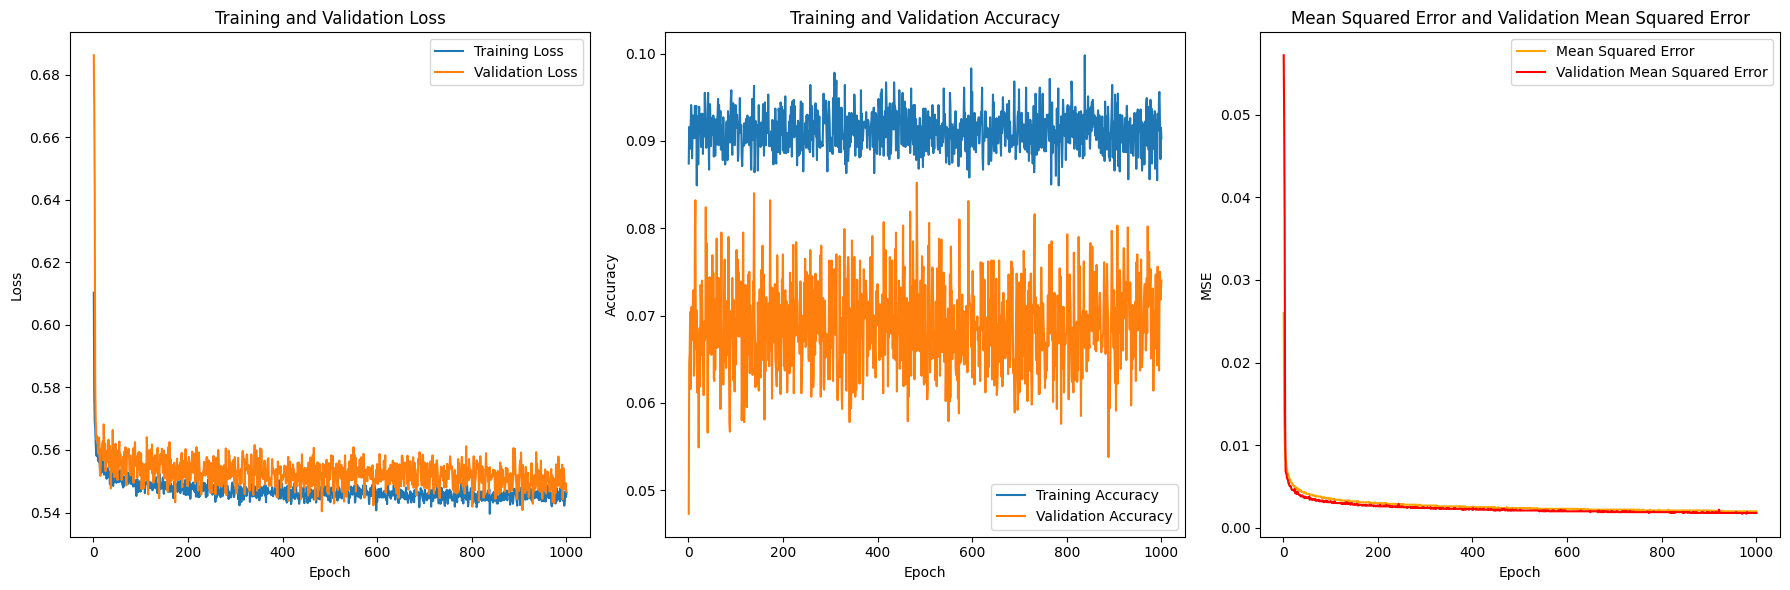

In [ ]:
import re
import matplotlib.pyplot as plt

# Initialize empty lists to store data
epochs = []
losses = []
val_losses = []
accuracies = []
val_accuracies = []
mse = []  # Mean Squared Error
val_mse = []  # Validation Mean Squared Error

# Regular expression pattern to match lines containing numeric values
numeric_pattern = re.compile(r'(?::\s)?(\d+\.\d+)')

# Iterate over each epoch's log
for match in re.finditer(r'Epoch (\d+)/\d+', training_logs):
    epoch_number = int(match.group(1))

    # Get the log from the current match to the end of the string
    current_log = training_logs[match.end():]

    # Extract loss, accuracy, validation loss, validation accuracy, MSE, and validation MSE
    match_values = re.search(r'loss: (\d+\.\d+).*mse: (\d+\.\d+).*accuracy: (\d+\.\d+).*val_loss: (\d+\.\d+).*val_mse: (\d+\.\d+).*val_accuracy: (\d+\.\d+)', current_log)

    if match_values:
        values = [float(match_values.group(i)) for i in range(1, 7)]

        # Append data to lists
        epochs.append(epoch_number)
        losses.append(values[0])
        mse.append(values[1])
        accuracies.append(values[2])
        val_losses.append(values[3])
        val_mse.append(values[4])
        val_accuracies.append(values[5])

# Plotting
plt.figure(figsize=(18, 6))

# Plot training and validation losses
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Mean Squared Error and Validation Mean Squared Error
plt.subplot(1, 3, 3)
plt.plot(epochs, mse, label='Mean Squared Error', color='orange')
plt.plot(epochs, val_mse, label='Validation Mean Squared Error', color='red')
plt.title('Mean Squared Error and Validation Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()
